# Vaccine Effectiveness in Fortaleza - Storyline

**Author**: Higor S. Monteiro<br>
**Date**: 2022/03/23

The main goal of this notebook is to obtain the main summaries and figures to plot the storyline of the final manuscript.

The storyline is supposed to be divided by the following topics:
1. **Covid-19 contextualization in Fortaleza**.
    - **Outcomes**: Deaths, Hospitalizations and ICU admissions.
    - **Vaccination**: Vaccine coverage of first and second dose for each vaccine. 
2. **Cohort details**.
3. **Matching details and summaries**.
4. **Survival analysis summaries: Kaplan-Meier curves**.
5. **Vaccine effectiveness**.
    - Stratifications by `age`, `sex` and `HDI`.

# Prepare data and Figure objects

For this notebook, we have performed different runs considering several parameters combinations for two vaccines: `CORONAVAC` and `ASTRAZENECA`. The first test relates to how we select the general population to be considered as potential controls: the first one, with prefix `VACPOPUL`, consider only the population who took a given vaccine or who didn't take any vaccine at all. The second one, with prefix `TODAPOPUL`, consider the complete population under the eligibility criteria but independent of which vaccine an individual might take afterwards.<br>

Although it seems clear that `TODAPOPUL` provides the most robust design, as we cannot remove someone from the study because the vaccine he/she takes after the start of the cohort, we calculated both cases as the results of `VACPOPUL` was shown previously in the beginning of the project and it seems useful to compare both cases to avoid any confusions.

**Update 2022/04/07:**<br>
We have performed new tests regarding the matching procedure. Now including the prefix `PRI_NA_COORTE` we have including new conditions during matching to avoid defining pairs where one of the individuals is already infected. 

We also have performed the matching for `three` different seeds for the potential controls such that we could verify the influence of randomness in the control selection. 

We calculate the **Vaccine Effectiveness** for two different cohort periods:<br>
&emsp; 1. `21-01-2021` to `30-06-2021`;<br>
&emsp; 2. `21-01-2021` to `31-08-2021`.<br>

The second period, which is longer, was used mainly because of the coverage of the `ASTRAZENECA` vaccine. Therefore, we also have used a shorter cohort period for `CORONAVAC` as the number of second dose applied of this vaccine during this period are enough to capture its effectiveness.

**Update 2022/04/22:**<br>
Considering the results of the analysis above, we have modified the matching mechanism to avoid the matching between already sick case or controls (using date of first symptoms). To this new test, we have used the identification `PRI_NA_COORTEX`. To this, we considered only the `CORONAVAC` vaccine, keeping the same two different cohort period definitions.

## Lib

In [1]:
import sys
sys.path.append("..")

import os
import pandas as pd
import numpy as np
import datetime as dt
from collections import defaultdict
import lib.utils as utils
from src.FigUtils import FigUtils

import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from IPython.display import Image
%matplotlib inline

## Set file paths

In [20]:
base_path = os.path.join(os.environ["USERPROFILE"], "Documents")
parquet_folder = os.path.join(base_path, "data", "PARQUET_TRANSFORMED")
project_folder = os.path.join(base_path, "projects", "vaccine-eff-fortaleza")
fig_pres = os.path.join(project_folder, "output", "figs", "meeting_jun6_2022")

fig_folder = os.path.join(project_folder, "output", "figs", "Fig2022_MarchRuns")
schema_folder = os.path.join(project_folder, "output", "data")
pareamento_folder = os.path.join(project_folder, "output", "PAREAMENTO")

**Config**

In [3]:
config = {
    'vaccine': "CORONAVAC",
    'seed': 1,
    'hdi_index': 2,
    'prefix test': 'NOVO',
    'dose': 'D1',
    'day_risk': 0,
}
fig_folder = os.path.join(fig_folder, config['vaccine'], config['prefix test'])
if not os.path.isdir(fig_folder):
    os.mkdir(fig_folder)
figsuffix = f"SEED{config['seed']}_HDI_{config['hdi_index']}_TEST_{config['prefix test']}.pdf"
figsuffix_png = f"SEED{config['seed']}_HDI_{config['hdi_index']}_TEST_{config['prefix test']}.png"

## Load data

**Load final schemas -> two cohorts**.

In [4]:
# --> Load the final schemas of the two cohort defined.
cohort_1 = (dt.datetime(2021, 1, 21), dt.datetime(2021, 8, 31))
start_str_1 = f"{cohort_1[0].day}{cohort_1[0].strftime('%b').upper()}{cohort_1[0].year}"
end_str_1 = f"{cohort_1[1].day}{cohort_1[1].strftime('%b').upper()}{cohort_1[1].year}"

cohort_2 = (dt.datetime(2021, 1, 21), dt.datetime(2021, 6, 30))
start_str_2 = f"{cohort_2[0].day}{cohort_2[0].strftime('%b').upper()}{cohort_2[0].year}"
end_str_2 = f"{cohort_2[1].day}{cohort_2[1].strftime('%b').upper()}{cohort_2[1].year}"

# Final schema -> 21-01-2021 -> 31-08-2021
fschema_1 = pd.read_parquet(os.path.join(schema_folder, f"SCHEMA_{start_str_1}_{end_str_1}.parquet"))
# Final schema -> 21-01-2021 -> 30-06-2021
#fschema_2 = pd.read_parquet(os.path.join(schema_folder, f"SCHEMA_{start_str_2}_{end_str_2}.parquet"))

**Load matched pairs events: all seeds (1,2,3), all HDI strats (0,1,2), both `TODAPOPUL` and `VACPOPUL`.**

In [5]:
# --> Load pairs

# HDI stratification used in the matchings.
HDI_STRAT = {
    "0": [0.0, 1.0],
    "2": [0.0, 0.499, 0.599, 0.699, 0.799, 1.0],
}

pares_folder = os.path.join(pareamento_folder, config['vaccine'])
# Dictionary structure to hold all data generated by the analysis.
seeds = [1]
prefixes = config['prefix test']
pares_1 = {
    f"{prefixes}_HDI_0": [], f"{prefixes}_HDI_2": [], 
}
pares_2 = {
    f"{prefixes}_HDI_0": [], f"{prefixes}_HDI_2": [],
}

ev_str = lambda n: f"EVENTOS_PAREADOS_{config['dose']}_DAY{config['day_risk']}_{n}.parquet"
# Cohort: 21-01-2021 -> 31-08-2021
for hdi_index in [0,2]:
    pares_1[f"{prefixes}_HDI_{hdi_index}"] = pd.read_parquet(os.path.join(pares_folder, f"{prefixes}_HDI_{hdi_index}_{start_str_1}_{end_str_1}", ev_str(config['seed'])))
# Cohort: 21-01-2021 -> 30-06-2021
#for hdi_index in [0,2]:
#    pares_2[f"{prefixes}_HDI_{hdi_index}"] = pd.read_parquet(os.path.join(pares_folder, f"{prefixes}_HDI_{hdi_index}_{start_str_2}_{end_str_2}", ev_str(config['seed'])))

**Load survival data** -> `survival_folders_1` and `survival_folders_2` are hash of the folders containing the Kaplan-Meier and Vaccine Effectiveness data.

In [6]:
# Define the folder containing the 'SURVIVAL' folder.
# Data considered is only for the 'TODAPOPUL' analysis (which is more sounding for this observational study).
survival_folders_1 = dict() # Cohort 1
survival_folders_2 = dict() # Cohort 2
for key in pares_1.keys():
    survival_folders_1.update({f"{key}_{start_str_1}_{end_str_1}": None})
#for key in pares_2.keys():
#    survival_folders_2.update({f"{key}_{start_str_2}_{end_str_2}": None})

for key in survival_folders_1.keys():
    survival_folders_1[key] = os.path.join(pareamento_folder, config['vaccine'], key, "SURVIVAL", f"SEED{config['seed']}")
#for key in survival_folders_2.keys():
#    survival_folders_2[key] = os.path.join(pareamento_folder, config['vaccine'], key, "SURVIVAL", f"SEED{config['seed']}")

## Initiate the figure objects

In [7]:
figcohort1 = FigUtils(fschema_1, config['vaccine'], cohort_1)
#figcohort2 = FigUtils(fschema_2, config['vaccine'], cohort_2)

# Summary 21-01-2021 to 31-08-2021.
#summary_1 = figcohort1.summary_fschema()
# Summary 21-01-2021 to 30-06-2021.
#summary_2 = figcohort2.summary_fschema()

In [8]:
# --> Load the parquet files regarding the official numbers of the outcomes.
figcohort1.load_outcomes(parquet_folder)
#figcohort2.load_outcomes(parquet_folder)

# --> Generate data holding the number of outcomes (all three) along the year of 2021.
# --> Internal variable containing the counting: 'self.only_outcomes'
figcohort1.outcomes_2021(return_=False)
#figcohort2.outcomes_2021(return_=False)

# --> Generate data holding the vaccine coverage for all vaccines and for each vaccine separately.
# --> Internal variable containing the counting: 'self.vaccine_cov'.
#figcohort1.vaccine_coverage(return_=False)
#figcohort2.vaccine_coverage(return_=False)

# --> Obtain the countings of the outcomes captured by the linkage in 'Vacine Já' and
# --> the total number of outcomes in the official databases.
# --> Internal variable containing the couting: 'self.outcomes_df'.
figcohort1.compare_outcomes()
#figcohort2.compare_outcomes()

# --> Info to draw the cohort diagram
out_cohort1 = figcohort1.info_for_cohort_diagram(pares_1[f"{config['prefix test']}_HDI_{config['hdi_index']}"], include_hdi=True)
#out_cohort2 = figcohort2.info_for_cohort_diagram(pares_2[f"{config['prefix test']}_HDI_{config['hdi_index']}"], include_hdi=True)

# --> Matching recruitment during cohort
coh1_recruitment = figcohort1.recruitment_cohort(pares_1[f"{config['prefix test']}_HDI_{config['hdi_index']}"], hdi_index=config['hdi_index'], return_=True)
#coh2_recruitment = figcohort2.recruitment_cohort(pares_2[f"{config['prefix test']}_HDI_{config['hdi_index']}"], hdi_index=config['hdi_index'], return_=True)

In [16]:
# --> Choose cohort to print the numbers.
outstr = out_cohort1
for line in outstr:
    print(line)

TOTAL OF INDIVIDUALS IN THE DATABASE: 2275309
TOTAL OF PARTICIPANTS IN THE VACCINE COHORT: 358139
TOTAL OF VACCINATED AND NON VACCINATED (ANY VACCINE) AS JAN 20, 2022: 334800, 23339
MISSING DATA AND EXCLUSION CRITERIA: 
	IRREGULAR VACCINATION STATUS: 1399
	IRREGULAR DEATH DATES: 136
	HEALTH WORKERS: 93
	MISSING AGE: 0
	MISSING SEX: 0
	MISSING HDI: 32302
	IRREGULAR DATES BETWEEN TESTS AND DATES (TESTS AFTER DEATH)  114
DATA CONSIDERING HDI AND OTHERWISE: (356512, 56), (324302, 56)
Total eligible: 324302
VACCINATED WITH CORONAVAC BEFORE END OF COHORT: 170373
NOT VACCINATED WITH CORONAVAC BEFORE END OF COHORT: 153929
	AMONG THEM: 
		ASTRAZENECA:124043
		NAO VACINADO:18715
		PFIZER:7476
		CORONAVAC:2991
		JANSSEN:704
	FROM WHICH THOSE WHO TOOK OTHER VACCINE DURING COHORT ARE: 
		ASTRAZENECA:122748
		PFIZER:4992
		JANSSEN:468
MATCHED AND NON MATCHED: 140386, 29987
NUMBER OF CASES MATCHED AS CONTROL BEFORE VACCINATION: 48734


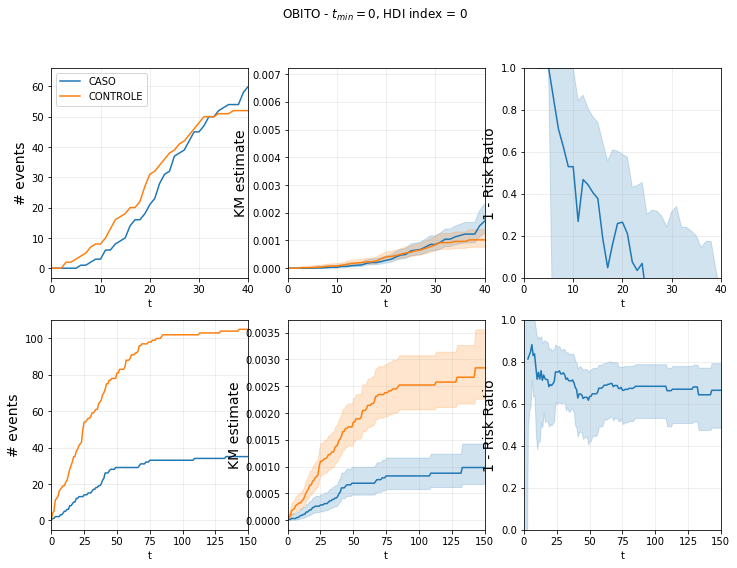

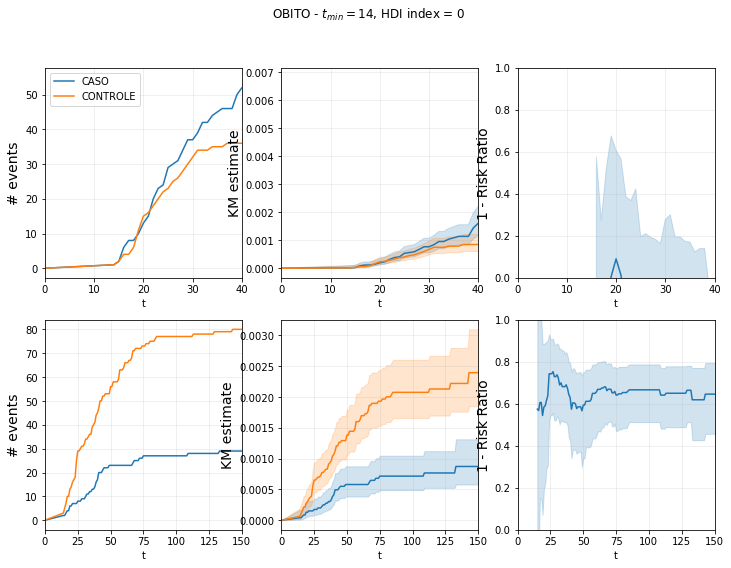

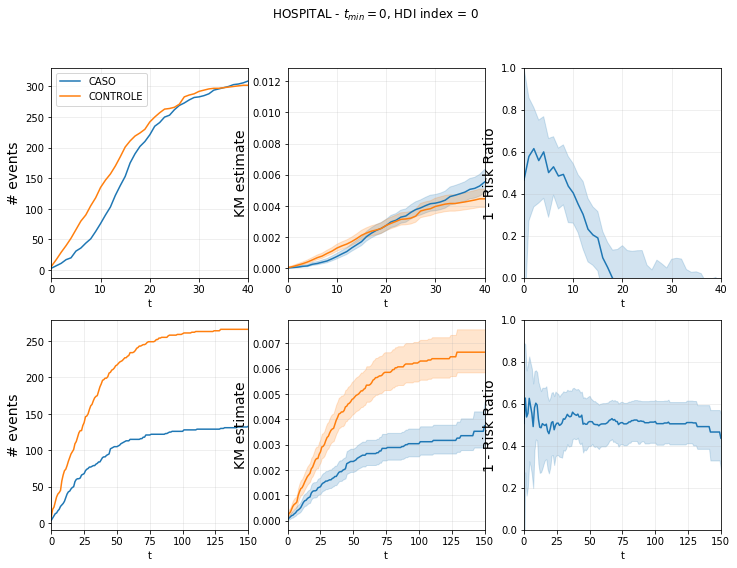

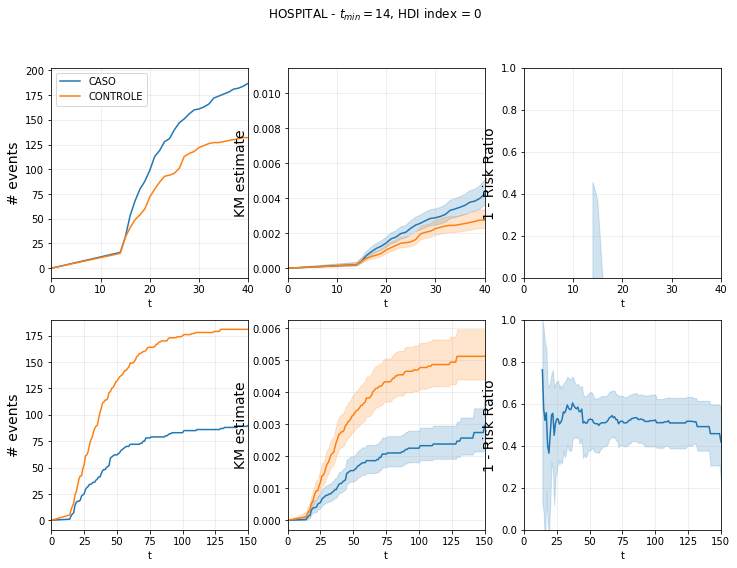

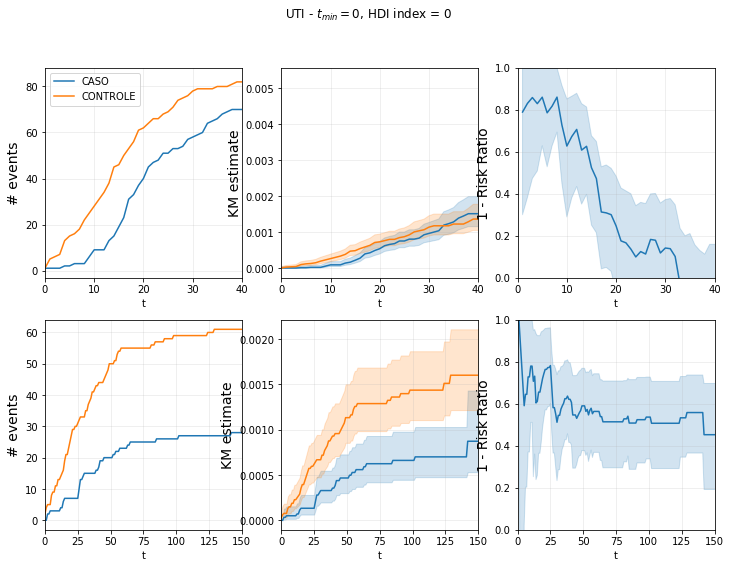

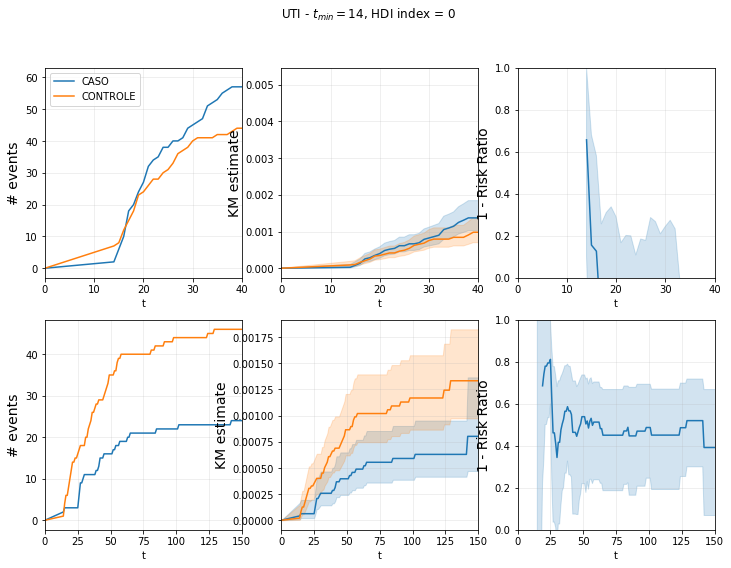

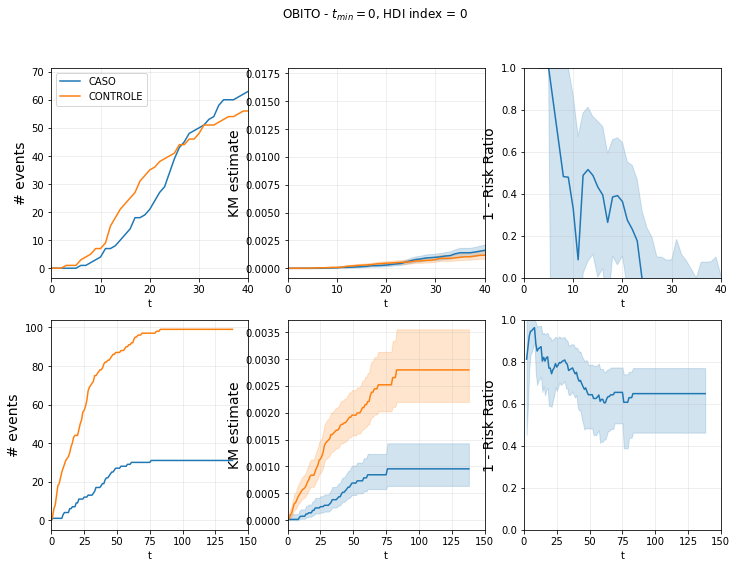

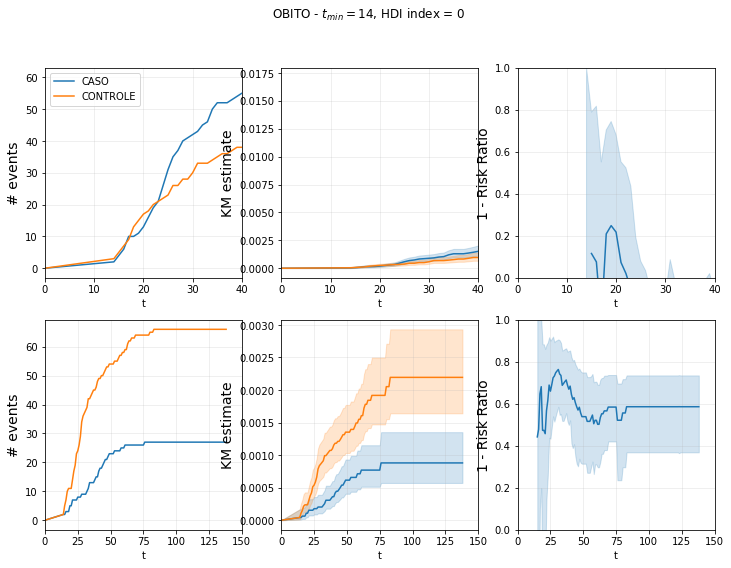

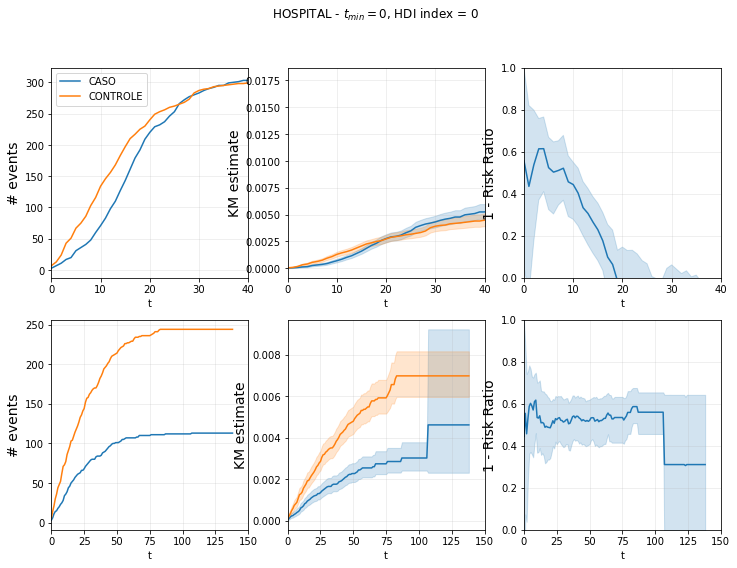

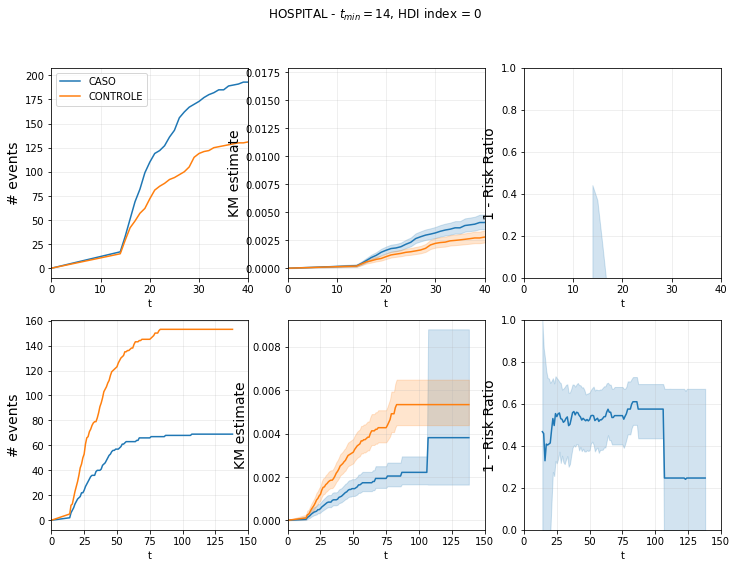

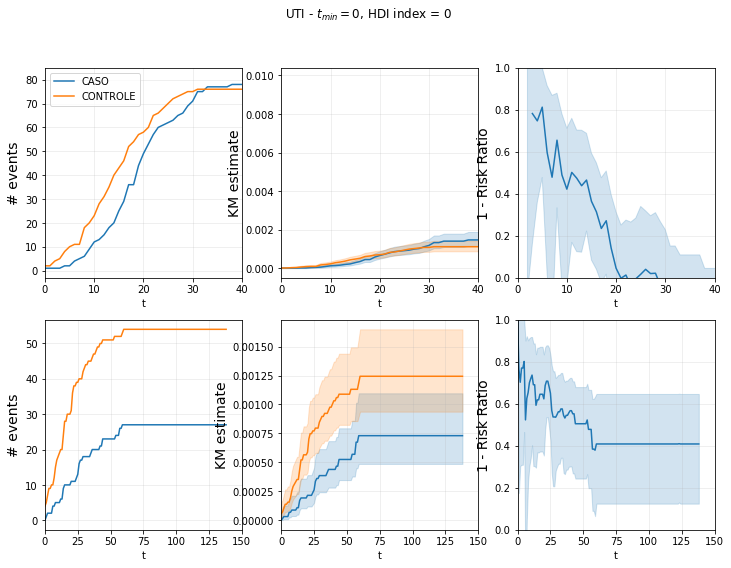

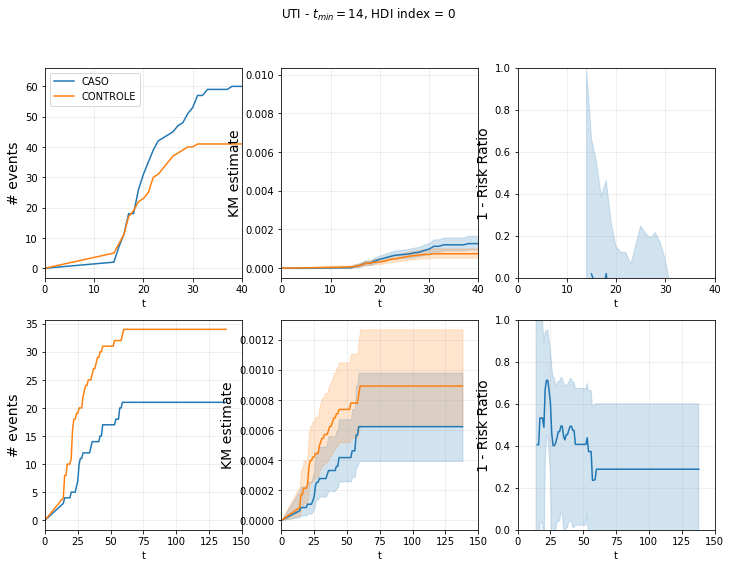

In [10]:
# --> Store the dictionaries containing the Kaplan-Meier curves
# --> Internal variable: 
surv_path1 = survival_folders_1[f"{config['prefix test']}_HDI_{config['hdi_index']}_{start_str_1}_{end_str_1}"]
surv_path2 = survival_folders_2[f"{config['prefix test']}_HDI_{config['hdi_index']}_{start_str_2}_{end_str_2}"]
# --> Store the results
survival_results = {
    "COHORT 1": {
        "OBITO": {"0": None, "14": None},
        "HOSPITAL": {"0": None, "14": None},
        "UTI": {"0": None, "14": None},
    },
    "COHORT 2": {
        "OBITO": {"0": None, "14": None},
        "HOSPITAL": {"0": None, "14": None},
        "UTI": {"0": None, "14": None},
    }
}

ve_results = {
    "COHORT 1": {
        "OBITO": None,
        "HOSPITAL": None,
        "UTI": None,
    },
    "COHORT 2": {
        "OBITO": None,
        "HOSPITAL": None,
        "UTI": None,
    }
}

# --> Cohort 1
survival_results["COHORT 1"]["OBITO"]["0"] = figcohort1.get_km_curves(surv_path1, config['hdi_index'], "OBITO", 0)
survival_results["COHORT 1"]["OBITO"]["14"] = figcohort1.get_km_curves(surv_path1, config['hdi_index'], "OBITO", 14)
survival_results["COHORT 1"]["HOSPITAL"]["0"] = figcohort1.get_km_curves(surv_path1, config['hdi_index'], "HOSPITAL", 0)
survival_results["COHORT 1"]["HOSPITAL"]["14"] = figcohort1.get_km_curves(surv_path1, config['hdi_index'], "HOSPITAL", 14)
survival_results["COHORT 1"]["UTI"]["0"] = figcohort1.get_km_curves(surv_path1, config['hdi_index'], "UTI", 0)
survival_results["COHORT 1"]["UTI"]["14"] = figcohort1.get_km_curves(surv_path1, config['hdi_index'], "UTI", 14)
# --> Cohort 2
survival_results["COHORT 2"]["OBITO"]["0"] = figcohort2.get_km_curves(surv_path2, config['hdi_index'], "OBITO", 0)
survival_results["COHORT 2"]["OBITO"]["14"] = figcohort2.get_km_curves(surv_path2, config['hdi_index'], "OBITO", 14)
survival_results["COHORT 2"]["HOSPITAL"]["0"] = figcohort2.get_km_curves(surv_path2, config['hdi_index'], "HOSPITAL", 0)
survival_results["COHORT 2"]["HOSPITAL"]["14"] = figcohort2.get_km_curves(surv_path2, config['hdi_index'], "HOSPITAL", 14)
survival_results["COHORT 2"]["UTI"]["0"] = figcohort2.get_km_curves(surv_path2, config['hdi_index'], "UTI", 0)
survival_results["COHORT 2"]["UTI"]["14"] = figcohort2.get_km_curves(surv_path2, config['hdi_index'], "UTI", 14)

# --> Cohort 1
ve_results["COHORT 1"]["OBITO"] = figcohort1.ve_plot(surv_path1, "OBITO")
ve_results["COHORT 1"]["HOSPITAL"] = figcohort1.ve_plot(surv_path1, "HOSPITAL")
ve_results["COHORT 1"]["UTI"] = figcohort1.ve_plot(surv_path1, "UTI")
# --> Cohort 2
ve_results["COHORT 2"]["OBITO"] = figcohort2.ve_plot(surv_path2, "OBITO")
ve_results["COHORT 2"]["HOSPITAL"] = figcohort2.ve_plot(surv_path2, "HOSPITAL")
ve_results["COHORT 2"]["UTI"] = figcohort2.ve_plot(surv_path2, "UTI")

# Storyline

## Outcomes time series

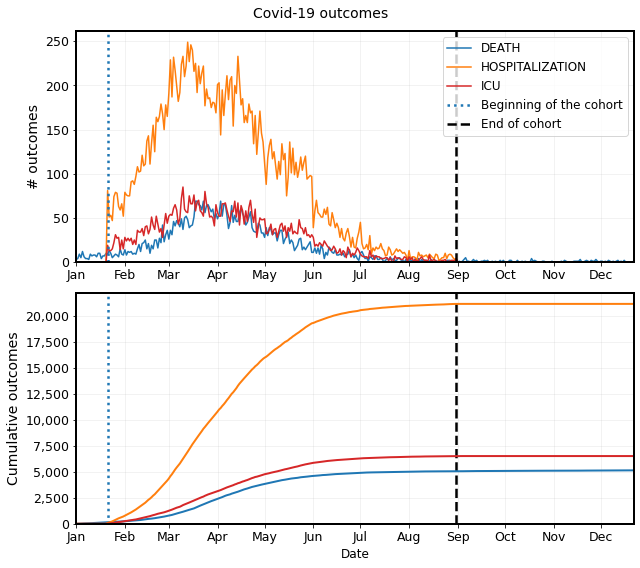

In [22]:
fig1, (ax1, ax2) = plt.subplots(2,1, figsize=(9,8))

outcomes = figcohort1.only_outcomes
init_cohort = cohort_1[0]
end_cohort1 = cohort_1[1]
end_cohort2 = cohort_2[1]

sns.lineplot(x='date', y='obito total', data=outcomes, label='DEATH', color="tab:blue", ax=ax1)
sns.lineplot(x='date', y='hospitalizacao total', data=outcomes, label='HOSPITALIZATION', color="tab:orange", ax=ax1)
sns.lineplot(x='date', y='uti total', data=outcomes, label='ICU', color="tab:red", ax=ax1)

ax1.axvline(init_cohort, ymin=0, ymax=30000, lw=2.5, ls=":", color="tab:blue", label="Beginning of the cohort")
ax1.axvline(end_cohort1, ymin=0, ymax=30000, lw=2.5, ls="--", color="k", label="End of cohort")
#ax1.axvline(end_cohort2, ymin=0, ymax=30000, lw=2.5, ls=":", color="k", label="End of cohort 2")
ax2.axvline(init_cohort, ymin=0, ymax=30000, lw=2.5, ls=":", color="tab:blue")
ax2.axvline(end_cohort1, ymin=0, ymax=30000, lw=2.5, ls="--", color="k")
#ax2.axvline(end_cohort2, ymin=0, ymax=30000, lw=2.5, ls=":", color="k")

sns.lineplot(x='date', y=outcomes['obito total'].cumsum(), lw=2, data=outcomes, color="tab:blue", ax=ax2)
sns.lineplot(x='date', y=outcomes['hospitalizacao total'].cumsum(), lw=2, data=outcomes, color="tab:orange", ax=ax2)
sns.lineplot(x='date', y=outcomes['uti total'].cumsum(), lw=2, data=outcomes, color="tab:red", ax=ax2)

for ax in [ax1, ax2]:
    ax1.legend(prop={'size': 12}, loc=1)
    ax.grid(alpha=0.2)
    ax.set_ylim(bottom=0)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.tick_params(labelsize=12.5)
    ax.set_xlim([outcomes["date"].iat[0], outcomes["date"].iat[-10]])
ax1.set_xlabel("")
ax2.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("# outcomes", fontsize=14)
ax2.set_ylabel("Cumulative outcomes", fontsize=14)

for i in ["bottom", "left", "right", "top"]:
    for ax in [ax1, ax2]:
        ax.spines[i].set_linewidth(2)
fig1.suptitle("Covid-19 outcomes", fontsize=14)
plt.tight_layout()

fig1.savefig(os.path.join(fig_pres, f"outcomes_2021.pdf"), dpi=150, bbox_inches="tight")
#fig1.savefig(os.path.join(fig_folder, f"outcomes_{figsuffix}"), dpi=150, bbox_inches="tight")
#fig1.savefig(os.path.join(fig_folder, f"outcomes_{figsuffix_png}"), dpi=150, bbox_inches="tight")

## Vaccination coverage

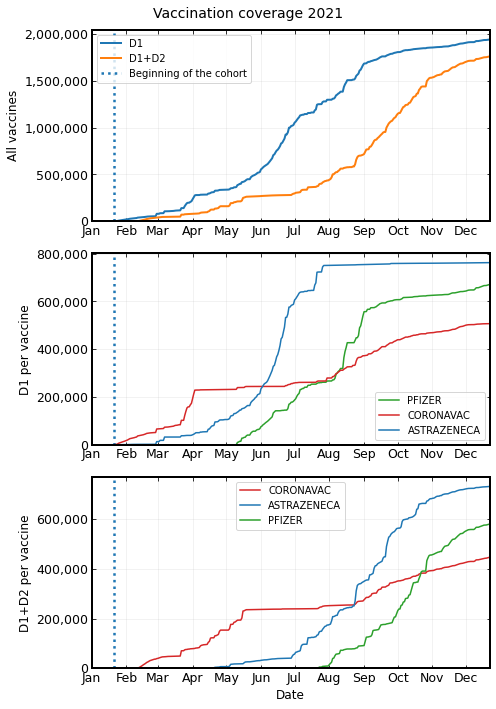

In [12]:
fig2, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(7,10))
vac_coverage = figcohort1.vaccine_cov

init_cohort = cohort_1[0]
end_cohort1 = cohort_1[1]
end_cohort2 = cohort_2[1]

sns.lineplot(x=vac_coverage['date'], y=vac_coverage['DATA D1 GERAL'].cumsum(), label='D1', lw=2, color="tab:blue", ax=ax1)
sns.lineplot(x=vac_coverage['date'], y=vac_coverage['DATA D2 GERAL'].cumsum(), label='D1+D2', lw=2, color="tab:orange", ax=ax1)

ax1.axvline(init_cohort, ymin=0, ymax=300, lw=2.5, ls=":", color="tab:blue", label="Beginning of the cohort")
ax2.axvline(init_cohort, ymin=0, ymax=300, lw=2.5, ls=":", color="tab:blue")
ax3.axvline(init_cohort, ymin=0, ymax=300, lw=2.5, ls=":", color="tab:blue")
#ax1.axvline(end_cohort1, ymin=0, ymax=300, lw=2.5, ls="--", color="k", label="End of cohort 1")
#ax1.axvline(end_cohort2, ymin=0, ymax=300, lw=2.5, ls=":", color="k", label="End of cohort 2")

sns.lineplot(x=vac_coverage['date'], y=vac_coverage['DATA D1 PFIZER'].cumsum(), label='PFIZER', lw=1.5,  color="tab:green", ax=ax2)
sns.lineplot(x=vac_coverage['date'], y=vac_coverage['DATA D1 CORONAVAC'].cumsum(), label='CORONAVAC', lw=1.5, color="tab:red", ax=ax2)
sns.lineplot(x=vac_coverage['date'], y=vac_coverage['DATA D1 ASTRAZENECA'].cumsum(), label='ASTRAZENECA', lw=1.5,  color="tab:blue", ax=ax2)

sns.lineplot(x=vac_coverage['date'], y=vac_coverage['DATA D2 CORONAVAC'].cumsum(), label='CORONAVAC', lw=1.5, color="tab:red", ax=ax3)
sns.lineplot(x=vac_coverage['date'], y=vac_coverage['DATA D2 ASTRAZENECA'].cumsum(), label='ASTRAZENECA', lw=1.5, color="tab:blue", ax=ax3)
sns.lineplot(x=vac_coverage['date'], y=vac_coverage['DATA D2 PFIZER'].cumsum(), label='PFIZER', lw=1.5, color="tab:green", ax=ax3)


ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("All vaccines", fontsize=12)
ax2.set_ylabel("D1 per vaccine", fontsize=12)
ax3.set_ylabel("D1+D2 per vaccine", fontsize=12)
for ax in [ax1, ax2, ax3]:
    ax1.legend()
    ax.grid(alpha=0.2)
    ax.set_ylim(bottom=0)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.tick_params(labelsize=12.5, direction='in', top=True, right=True)
    ax.set_xlim([vac_coverage["date"].iat[0], vac_coverage["date"].iat[-10]])
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    for i in ["bottom", "left", "right", "top"]:
        ax.spines[i].set_linewidth(2)

fig2.suptitle("Vaccination coverage 2021", fontsize=14)
plt.tight_layout()
fig2.savefig(os.path.join(fig_folder, f"vaccine_coverage_{figsuffix}"), dpi=150, bbox_inches="tight")
fig2.savefig(os.path.join(fig_folder, f"vaccine_coverage_{figsuffix_png}"), dpi=150, bbox_inches="tight")

## Outcomes captured by Vacine Já

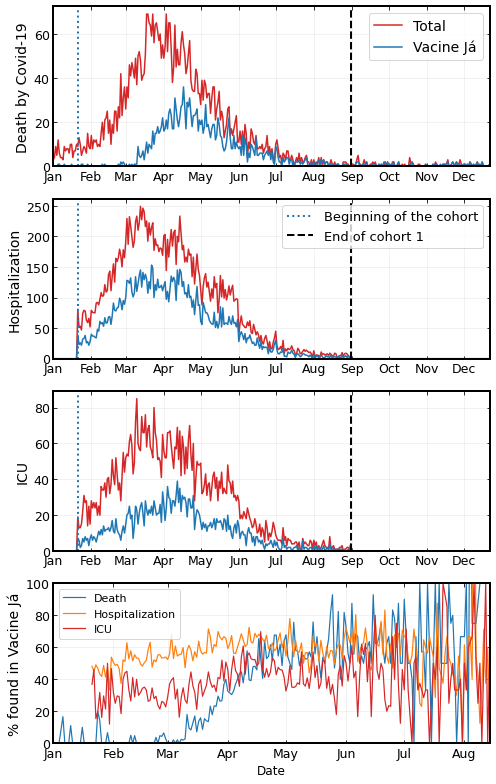

In [33]:
fig3, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(7,11))
outcomes = figcohort1.outcomes_df

init_cohort = cohort_1[0]
end_cohort1 = cohort_1[1]
end_cohort2 = cohort_2[1]

sns.lineplot(x='date', y='obito total', data=outcomes, label='Total', lw=1.5, color="tab:red", ax=ax1)
sns.lineplot(x='date', y='obito vacineja', data=outcomes, label='Vacine Já', lw=1.5, color="tab:blue", ax=ax1)

sns.lineplot(x='date', y='hospitalizacao total', data=outcomes, lw=1.5, color="tab:red", ax=ax2)
sns.lineplot(x='date', y='hospitalizacao vacineja', data=outcomes, lw=1.5, color="tab:blue", ax=ax2)

sns.lineplot(x='date', y='uti total', data=outcomes, lw=1.5, color="tab:red", ax=ax3)
sns.lineplot(x='date', y='uti vacineja', data=outcomes, lw=1.5, color="tab:blue", ax=ax3)

# Proportion
sns.lineplot(x=outcomes['date'], y=(outcomes['obito vacineja']/outcomes['obito total'])*100, lw=1.2, color="tab:blue", ax=ax4, label="Death")
sns.lineplot(x=outcomes['date'], y=(outcomes['hospitalizacao vacineja']/outcomes['hospitalizacao total'])*100, lw=1.2, color="tab:orange", ax=ax4, label="Hospitalization")
sns.lineplot(x=outcomes['date'], y=(outcomes['uti vacineja']/outcomes['uti total'])*100, lw=1.2, color="tab:red", ax=ax4, label="ICU")

ax2.axvline(init_cohort, ymin=0, ymax=30000, lw=2, ls=":", color="tab:blue", label="Beginning of the cohort")
ax2.axvline(end_cohort1, ymin=0, ymax=30000, lw=2, ls="--", color="k", label="End of cohort 1")
#ax2.axvline(end_cohort2, ymin=0, ymax=30000, lw=2, ls=":", color="k", label="End of cohort 2")
ax1.axvline(init_cohort, ymin=0, ymax=30000, lw=2, ls=":", color="tab:blue")
ax1.axvline(end_cohort1, ymin=0, ymax=30000, lw=2, ls="--", color="k")
#ax1.axvline(end_cohort2, ymin=0, ymax=30000, lw=2, ls=":", color="k")
ax3.axvline(init_cohort, ymin=0, ymax=30000, lw=2, ls=":", color="tab:blue")
ax3.axvline(end_cohort1, ymin=0, ymax=30000, lw=2, ls="--", color="k")
#ax3.axvline(end_cohort2, ymin=0, ymax=30000, lw=2, ls=":", color="k")

ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("", fontsize=12)
ax4.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Death by Covid-19", fontsize=14)
ax2.set_ylabel("Hospitalization", fontsize=14)
ax3.set_ylabel("ICU", fontsize=14)
ax4.set_ylabel("% found in Vacine Já", fontsize=14)
for ax in [ax1, ax2, ax3, ax4]:
    ax.grid(alpha=0.2)
    ax.set_ylim(bottom=0)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.tick_params(labelsize=12.5, direction='in', top=True, right=True)
    ax.set_xlim([outcomes["date"].iat[0], outcomes["date"].iat[-10]])
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    for i in ["bottom", "left", "right", "top"]:
        ax.spines[i].set_linewidth(2)
        
ax4.set_xlim([outcomes["date"].iat[0], outcomes["date"].iat[-140]])
ax4.set_ylim([0,100])
ax1.legend(prop={'size': 14})
ax2.legend(prop={'size': 13})
ax4.legend(prop={'size': 11})
plt.tight_layout()

fig3.savefig(os.path.join(fig_pres, f"vacineja_outcomes_linkage_2021.png"), dpi=150, bbox_inches="tight")
#fig3.savefig(os.path.join(fig_folder, f"vacineja_outcomes_{figsuffix}"), dpi=150, bbox_inches="tight")
#fig3.savefig(os.path.join(fig_folder, f"vacineja_outcomes_{figsuffix_png}"), dpi=150, bbox_inches="tight")

## Matching mechanism

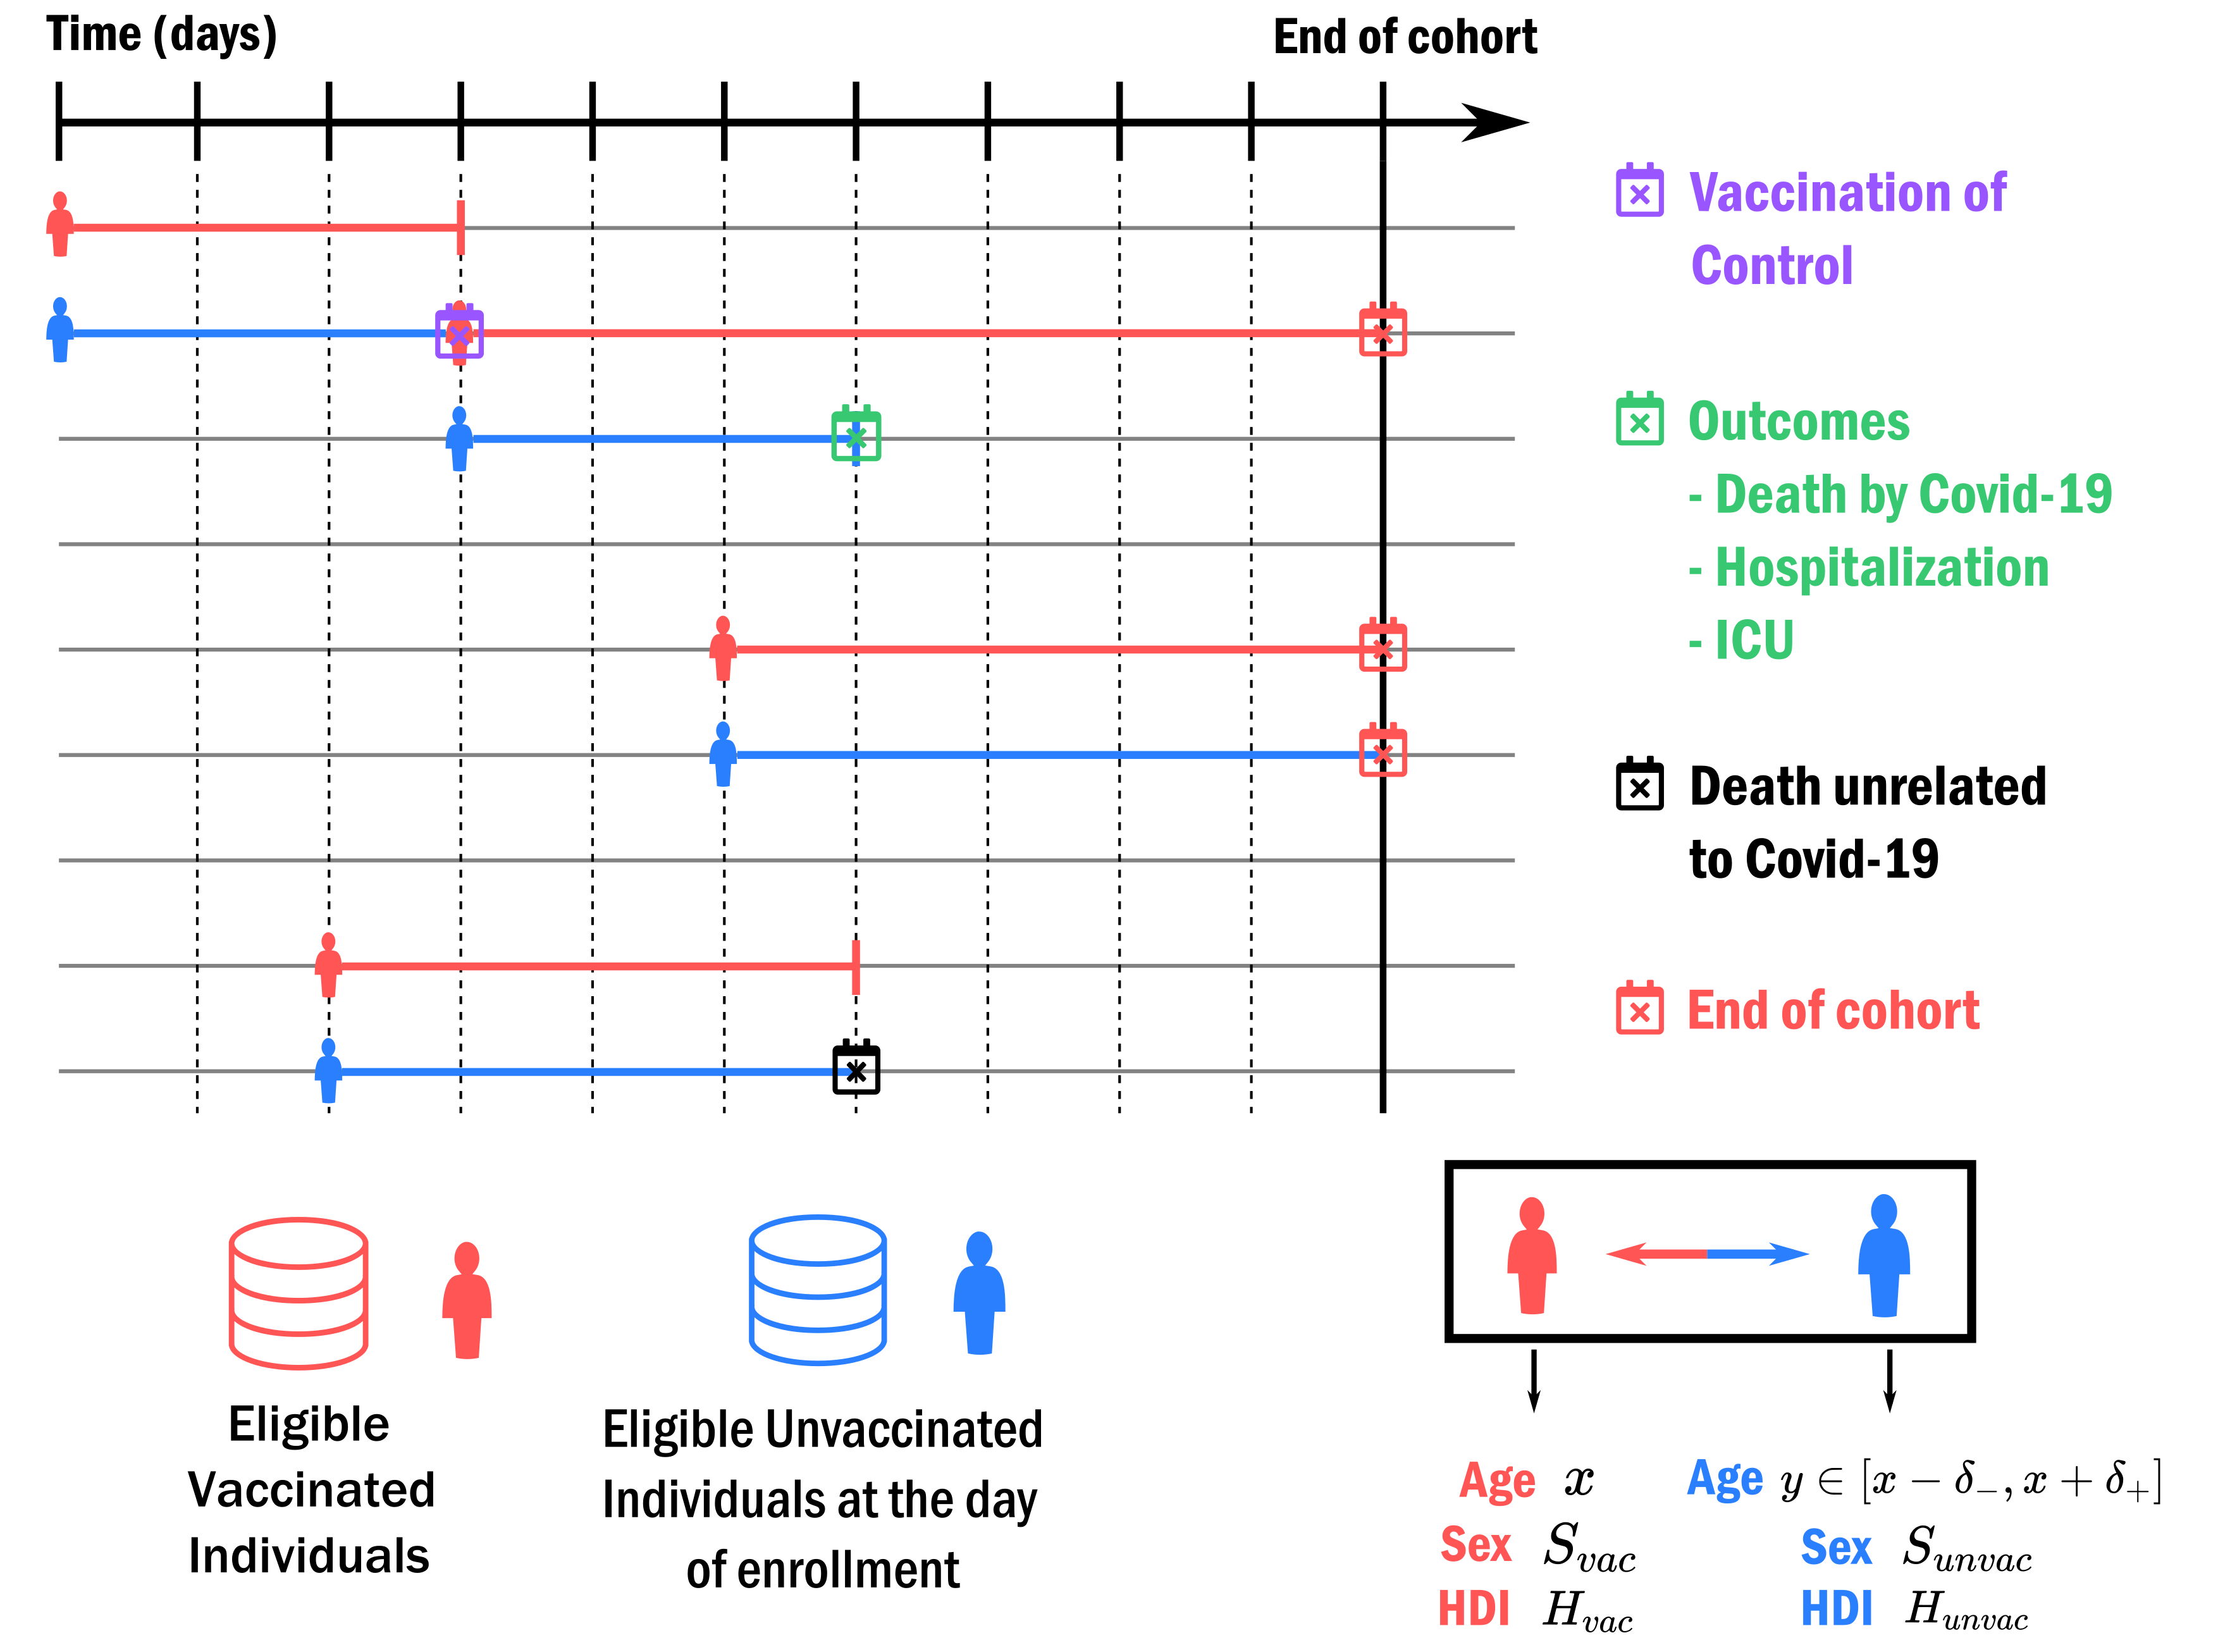

In [14]:
Image(filename='..\\output\\figs\\matching3.png', width=700) 

### Recruitment - COHORT 1: 21/01/2021 TO 31/08/2021

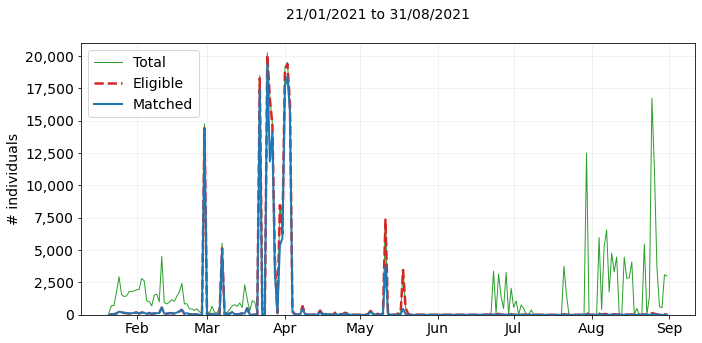

In [14]:
coh1_recruitment
fig4,ax = plt.subplots(1, figsize=(11,5))

sns.lineplot(x="index", y="D1 TOTAL", data=coh1_recruitment, label="Total", color="tab:green", ax=ax, lw=1)
sns.lineplot(x="index", y="DATA D1", data=coh1_recruitment, label="Eligible", color="tab:red", ax=ax, lw=2.5, ls="--")
sns.lineplot(x="index", y="D1 PAREADO", data=coh1_recruitment, label="Matched", color="tab:blue", ax=ax, lw=2)

ax.grid(alpha=0.2)
ax.set_ylim([0,21000])
ax.tick_params(labelsize=14)
ax.set_xlabel("", fontsize=14)
ax.set_ylabel("# individuals", fontsize=14)
ax.legend(prop={'size': 14})

# Make ticks on occurrences of each month:
ax.xaxis.set_major_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# '%b' means month as locale’s abbreviated name
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
fig4.suptitle("21/01/2021 to 31/08/2021", fontsize=14)

fig4.savefig(os.path.join(fig_folder, f"matching_cohort(31AUG2021)_{figsuffix}"), dpi=150, bbox_inches="tight")
fig4.savefig(os.path.join(fig_folder, f"matching_cohort(31AUG2021)_{figsuffix_png}"), dpi=150, bbox_inches="tight")

### Recruitment - COHORT 2: 21/01/2021 TO 30/06/2021

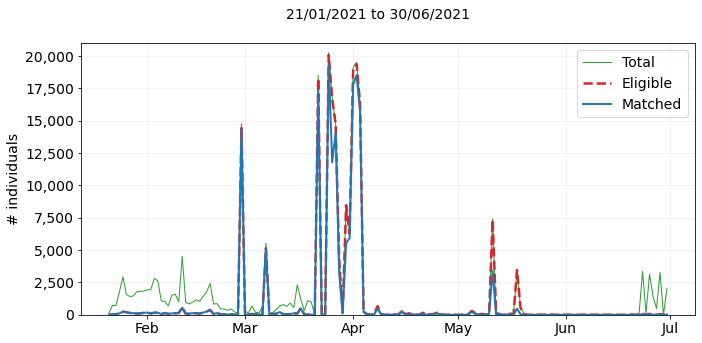

In [15]:
coh2_recruitment
fig5,ax = plt.subplots(1, figsize=(11,5))

sns.lineplot(x="index", y="D1 TOTAL", data=coh2_recruitment, label="Total", color="tab:green", ax=ax, lw=1)
sns.lineplot(x="index", y="DATA D1", data=coh2_recruitment, label="Eligible", color="tab:red", ax=ax, lw=2.5, ls="--")
sns.lineplot(x="index", y="D1 PAREADO", data=coh2_recruitment, label="Matched", color="tab:blue", ax=ax, lw=2)

ax.grid(alpha=0.2)
ax.set_ylim([0,21000])
ax.tick_params(labelsize=14)
ax.set_xlabel("", fontsize=14)
ax.set_ylabel("# individuals", fontsize=14)
ax.legend(prop={'size': 14})

# Make ticks on occurrences of each month:
ax.xaxis.set_major_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# '%b' means month as locale’s abbreviated name
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
fig5.suptitle("21/01/2021 to 30/06/2021", fontsize=14)

fig5.savefig(os.path.join(fig_folder, f"matching_cohort(30JUN2021)_{figsuffix}"), dpi=150, bbox_inches="tight")
fig5.savefig(os.path.join(fig_folder, f"matching_cohort(30JUN2021)_{figsuffix_png}"), dpi=150, bbox_inches="tight")

### Cohort details - COHORT 1: 21/01/2021 TO 31/08/2021

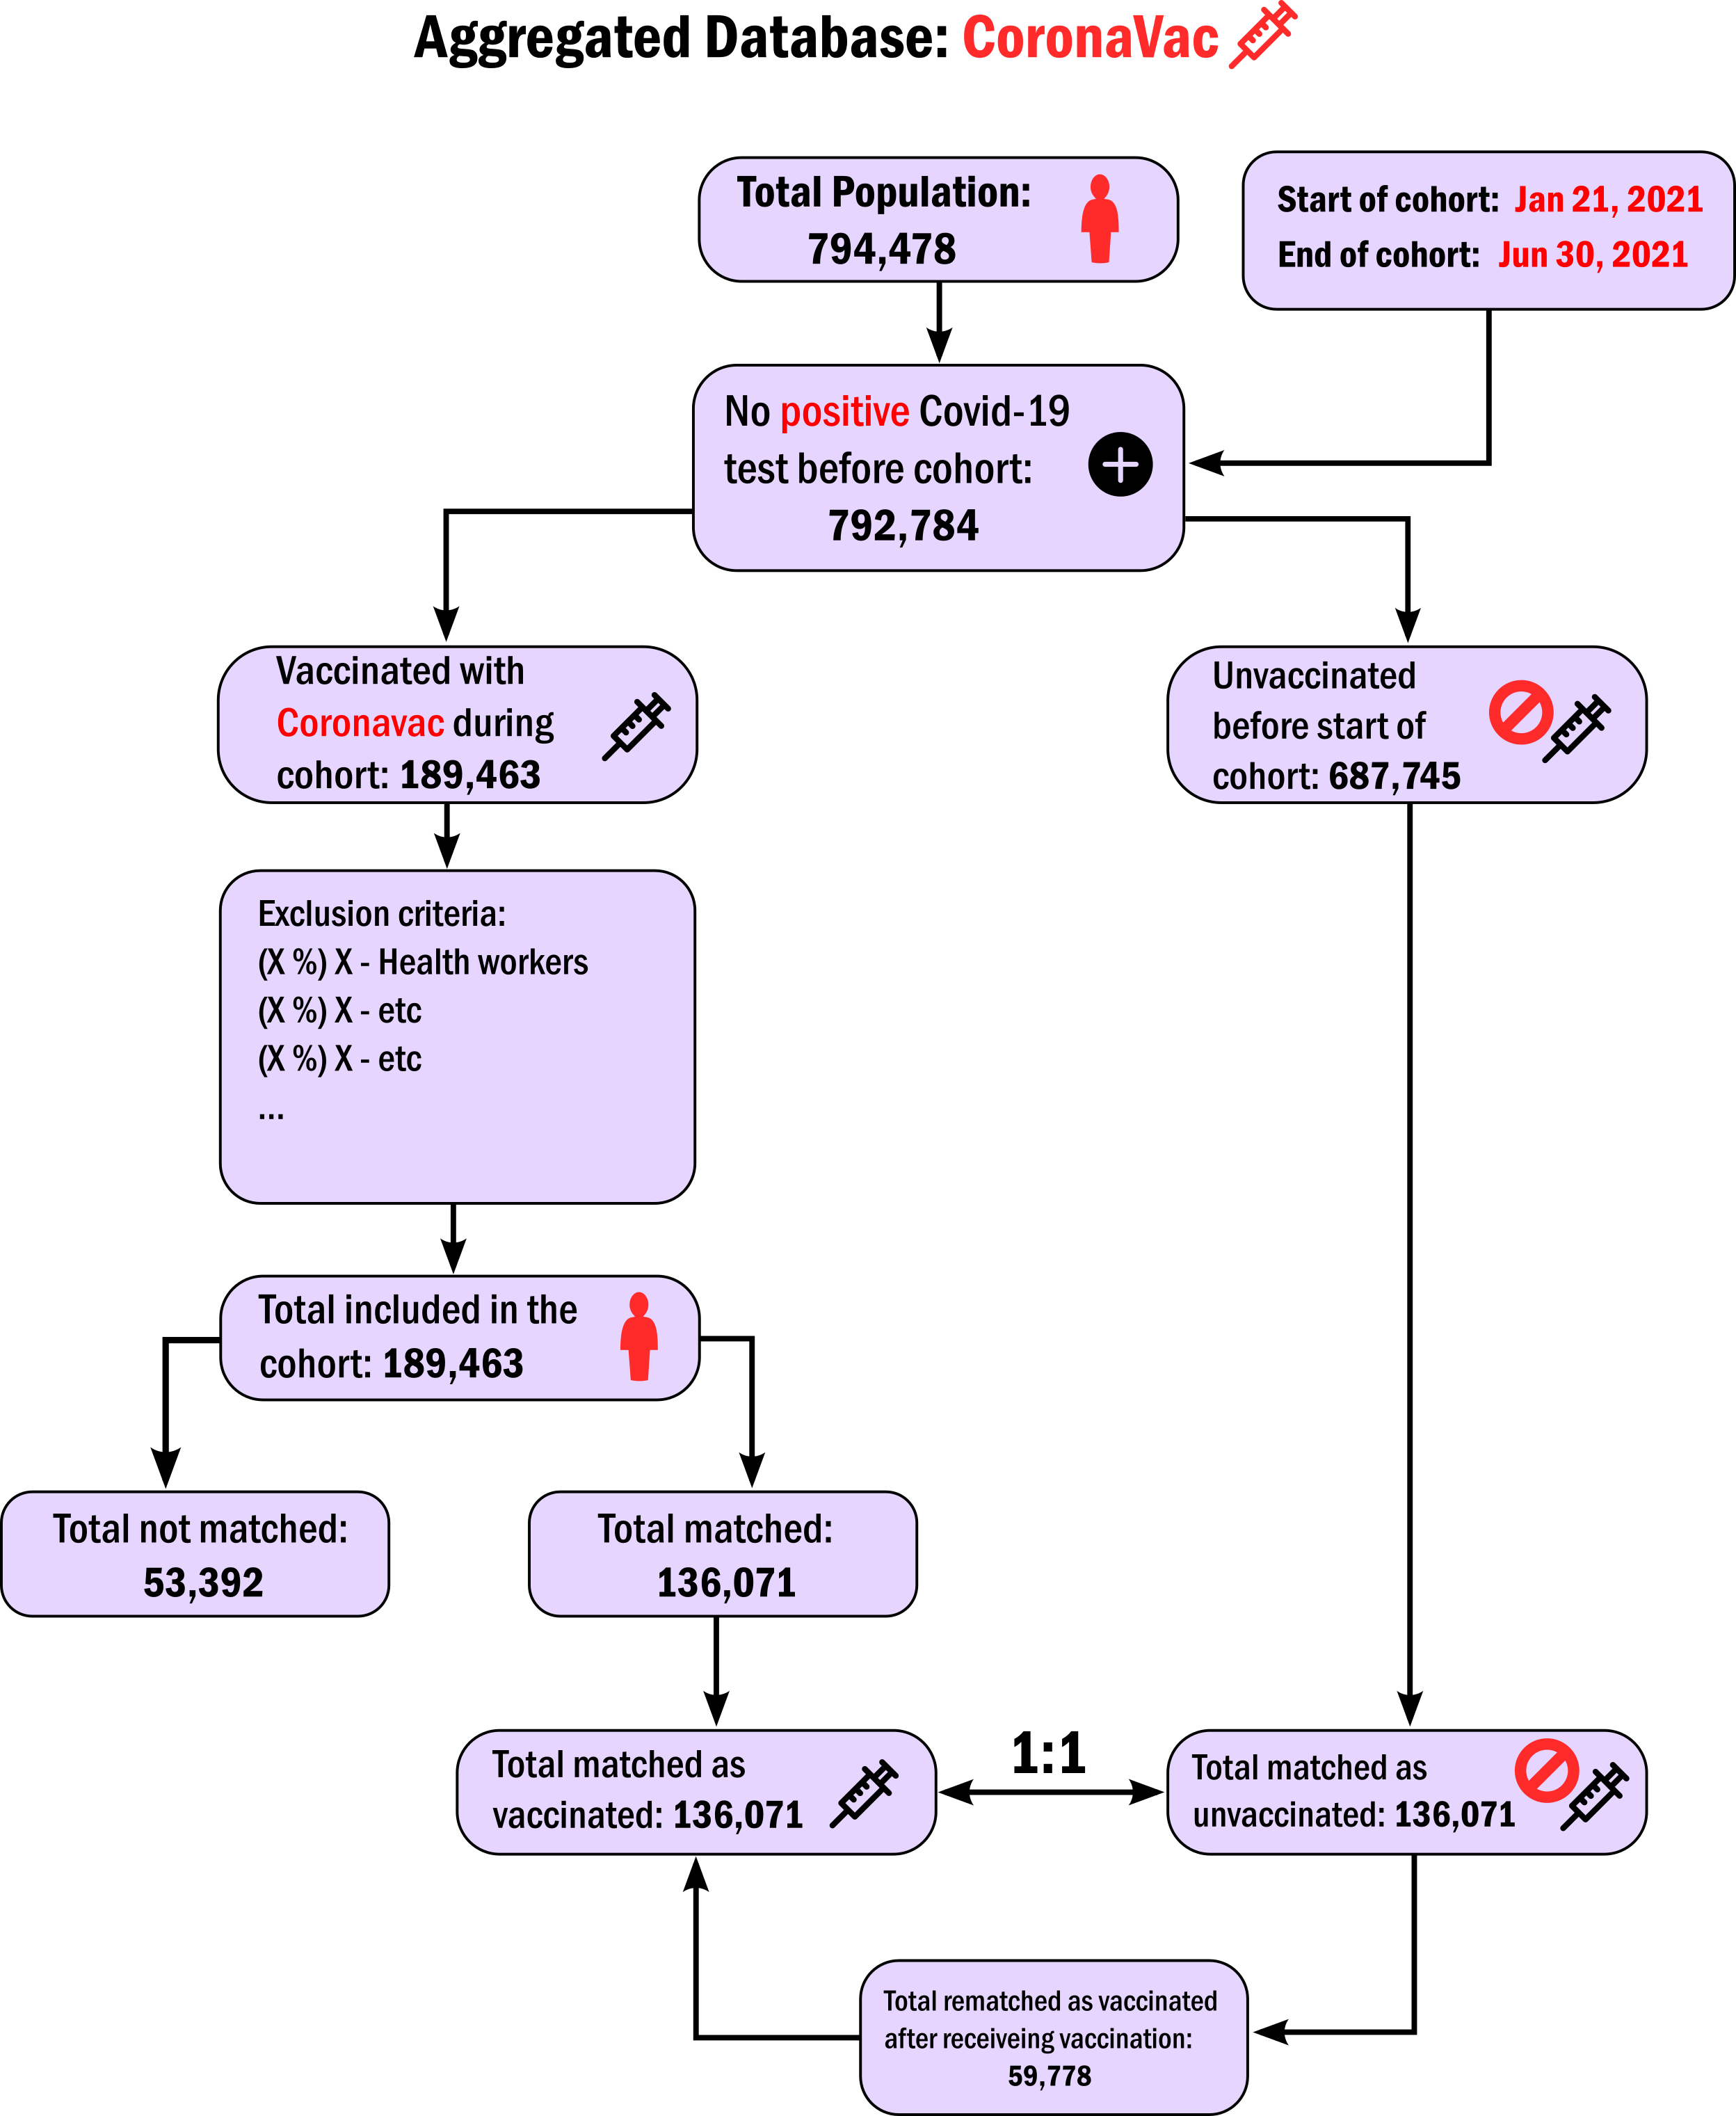

In [22]:
Image(filename='..\\output\\figs\\coronavac_cohort_diagram_png1.png', width=600) 

### Cohort details - COHORT 2: 21/01/2021 TO 31/06/2021

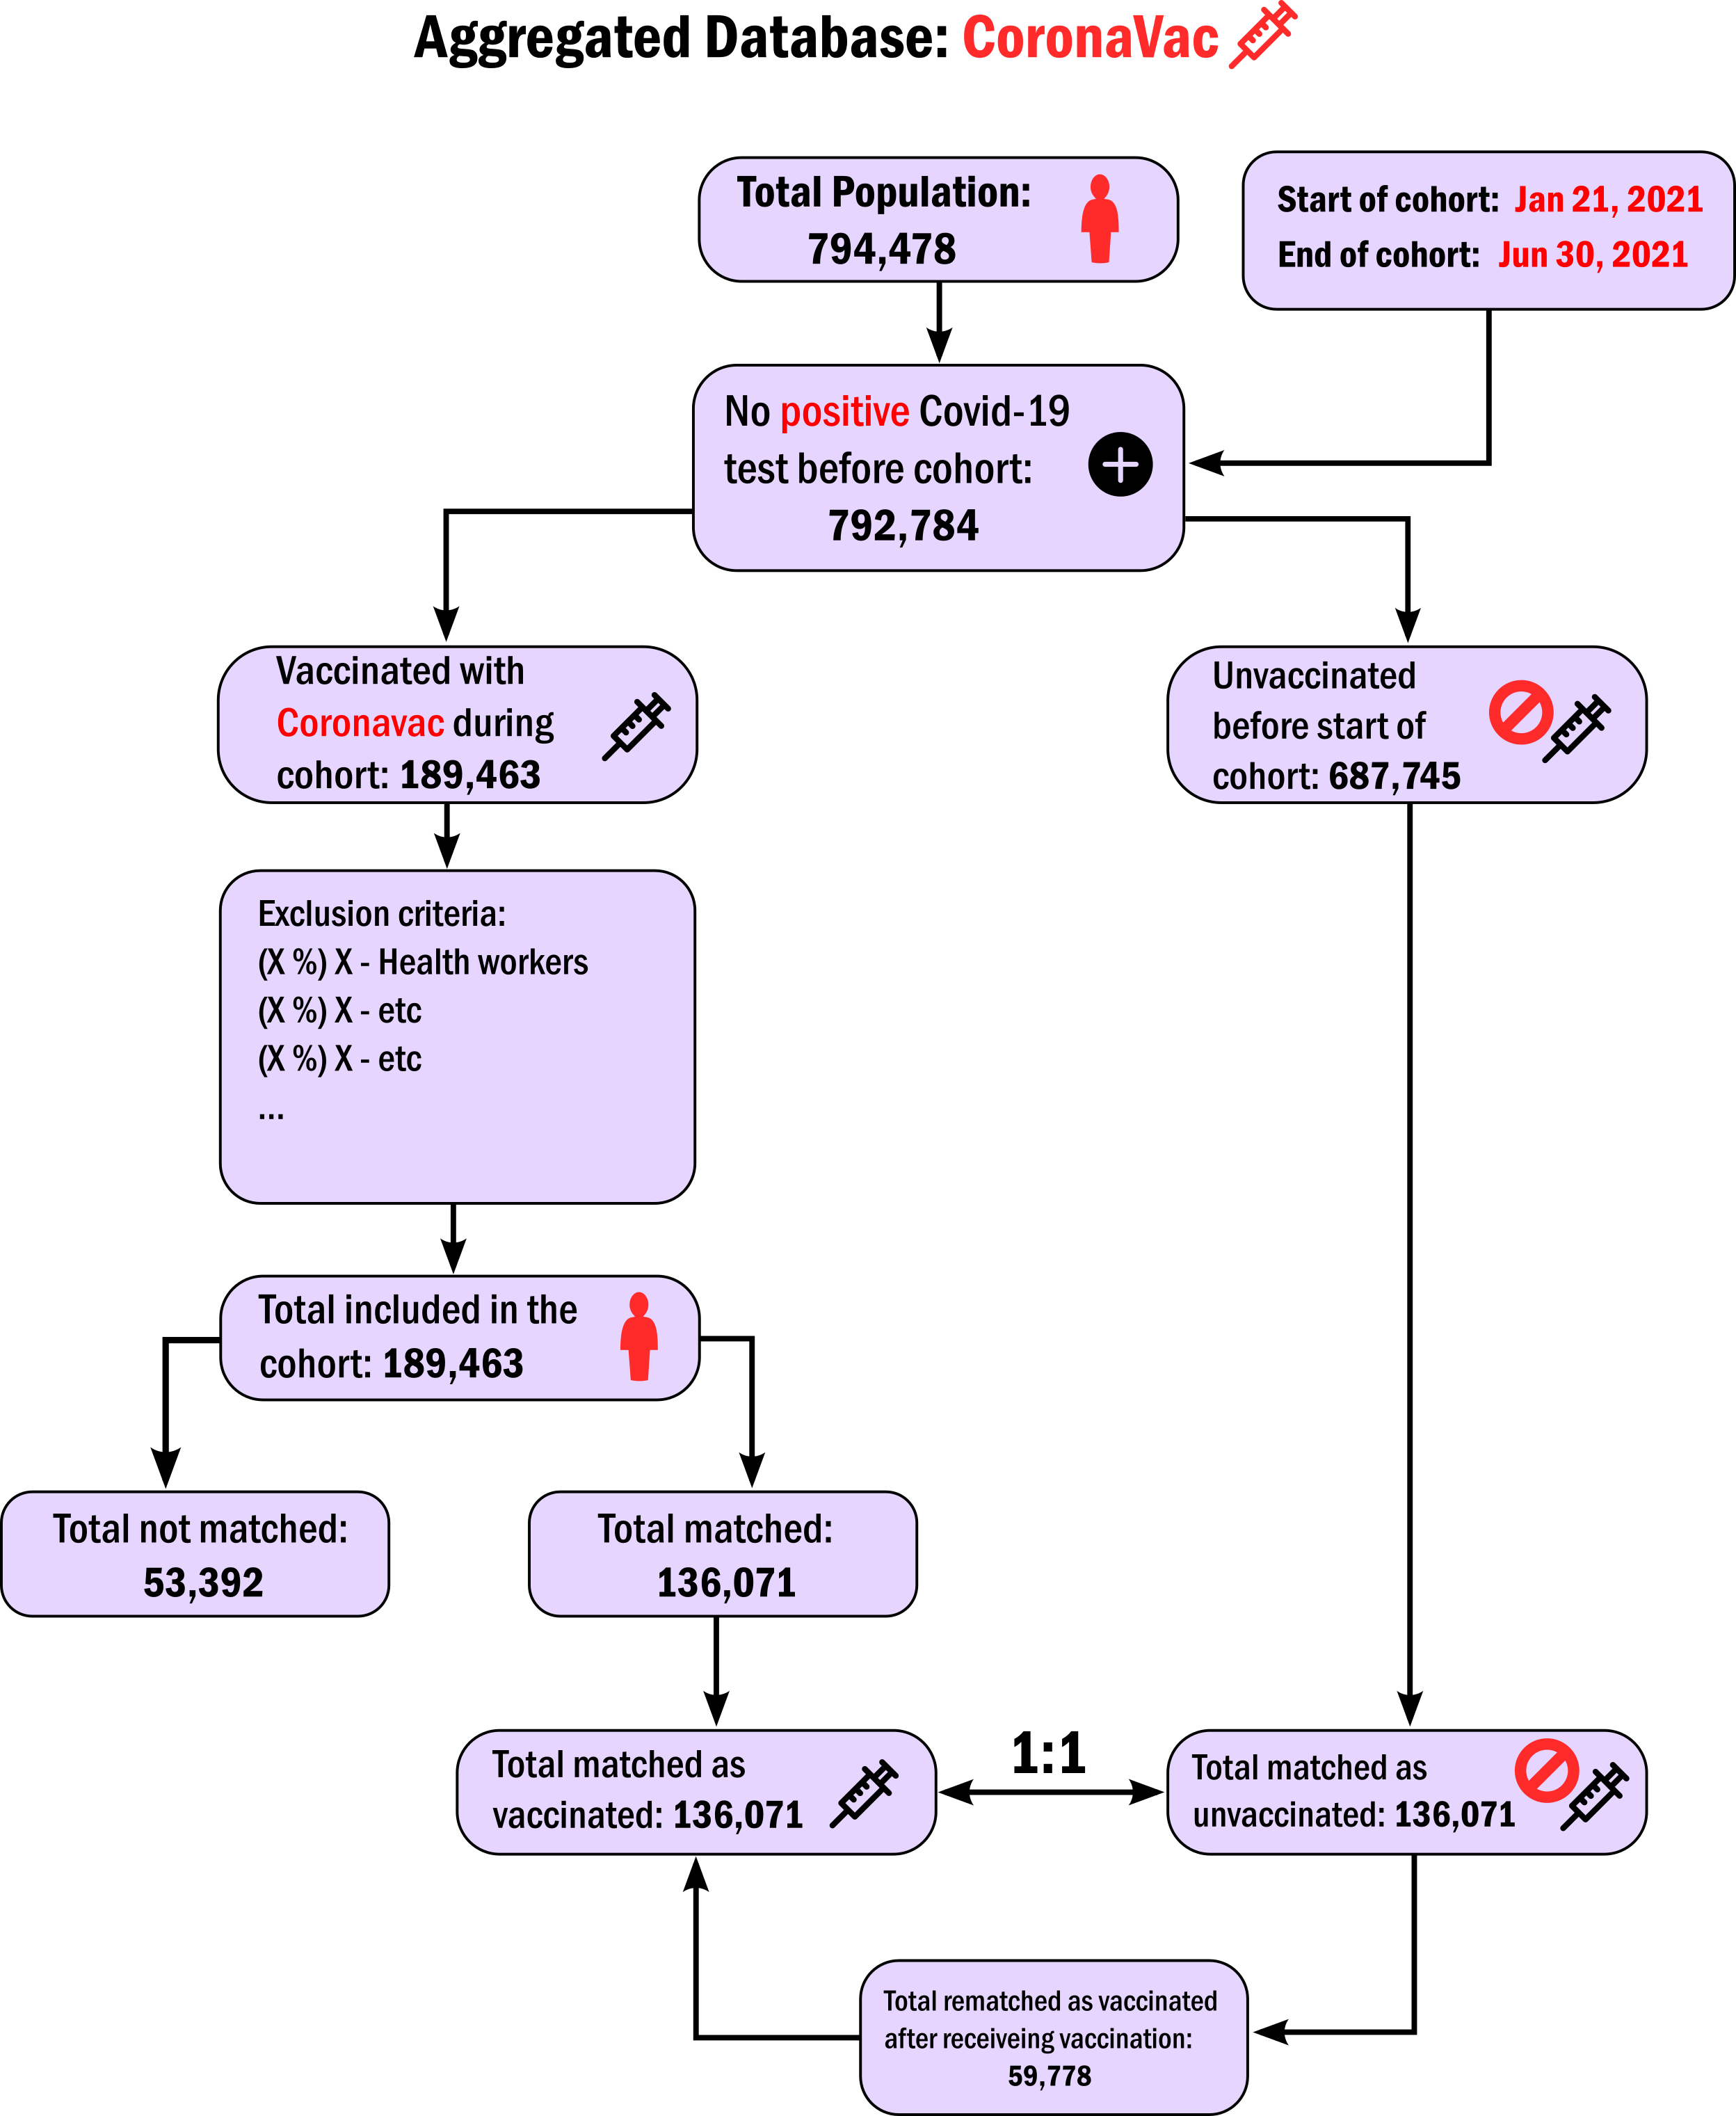

In [23]:
Image(filename='..\\output\\figs\\coronavac_cohort_diagram_png1.png', width=600) 

## Survival analysis: Kaplan-Meier curves

In [16]:
def plot_survival(survival_results, cohort_number, event, t_min, y_limd1=None, y_limd2=None, xlim=None):
    '''
    
    '''
    fig = survival_results[f"COHORT {cohort_number}"][event][f"{t_min}"][0]
    AX = survival_results[f"COHORT {cohort_number}"][event][f"{t_min}"][1]
    
    AX[0,0].set_xlim([0,30])
    AX[0,1].set_xlim([0,30])
    #AX[1,0].set_xlim([0,150])
    if y_limd1 is not None:
        AX[0,1].set_ylim(y_limd1)
    if y_limd2 is not None:
        AX[1,1].set_ylim(y_limd2)
    if xlim is not None:
        for row in [1]:
            for col in [0,1,2]:
                AX[row,col].set_xlim(xlim)
    AX[0,0].legend()
    fig.subplots_adjust(hspace=0.2, wspace=0.4)
    return fig

### Cohort 1: 21/01/2021 TO 31/08/2021

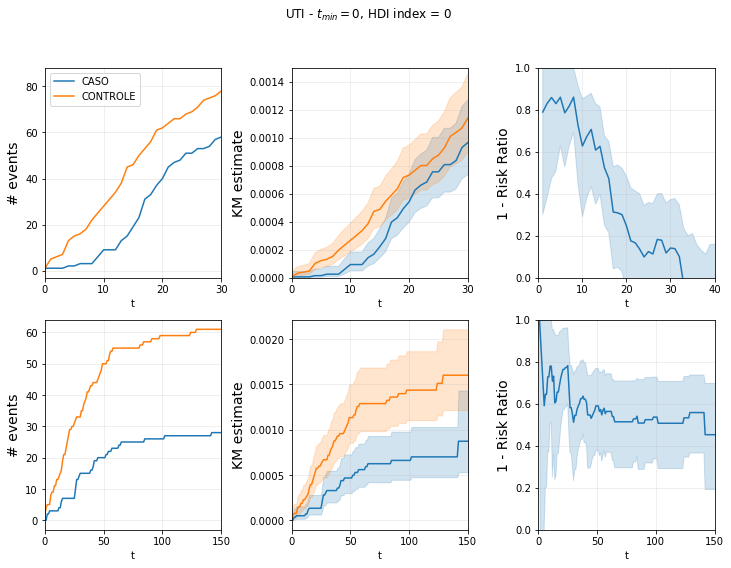

In [23]:
outcome = "UTI"
t_min = 0
fig6 = plot_survival(survival_results, 1, outcome, t_min, y_limd1=[0,0.0015])
fig6.savefig(os.path.join(fig_folder, f"KM_VE_{outcome}_(31AUG2021)_{figsuffix}"), dpi=150, bbox_inches="tight")
fig6.savefig(os.path.join(fig_folder, f"KM_VE_{outcome}_(31AUG2021)_{figsuffix_png}"), dpi=150, bbox_inches="tight")
fig6

### Cohort 2: 21/01/2021 TO 31/06/2021

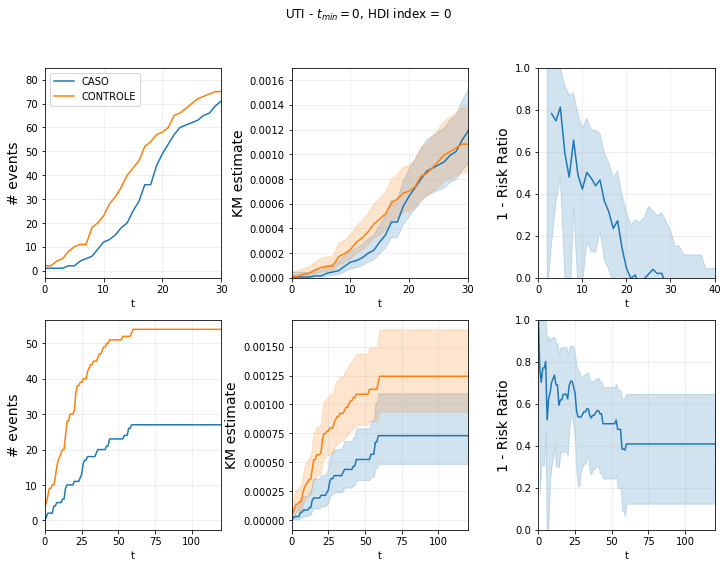

In [35]:
outcome = "UTI"
t_min = 0
fig7 = plot_survival(survival_results, 2, outcome, t_min, y_limd1=[0,0.0017], xlim=[0,120])
fig7.savefig(os.path.join(fig_folder, f"KM_VE_{outcome}_(30JUN2021)_{figsuffix}"), dpi=150, bbox_inches="tight")
fig7.savefig(os.path.join(fig_folder, f"KM_VE_{outcome}_(30JUN2021)_{figsuffix_png}"), dpi=150, bbox_inches="tight")
fig7

## Vaccine Effectiveness

In [24]:
# --> Cohort 1
suffix = ""
ve_results["COHORT 1"]["OBITO"] = figcohort1.ve_plot(surv_path1, "OBITO", suffix=suffix)
ve_results["COHORT 1"]["HOSPITAL"] = figcohort1.ve_plot(surv_path1, "HOSPITAL", suffix=suffix)
ve_results["COHORT 1"]["UTI"] = figcohort1.ve_plot(surv_path1, "UTI", suffix=suffix)
# --> Cohort 2
ve_results["COHORT 2"]["OBITO"] = figcohort2.ve_plot(surv_path2, "OBITO", suffix=suffix)
ve_results["COHORT 2"]["HOSPITAL"] = figcohort2.ve_plot(surv_path2, "HOSPITAL", suffix=suffix)
ve_results["COHORT 2"]["UTI"] = figcohort2.ve_plot(surv_path2, "UTI", suffix=suffix)

### Cohort 1: 21/01/2021 TO 31/08/2021

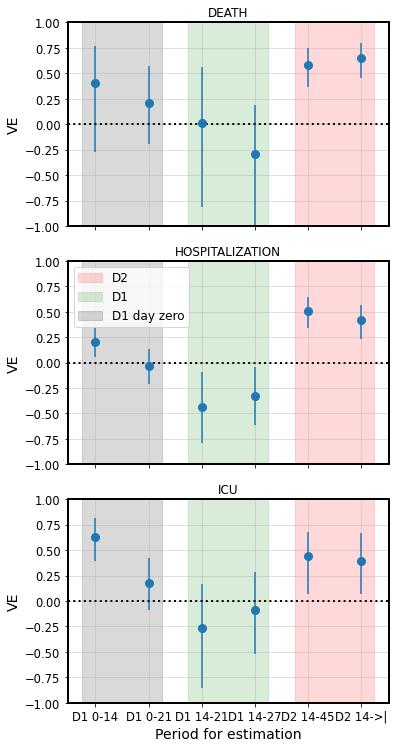

In [25]:
fig8, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(5.5,10.5))
cohort_number = 1
labels1, vem0951, ve1, vep0951 = ve_results[f"COHORT {cohort_number}"]["OBITO"]
labels2, vem0952, ve2, vep0952 = ve_results[f"COHORT {cohort_number}"]["HOSPITAL"]
labels3, vem0953, ve3, vep0953 = ve_results[f"COHORT {cohort_number}"]["UTI"]

ax1.errorbar(labels1, ve1, yerr=np.array([np.array(ve1)-np.array(vem0951), np.array(vep0951)-np.array(ve1)]), marker="o", ms=8, ls="", color="tab:blue")
ax2.errorbar(labels2, ve2, yerr=np.array([np.array(ve2)-np.array(vem0952), np.array(vep0952)-np.array(ve2)]), marker="o", ms=8, ls="", color="tab:blue")
ax3.errorbar(labels3, ve3, yerr=np.array([np.array(ve3)-np.array(vem0953), np.array(vep0953)-np.array(ve3)]), marker="o", ms=8, ls="", color="tab:blue")

for axis in [ax1, ax2, ax3]:
    axis.set_ylim([-1,1])
    axis.grid(alpha=0.5)
    ax3.set_xlabel("Period for estimation", fontsize=14)
    axis.set_ylabel("VE", fontsize=14)
    axis.tick_params(labelsize=11)
    axis.axhline(y=0, color="black", lw=2, ls=":")
    axis.fill_between([3.75, 5.25], -1.0, 1.0, alpha=0.15, color="red", label="D2")
    axis.fill_between([1.75, 3.25], -1.0, 1.0, alpha=0.15, color="green",label="D1")
    axis.fill_between([-0.25, 1.25], -1.0, 1.0, alpha=0.15, color="black", label="D1 day zero")
    axis.tick_params(labelsize=11.5)

ax2.legend(loc=2, prop={'size':12})
ax1.set_xticklabels([])
ax2.set_xticklabels([])
    
for axis in [ax1, ax2, ax3]:
    for i in ["left", "right", "bottom", "top"]:
        axis.spines[i].set_linewidth(2)
        
ax1.set_title("DEATH", fontsize=12)
ax2.set_title("HOSPITALIZATION", fontsize=12)
ax3.set_title("ICU", fontsize=12)

plt.subplots_adjust(hspace=0.3)
plt.tight_layout()
fig8.savefig(os.path.join(fig_folder, f"VE_GENERAL_(31AUG2021)_{figsuffix}"), dpi=150, bbox_inches="tight")
fig8.savefig(os.path.join(fig_folder, f"VE_GENERAL_(31AUG2021)_{figsuffix_png}"), dpi=150, bbox_inches="tight")

### Cohort 2: 21/01/2021 TO 30/06/2021

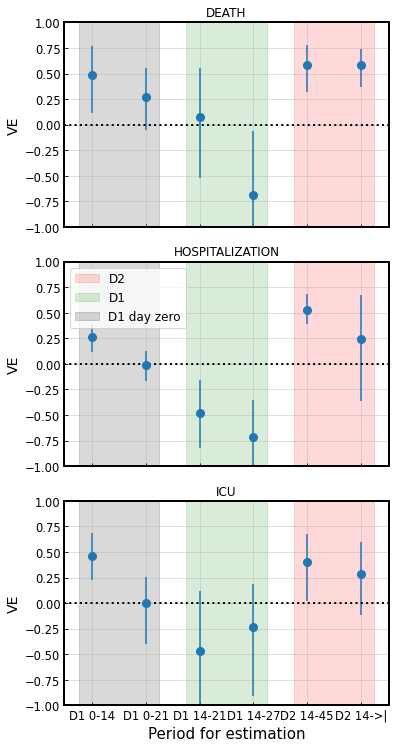

In [26]:
fig9, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(5.5,10.5))
cohort_number = 2
labels1, vem0951, ve1, vep0951 = ve_results[f"COHORT {cohort_number}"]["OBITO"]
labels2, vem0952, ve2, vep0952 = ve_results[f"COHORT {cohort_number}"]["HOSPITAL"]
labels3, vem0953, ve3, vep0953 = ve_results[f"COHORT {cohort_number}"]["UTI"]

ax1.errorbar(labels1, ve1, yerr=np.array([np.array(ve1)-np.array(vem0951), np.array(vep0951)-np.array(ve1)]), marker="o", ms=8, ls="", color="tab:blue")
ax2.errorbar(labels2, ve2, yerr=np.array([np.array(ve2)-np.array(vem0952), np.array(vep0952)-np.array(ve2)]), marker="o", ms=8, ls="", color="tab:blue")
ax3.errorbar(labels3, ve3, yerr=np.array([np.array(ve3)-np.array(vem0953), np.array(vep0953)-np.array(ve3)]), marker="o", ms=8, ls="", color="tab:blue")

for axis in [ax1, ax2, ax3]:
    axis.set_ylim([-1,1])
    axis.grid(alpha=0.5)
    ax3.set_xlabel("Period for estimation", fontsize=15)
    axis.set_ylabel("VE", fontsize=14)
    axis.tick_params(labelsize=11, direction="in")
    axis.axhline(y=0, color="black", lw=2, ls=":")
    axis.fill_between([3.75, 5.25], -1.0, 1.0, alpha=0.15, color="red", label="D2")
    axis.fill_between([1.75, 3.25], -1.0, 1.0, alpha=0.15, color="green",label="D1")
    axis.fill_between([-0.25, 1.25], -1.0, 1.0, alpha=0.15, color="black", label="D1 day zero")
    axis.tick_params(labelsize=11.5)

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax2.legend(loc=2, prop={'size':12})

    
for axis in [ax1, ax2, ax3]:
    for i in ["left", "right", "bottom", "top"]:
        axis.spines[i].set_linewidth(2)
        
ax1.set_title("DEATH", fontsize=12)
ax2.set_title("HOSPITALIZATION", fontsize=12)
ax3.set_title("ICU", fontsize=12)

plt.subplots_adjust(hspace=0.3)
plt.tight_layout()
fig9.savefig(os.path.join(fig_folder, f"VE_GENERAL_(30JUN2021)_{figsuffix}"), dpi=150, bbox_inches="tight")
fig9.savefig(os.path.join(fig_folder, f"VE_GENERAL_(30JUN2021)_{figsuffix_png}"), dpi=150, bbox_inches="tight")

### HDI strat - COHORT 1

In [27]:
if config["hdi_index"]==2:
    ve_death = pd.read_excel(os.path.join(surv_path1, f"VE_0_OBITO.xlsx"), sheet_name=None)
    ve_hosp = pd.read_excel(os.path.join(surv_path1, f"VE_0_HOSPITAL.xlsx"), sheet_name=None)
    ve_icu = pd.read_excel(os.path.join(surv_path1, f"VE_0_UTI.xlsx"), sheet_name=None)

# --> 0.0-0.59 - 0.60-1.0
ve_lower_death, ve_upper_death = ve_death["D2_HDI_000_059"], ve_death["D2_HDI_060_1"]
ve_lower_hosp, ve_upper_hosp = ve_hosp["D2_HDI_000_059"], ve_hosp["D2_HDI_060_1"]
ve_lower_icu, ve_upper_icu = ve_icu["D2_HDI_000_059"], ve_icu["D2_HDI_060_1"]

fig10, AX = plt.subplots(2,3, figsize=(12,7))

sns.lineplot(x='t', y='VE', data=ve_lower_death, color="tab:blue", lw=2, ax=AX[0,0], label="HDI: 0.00-0.59")
sns.lineplot(x='t', y='VE', data=ve_upper_death, color="tab:orange", lw=2, ax=AX[0,0], label="HDI: 0.60-1.00")
AX[0,0].fill_between(ve_lower_death['t'], ve_lower_death["VE_lower_0.95"], ve_lower_death["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[0,0].fill_between(ve_upper_death['t'], ve_upper_death["VE_lower_0.95"], ve_upper_death["VE_upper_0.95"], color="tab:orange", alpha=0.2)

sns.lineplot(x='t', y='VE', data=ve_lower_hosp, color="tab:blue", lw=2, ax=AX[0,1])
sns.lineplot(x='t', y='VE', data=ve_upper_hosp, color="tab:orange", lw=2, ax=AX[0,1])
AX[0,1].fill_between(ve_lower_hosp['t'], ve_lower_hosp["VE_lower_0.95"], ve_lower_hosp["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[0,1].fill_between(ve_upper_hosp['t'], ve_upper_hosp["VE_lower_0.95"], ve_upper_hosp["VE_upper_0.95"], color="tab:orange", alpha=0.2)

sns.lineplot(x='t', y='VE', data=ve_lower_icu, color="tab:blue", lw=2, ax=AX[0,2])
sns.lineplot(x='t', y='VE', data=ve_upper_icu, color="tab:orange", lw=2, ax=AX[0,2])
AX[0,2].fill_between(ve_lower_icu['t'], ve_lower_icu["VE_lower_0.95"], ve_lower_icu["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[0,2].fill_between(ve_upper_icu['t'], ve_upper_icu["VE_lower_0.95"], ve_upper_icu["VE_upper_0.95"], color="tab:orange", alpha=0.2)

# --> 0.0-0.59 - 0.60-1.0
ve_lower_death, ve_upper_death = ve_death["D2_HDI_000_050"], ve_death["D2_HDI_050_1"]
ve_lower_hosp, ve_upper_hosp = ve_hosp["D2_HDI_000_050"], ve_hosp["D2_HDI_050_1"]
ve_lower_icu, ve_upper_icu = ve_icu["D2_HDI_000_050"], ve_icu["D2_HDI_050_1"]

sns.lineplot(x='t', y='VE', data=ve_lower_death, color="tab:blue", lw=2, ax=AX[1,0], label="HDI: 0.00-0.50")
sns.lineplot(x='t', y='VE', data=ve_upper_death, color="tab:orange", lw=2, ax=AX[1,0], label="HDI: 0.50-1.00")
AX[1,0].fill_between(ve_lower_death['t'], ve_lower_death["VE_lower_0.95"], ve_lower_death["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[1,0].fill_between(ve_upper_death['t'], ve_upper_death["VE_lower_0.95"], ve_upper_death["VE_upper_0.95"], color="tab:orange", alpha=0.2)

sns.lineplot(x='t', y='VE', data=ve_lower_hosp, color="tab:blue", lw=2, ax=AX[1,1])
sns.lineplot(x='t', y='VE', data=ve_upper_hosp, color="tab:orange", lw=2, ax=AX[1,1])
AX[1,1].fill_between(ve_lower_hosp['t'], ve_lower_hosp["VE_lower_0.95"], ve_lower_hosp["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[1,1].fill_between(ve_upper_hosp['t'], ve_upper_hosp["VE_lower_0.95"], ve_upper_hosp["VE_upper_0.95"], color="tab:orange", alpha=0.2)

sns.lineplot(x='t', y='VE', data=ve_lower_icu, color="tab:blue", lw=2, ax=AX[1,2])
sns.lineplot(x='t', y='VE', data=ve_upper_icu, color="tab:orange", lw=2, ax=AX[1,2])
AX[1,2].fill_between(ve_lower_icu['t'], ve_lower_icu["VE_lower_0.95"], ve_lower_icu["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[1,2].fill_between(ve_upper_icu['t'], ve_upper_icu["VE_lower_0.95"], ve_upper_icu["VE_upper_0.95"], color="tab:orange", alpha=0.2)

for axis in [AX[0,0], AX[0,1], AX[0,2], AX[1,0], AX[1,1], AX[1,2]]:
    axis.set_xlim([0,160])
    axis.set_ylim([0,1.05])
    axis.grid(alpha=0.2)
AX[0,0].legend(prop={'size':14}, loc=4)
AX[1,0].legend(prop={'size':14}, loc=4)
AX[0,0].set_title("DEATH", fontsize=13)
AX[0,1].set_title("HOSPITAL", fontsize=13)
AX[0,2].set_title("ICU", fontsize=13)
plt.tight_layout()
fig10.savefig(os.path.join(fig_folder, f"VE_HDI_(31AUG2021)_{figsuffix}"), dpi=150, bbox_inches="tight")
fig10.savefig(os.path.join(fig_folder, f"VE_HDI_(31AUG2021)_{figsuffix_png}"), dpi=150, bbox_inches="tight")

NameError: name 've_death' is not defined

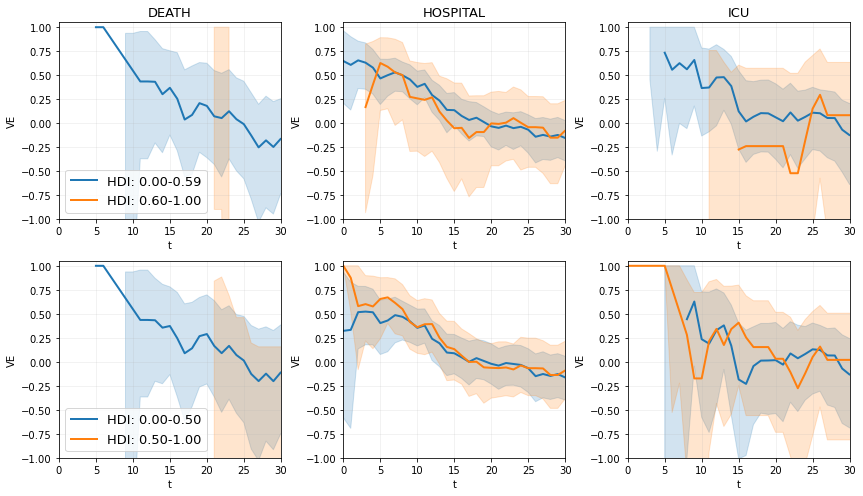

In [37]:
if config["hdi_index"]==2:
    ve_death = pd.read_excel(os.path.join(surv_path1, f"VE_0_OBITO.xlsx"), sheet_name=None)
    ve_hosp = pd.read_excel(os.path.join(surv_path1, f"VE_0_HOSPITAL.xlsx"), sheet_name=None)
    ve_icu = pd.read_excel(os.path.join(surv_path1, f"VE_0_UTI.xlsx"), sheet_name=None)

# --> 0.0-0.59 - 0.60-1.0
ve_lower_death, ve_upper_death = ve_death["D1_HDI_000_059"], ve_death["D1_HDI_060_1"]
ve_lower_hosp, ve_upper_hosp = ve_hosp["D1_HDI_000_059"], ve_hosp["D1_HDI_060_1"]
ve_lower_icu, ve_upper_icu = ve_icu["D1_HDI_000_059"], ve_icu["D1_HDI_060_1"]

fig10, AX = plt.subplots(2,3, figsize=(12,7))

sns.lineplot(x='t', y='VE', data=ve_lower_death, color="tab:blue", lw=2, ax=AX[0,0], label="HDI: 0.00-0.59")
sns.lineplot(x='t', y='VE', data=ve_upper_death, color="tab:orange", lw=2, ax=AX[0,0], label="HDI: 0.60-1.00")
AX[0,0].fill_between(ve_lower_death['t'], ve_lower_death["VE_lower_0.95"], ve_lower_death["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[0,0].fill_between(ve_upper_death['t'], ve_upper_death["VE_lower_0.95"], ve_upper_death["VE_upper_0.95"], color="tab:orange", alpha=0.2)

sns.lineplot(x='t', y='VE', data=ve_lower_hosp, color="tab:blue", lw=2, ax=AX[0,1])
sns.lineplot(x='t', y='VE', data=ve_upper_hosp, color="tab:orange", lw=2, ax=AX[0,1])
AX[0,1].fill_between(ve_lower_hosp['t'], ve_lower_hosp["VE_lower_0.95"], ve_lower_hosp["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[0,1].fill_between(ve_upper_hosp['t'], ve_upper_hosp["VE_lower_0.95"], ve_upper_hosp["VE_upper_0.95"], color="tab:orange", alpha=0.2)

sns.lineplot(x='t', y='VE', data=ve_lower_icu, color="tab:blue", lw=2, ax=AX[0,2])
sns.lineplot(x='t', y='VE', data=ve_upper_icu, color="tab:orange", lw=2, ax=AX[0,2])
AX[0,2].fill_between(ve_lower_icu['t'], ve_lower_icu["VE_lower_0.95"], ve_lower_icu["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[0,2].fill_between(ve_upper_icu['t'], ve_upper_icu["VE_lower_0.95"], ve_upper_icu["VE_upper_0.95"], color="tab:orange", alpha=0.2)

# --> 0.0-0.59 - 0.60-1.0
ve_lower_death, ve_upper_death = ve_death["D1_HDI_000_050"], ve_death["D1_HDI_050_1"]
ve_lower_hosp, ve_upper_hosp = ve_hosp["D1_HDI_000_050"], ve_hosp["D1_HDI_050_1"]
ve_lower_icu, ve_upper_icu = ve_icu["D1_HDI_000_050"], ve_icu["D1_HDI_050_1"]

sns.lineplot(x='t', y='VE', data=ve_lower_death, color="tab:blue", lw=2, ax=AX[1,0], label="HDI: 0.00-0.50")
sns.lineplot(x='t', y='VE', data=ve_upper_death, color="tab:orange", lw=2, ax=AX[1,0], label="HDI: 0.50-1.00")
AX[1,0].fill_between(ve_lower_death['t'], ve_lower_death["VE_lower_0.95"], ve_lower_death["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[1,0].fill_between(ve_upper_death['t'], ve_upper_death["VE_lower_0.95"], ve_upper_death["VE_upper_0.95"], color="tab:orange", alpha=0.2)

sns.lineplot(x='t', y='VE', data=ve_lower_hosp, color="tab:blue", lw=2, ax=AX[1,1])
sns.lineplot(x='t', y='VE', data=ve_upper_hosp, color="tab:orange", lw=2, ax=AX[1,1])
AX[1,1].fill_between(ve_lower_hosp['t'], ve_lower_hosp["VE_lower_0.95"], ve_lower_hosp["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[1,1].fill_between(ve_upper_hosp['t'], ve_upper_hosp["VE_lower_0.95"], ve_upper_hosp["VE_upper_0.95"], color="tab:orange", alpha=0.2)

sns.lineplot(x='t', y='VE', data=ve_lower_icu, color="tab:blue", lw=2, ax=AX[1,2])
sns.lineplot(x='t', y='VE', data=ve_upper_icu, color="tab:orange", lw=2, ax=AX[1,2])
AX[1,2].fill_between(ve_lower_icu['t'], ve_lower_icu["VE_lower_0.95"], ve_lower_icu["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[1,2].fill_between(ve_upper_icu['t'], ve_upper_icu["VE_lower_0.95"], ve_upper_icu["VE_upper_0.95"], color="tab:orange", alpha=0.2)

for axis in [AX[0,0], AX[0,1], AX[0,2], AX[1,0], AX[1,1], AX[1,2]]:
    axis.set_xlim([0,30])
    axis.set_ylim([-1,1.05])
    axis.grid(alpha=0.2)
AX[0,0].legend(prop={'size':13}, loc=3)
AX[1,0].legend(prop={'size':13}, loc=3)
AX[0,0].set_title("DEATH", fontsize=13)
AX[0,1].set_title("HOSPITAL", fontsize=13)
AX[0,2].set_title("ICU", fontsize=13)
plt.tight_layout()
fig10.savefig(os.path.join(fig_folder, f"VE_HDI_(31AUG2021)_D1_{figsuffix}"), dpi=150, bbox_inches="tight")
fig10.savefig(os.path.join(fig_folder, f"VE_HDI_(31AUG2021)_D1_{figsuffix_png}"), dpi=150, bbox_inches="tight")

### HDI strat - COHORT 2

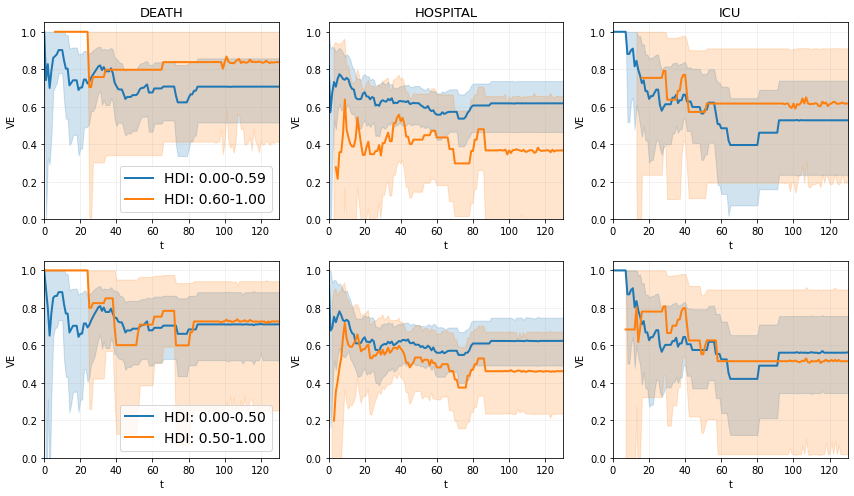

In [38]:
if config["hdi_index"]==2:
    ve_death = pd.read_excel(os.path.join(surv_path2, f"VE_0_OBITO.xlsx"), sheet_name=None)
    ve_hosp = pd.read_excel(os.path.join(surv_path2, f"VE_0_HOSPITAL.xlsx"), sheet_name=None)
    ve_icu = pd.read_excel(os.path.join(surv_path2, f"VE_0_UTI.xlsx"), sheet_name=None)

# --> 0.0-0.59 - 0.60-1.0
ve_lower_death, ve_upper_death = ve_death["D2_HDI_000_059"], ve_death["D2_HDI_060_1"]
ve_lower_hosp, ve_upper_hosp = ve_hosp["D2_HDI_000_059"], ve_hosp["D2_HDI_060_1"]
ve_lower_icu, ve_upper_icu = ve_icu["D2_HDI_000_059"], ve_icu["D2_HDI_060_1"]

fig10, AX = plt.subplots(2,3, figsize=(12,7))

sns.lineplot(x='t', y='VE', data=ve_lower_death, color="tab:blue", lw=2, ax=AX[0,0], label="HDI: 0.00-0.59")
sns.lineplot(x='t', y='VE', data=ve_upper_death, color="tab:orange", lw=2, ax=AX[0,0], label="HDI: 0.60-1.00")
AX[0,0].fill_between(ve_lower_death['t'], ve_lower_death["VE_lower_0.95"], ve_lower_death["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[0,0].fill_between(ve_upper_death['t'], ve_upper_death["VE_lower_0.95"], ve_upper_death["VE_upper_0.95"], color="tab:orange", alpha=0.2)

sns.lineplot(x='t', y='VE', data=ve_lower_hosp, color="tab:blue", lw=2, ax=AX[0,1])
sns.lineplot(x='t', y='VE', data=ve_upper_hosp, color="tab:orange", lw=2, ax=AX[0,1])
AX[0,1].fill_between(ve_lower_hosp['t'], ve_lower_hosp["VE_lower_0.95"], ve_lower_hosp["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[0,1].fill_between(ve_upper_hosp['t'], ve_upper_hosp["VE_lower_0.95"], ve_upper_hosp["VE_upper_0.95"], color="tab:orange", alpha=0.2)

sns.lineplot(x='t', y='VE', data=ve_lower_icu, color="tab:blue", lw=2, ax=AX[0,2])
sns.lineplot(x='t', y='VE', data=ve_upper_icu, color="tab:orange", lw=2, ax=AX[0,2])
AX[0,2].fill_between(ve_lower_icu['t'], ve_lower_icu["VE_lower_0.95"], ve_lower_icu["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[0,2].fill_between(ve_upper_icu['t'], ve_upper_icu["VE_lower_0.95"], ve_upper_icu["VE_upper_0.95"], color="tab:orange", alpha=0.2)

# --> 0.0-0.59 - 0.60-1.0
ve_lower_death, ve_upper_death = ve_death["D2_HDI_000_050"], ve_death["D2_HDI_050_1"]
ve_lower_hosp, ve_upper_hosp = ve_hosp["D2_HDI_000_050"], ve_hosp["D2_HDI_050_1"]
ve_lower_icu, ve_upper_icu = ve_icu["D2_HDI_000_050"], ve_icu["D2_HDI_050_1"]

sns.lineplot(x='t', y='VE', data=ve_lower_death, color="tab:blue", lw=2, ax=AX[1,0], label="HDI: 0.00-0.50")
sns.lineplot(x='t', y='VE', data=ve_upper_death, color="tab:orange", lw=2, ax=AX[1,0], label="HDI: 0.50-1.00")
AX[1,0].fill_between(ve_lower_death['t'], ve_lower_death["VE_lower_0.95"], ve_lower_death["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[1,0].fill_between(ve_upper_death['t'], ve_upper_death["VE_lower_0.95"], ve_upper_death["VE_upper_0.95"], color="tab:orange", alpha=0.2)

sns.lineplot(x='t', y='VE', data=ve_lower_hosp, color="tab:blue", lw=2, ax=AX[1,1])
sns.lineplot(x='t', y='VE', data=ve_upper_hosp, color="tab:orange", lw=2, ax=AX[1,1])
AX[1,1].fill_between(ve_lower_hosp['t'], ve_lower_hosp["VE_lower_0.95"], ve_lower_hosp["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[1,1].fill_between(ve_upper_hosp['t'], ve_upper_hosp["VE_lower_0.95"], ve_upper_hosp["VE_upper_0.95"], color="tab:orange", alpha=0.2)

sns.lineplot(x='t', y='VE', data=ve_lower_icu, color="tab:blue", lw=2, ax=AX[1,2])
sns.lineplot(x='t', y='VE', data=ve_upper_icu, color="tab:orange", lw=2, ax=AX[1,2])
AX[1,2].fill_between(ve_lower_icu['t'], ve_lower_icu["VE_lower_0.95"], ve_lower_icu["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[1,2].fill_between(ve_upper_icu['t'], ve_upper_icu["VE_lower_0.95"], ve_upper_icu["VE_upper_0.95"], color="tab:orange", alpha=0.2)

for axis in [AX[0,0], AX[0,1], AX[0,2], AX[1,0], AX[1,1], AX[1,2]]:
    axis.set_xlim([0,130])
    axis.set_ylim([0,1.05])
    axis.grid(alpha=0.2)
AX[0,0].legend(prop={'size':14}, loc=4)
AX[1,0].legend(prop={'size':14}, loc=4)
AX[0,0].set_title("DEATH", fontsize=13)
AX[0,1].set_title("HOSPITAL", fontsize=13)
AX[0,2].set_title("ICU", fontsize=13)
plt.tight_layout()
fig10.savefig(os.path.join(fig_folder, f"VE_HDI_(30JUN2021)_{figsuffix}"), dpi=150, bbox_inches="tight")
fig10.savefig(os.path.join(fig_folder, f"VE_HDI_(30JUN2021)_{figsuffix_png}"), dpi=150, bbox_inches="tight")

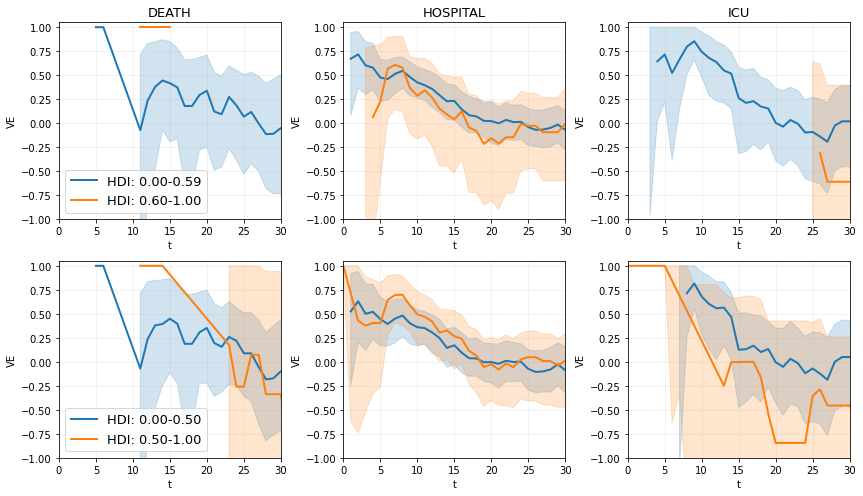

In [39]:
if config["hdi_index"]==2:
    ve_death = pd.read_excel(os.path.join(surv_path2, f"VE_0_OBITO.xlsx"), sheet_name=None)
    ve_hosp = pd.read_excel(os.path.join(surv_path2, f"VE_0_HOSPITAL.xlsx"), sheet_name=None)
    ve_icu = pd.read_excel(os.path.join(surv_path2, f"VE_0_UTI.xlsx"), sheet_name=None)

# --> 0.0-0.59 - 0.60-1.0
ve_lower_death, ve_upper_death = ve_death["D1_HDI_000_059"], ve_death["D1_HDI_060_1"]
ve_lower_hosp, ve_upper_hosp = ve_hosp["D1_HDI_000_059"], ve_hosp["D1_HDI_060_1"]
ve_lower_icu, ve_upper_icu = ve_icu["D1_HDI_000_059"], ve_icu["D1_HDI_060_1"]

fig10, AX = plt.subplots(2,3, figsize=(12,7))

sns.lineplot(x='t', y='VE', data=ve_lower_death, color="tab:blue", lw=2, ax=AX[0,0], label="HDI: 0.00-0.59")
sns.lineplot(x='t', y='VE', data=ve_upper_death, color="tab:orange", lw=2, ax=AX[0,0], label="HDI: 0.60-1.00")
AX[0,0].fill_between(ve_lower_death['t'], ve_lower_death["VE_lower_0.95"], ve_lower_death["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[0,0].fill_between(ve_upper_death['t'], ve_upper_death["VE_lower_0.95"], ve_upper_death["VE_upper_0.95"], color="tab:orange", alpha=0.2)

sns.lineplot(x='t', y='VE', data=ve_lower_hosp, color="tab:blue", lw=2, ax=AX[0,1])
sns.lineplot(x='t', y='VE', data=ve_upper_hosp, color="tab:orange", lw=2, ax=AX[0,1])
AX[0,1].fill_between(ve_lower_hosp['t'], ve_lower_hosp["VE_lower_0.95"], ve_lower_hosp["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[0,1].fill_between(ve_upper_hosp['t'], ve_upper_hosp["VE_lower_0.95"], ve_upper_hosp["VE_upper_0.95"], color="tab:orange", alpha=0.2)

sns.lineplot(x='t', y='VE', data=ve_lower_icu, color="tab:blue", lw=2, ax=AX[0,2])
sns.lineplot(x='t', y='VE', data=ve_upper_icu, color="tab:orange", lw=2, ax=AX[0,2])
AX[0,2].fill_between(ve_lower_icu['t'], ve_lower_icu["VE_lower_0.95"], ve_lower_icu["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[0,2].fill_between(ve_upper_icu['t'], ve_upper_icu["VE_lower_0.95"], ve_upper_icu["VE_upper_0.95"], color="tab:orange", alpha=0.2)

# --> 0.0-0.59 - 0.60-1.0
ve_lower_death, ve_upper_death = ve_death["D1_HDI_000_050"], ve_death["D1_HDI_050_1"]
ve_lower_hosp, ve_upper_hosp = ve_hosp["D1_HDI_000_050"], ve_hosp["D1_HDI_050_1"]
ve_lower_icu, ve_upper_icu = ve_icu["D1_HDI_000_050"], ve_icu["D1_HDI_050_1"]

sns.lineplot(x='t', y='VE', data=ve_lower_death, color="tab:blue", lw=2, ax=AX[1,0], label="HDI: 0.00-0.50")
sns.lineplot(x='t', y='VE', data=ve_upper_death, color="tab:orange", lw=2, ax=AX[1,0], label="HDI: 0.50-1.00")
AX[1,0].fill_between(ve_lower_death['t'], ve_lower_death["VE_lower_0.95"], ve_lower_death["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[1,0].fill_between(ve_upper_death['t'], ve_upper_death["VE_lower_0.95"], ve_upper_death["VE_upper_0.95"], color="tab:orange", alpha=0.2)

sns.lineplot(x='t', y='VE', data=ve_lower_hosp, color="tab:blue", lw=2, ax=AX[1,1])
sns.lineplot(x='t', y='VE', data=ve_upper_hosp, color="tab:orange", lw=2, ax=AX[1,1])
AX[1,1].fill_between(ve_lower_hosp['t'], ve_lower_hosp["VE_lower_0.95"], ve_lower_hosp["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[1,1].fill_between(ve_upper_hosp['t'], ve_upper_hosp["VE_lower_0.95"], ve_upper_hosp["VE_upper_0.95"], color="tab:orange", alpha=0.2)

sns.lineplot(x='t', y='VE', data=ve_lower_icu, color="tab:blue", lw=2, ax=AX[1,2])
sns.lineplot(x='t', y='VE', data=ve_upper_icu, color="tab:orange", lw=2, ax=AX[1,2])
AX[1,2].fill_between(ve_lower_icu['t'], ve_lower_icu["VE_lower_0.95"], ve_lower_icu["VE_upper_0.95"], color="tab:blue", alpha=0.2)
AX[1,2].fill_between(ve_upper_icu['t'], ve_upper_icu["VE_lower_0.95"], ve_upper_icu["VE_upper_0.95"], color="tab:orange", alpha=0.2)

for axis in [AX[0,0], AX[0,1], AX[0,2], AX[1,0], AX[1,1], AX[1,2]]:
    axis.set_xlim([0,30])
    axis.set_ylim([-1,1.05])
    axis.grid(alpha=0.2)
AX[0,0].legend(prop={'size':13}, loc=3)
AX[1,0].legend(prop={'size':13}, loc=3)
AX[0,0].set_title("DEATH", fontsize=13)
AX[0,1].set_title("HOSPITAL", fontsize=13)
AX[0,2].set_title("ICU", fontsize=13)
plt.tight_layout()
fig10.savefig(os.path.join(fig_folder, f"VE_HDI_(30JUN2021)_D1_{figsuffix}"), dpi=150, bbox_inches="tight")
fig10.savefig(os.path.join(fig_folder, f"VE_HDI_(30JUN2021)_D1_{figsuffix_png}"), dpi=150, bbox_inches="tight")

### Population distribution by HDI - COHORT 1

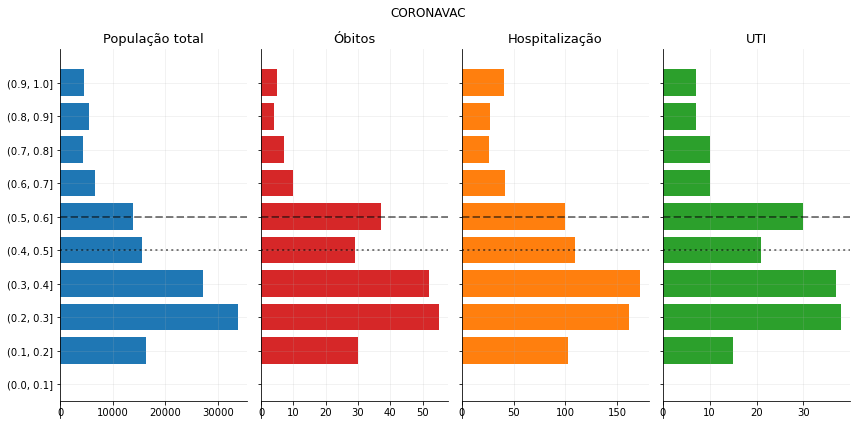

In [46]:
dose = "D2"
day = 0

current_path = os.path.join(pareamento_folder, "CORONAVAC", f"NOVO_HDI_0_21JAN2021_31AUG2021")
cpf_df = pd.read_parquet(os.path.join(current_path, f"PAREADOS_CPF_{dose}_DAY{day}_1.parquet"))
cpfs = np.unique(cpf_df["CPF CASO"].astype(str).tolist() + cpf_df["CPF CONTROLE"].astype(str).tolist()) 
    
hdi_subset = fschema_1[fschema_1["CPF"].isin(cpfs)]["IDH2010"]
hdi_subset_death = fschema_1[(fschema_1["CPF"].isin(cpfs)) & (pd.notna(fschema_1["DATA OBITO"]))]["IDH2010"]
hdi_subset_hosp = fschema_1[(fschema_1["CPF"].isin(cpfs)) & (pd.notna(fschema_1["DATA HOSPITALIZACAO"]))]["IDH2010"]
hdi_subset_icu = fschema_1[(fschema_1["CPF"].isin(cpfs)) & (pd.notna(fschema_1["DATA UTI"]))]["IDH2010"]
hdi_cut = pd.cut(hdi_subset, np.arange(0.0,1.1,0.1)).value_counts()
hdi_cut_death = pd.cut(hdi_subset_death, np.arange(0.0,1.1,0.1)).value_counts()
hdi_cut_hosp = pd.cut(hdi_subset_hosp, np.arange(0.0,1.1,0.1)).value_counts()
hdi_cut_icu = pd.cut(hdi_subset_icu, np.arange(0.0,1.1,0.1)).value_counts()
    
fig11, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(12,6))

x_geral = np.array(hdi_cut.sort_index().index.astype(str))
x_death = np.array(hdi_cut_death.sort_index().index.astype(str))
x_hosp = np.array(hdi_cut_hosp.sort_index().index.astype(str))
x_icu = np.array(hdi_cut_icu.sort_index().index.astype(str))

ax1.barh(x_geral, hdi_cut.sort_index().array,  color="tab:blue")
ax2.barh(x_death, hdi_cut_death.sort_index().array, color="tab:red")
ax3.barh(x_hosp, hdi_cut_hosp.sort_index().array, color="tab:orange")
ax4.barh(x_icu, hdi_cut_icu.sort_index().array, color="tab:green")

for axis in [ax1, ax2, ax3, ax4]:
    axis.axhline(4, 0,60000, ls=":", color="black", lw=2, alpha=0.5)
    axis.axhline(5, 0,60000, ls="--", color="black", lw=2, alpha=0.5)
    axis.grid(alpha=0.2)
    axis.set_ylim([-1,10])
    axis.spines['top'].set_color('none')
    axis.spines['right'].set_color('none')
    axis.spines['bottom'].set_position(('data',-0.5))
        #axis.spines['left'].set_position(('data',-700))
    
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])
ax1.set_title("População total", fontsize=13)
ax2.set_title("Óbitos", fontsize=13)
ax3.set_title("Hospitalização", fontsize=13)
ax4.set_title("UTI", fontsize=13)
fig11.suptitle(f"CORONAVAC")
plt.tight_layout()
fig11.savefig(os.path.join("..", "output", "figs", "Fig2022_MarchRuns", f"{dose}_{day}_NOHDI_POP_21JAN2021_31AUG2021.png"), dpi=150, bbox_inches="tight")
#fig11.savefig(os.path.join(fig_folder, f"HDI_POP_(31AUG2021)_{figsuffix}"), dpi=150, bbox_inches="tight")
    #fig11.savefig(os.path.join(fig_folder, f"HDI_POP_(31AUG2021)_{figsuffix_png}"), dpi=150, bbox_inches="tight")

### Population distribution by HDI - COHORT 2

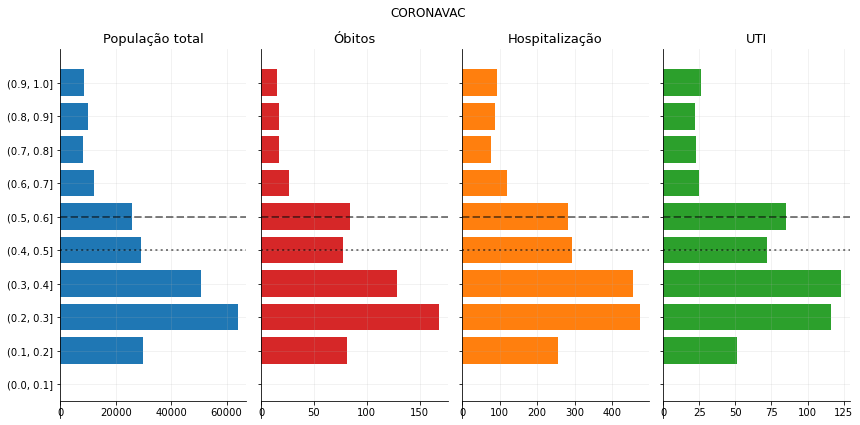

In [48]:
if config["hdi_index"]>-2:
    current_path = os.path.join(pareamento_folder, config['vaccine'], f"{config['prefix test']}_HDI_{config['hdi_index']}_21JAN2021_30JUN2021")
    cpf_df = pd.read_parquet(os.path.join(current_path, f"PAREADOS_CPF_{config['seed']}.parquet"))
    cpfs = np.unique(cpf_df["CPF CASO"].astype(str).tolist() + cpf_df["CPF CONTROLE"].astype(str).tolist()) 
    
    hdi_subset = fschema_1[fschema_1["CPF"].isin(cpfs)]["IDH2010"]
    hdi_subset_death = fschema_1[(fschema_1["CPF"].isin(cpfs)) & (pd.notna(fschema_1["DATA OBITO"]))]["IDH2010"]
    hdi_subset_hosp = fschema_1[(fschema_1["CPF"].isin(cpfs)) & (pd.notna(fschema_1["DATA HOSPITALIZACAO"]))]["IDH2010"]
    hdi_subset_icu = fschema_1[(fschema_1["CPF"].isin(cpfs)) & (pd.notna(fschema_1["DATA UTI"]))]["IDH2010"]
    hdi_cut = pd.cut(hdi_subset, np.arange(0.0,1.1,0.1)).value_counts()
    hdi_cut_death = pd.cut(hdi_subset_death, np.arange(0.0,1.1,0.1)).value_counts()
    hdi_cut_hosp = pd.cut(hdi_subset_hosp, np.arange(0.0,1.1,0.1)).value_counts()
    hdi_cut_icu = pd.cut(hdi_subset_icu, np.arange(0.0,1.1,0.1)).value_counts()
    
    fig11, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(12,6))

    x_geral = np.array(hdi_cut.sort_index().index.astype(str))
    x_death = np.array(hdi_cut_death.sort_index().index.astype(str))
    x_hosp = np.array(hdi_cut_hosp.sort_index().index.astype(str))
    x_icu = np.array(hdi_cut_icu.sort_index().index.astype(str))

    ax1.barh(x_geral, hdi_cut.sort_index().array,  color="tab:blue")
    ax2.barh(x_death, hdi_cut_death.sort_index().array, color="tab:red")
    ax3.barh(x_hosp, hdi_cut_hosp.sort_index().array, color="tab:orange")
    ax4.barh(x_icu, hdi_cut_icu.sort_index().array, color="tab:green")

    for axis in [ax1, ax2, ax3, ax4]:
        axis.axhline(4, 0,60000, ls=":", color="black", lw=2, alpha=0.5)
        axis.axhline(5, 0,60000, ls="--", color="black", lw=2, alpha=0.5)
        axis.grid(alpha=0.2)
        axis.set_ylim([-1,10])
        axis.spines['top'].set_color('none')
        axis.spines['right'].set_color('none')
        axis.spines['bottom'].set_position(('data',-0.5))
        #axis.spines['left'].set_position(('data',-700))
    
    ax2.set_yticklabels([])
    ax3.set_yticklabels([])
    ax4.set_yticklabels([])
    ax1.set_title("População total", fontsize=13)
    ax2.set_title("Óbitos", fontsize=13)
    ax3.set_title("Hospitalização", fontsize=13)
    ax4.set_title("UTI", fontsize=13)
    fig11.suptitle(f"{config['vaccine']}")
    plt.tight_layout()
    fig11.savefig(os.path.join(fig_folder, f"HDI_POP_(30JUN2021)_{figsuffix}"), dpi=150, bbox_inches="tight")
    fig11.savefig(os.path.join(fig_folder, f"HDI_POP_(30JUN2021)_{figsuffix_png}"), dpi=150, bbox_inches="tight")

In [11]:
# Rebeca bairro faixas
def fx_etaria(x):
    if x>=0 and x<=9:
        return "0 A 9 ANOS"
    elif x>=10 and x<=19:
        return "10 A 19 ANOS"
    elif x>=20 and x<=59:
        return "20 A 59 ANOS"
    else:
        return "60+ ANOS"
fschema_1["FX ETARIA"] = fschema_1["IDADE"].apply(fx_etaria)

d1 = fschema_1[(fschema_1["STATUS VACINACAO"].str.contains("(D1)", regex=False)) | (fschema_1["STATUS VACINACAO"].str.contains("(D4)", regex=False))]
d2 = fschema_1[fschema_1["STATUS VACINACAO"].str.contains("(D1)(D2)", regex=False)]
d3 = fschema_1[fschema_1["STATUS VACINACAO"].str.contains("(D1)(D2)(D3)", regex=False)]

strat1 = pd.DataFrame(d1.groupby("BAIRRO")["FX ETARIA"].value_counts()).rename({"FX ETARIA": "# FX ETARIA"}, axis=1).reset_index()
strat2 = pd.DataFrame(d2.groupby("BAIRRO")["FX ETARIA"].value_counts()).rename({"FX ETARIA": "# FX ETARIA"}, axis=1).reset_index()
strat3 = pd.DataFrame(d3.groupby("BAIRRO")["FX ETARIA"].value_counts()).rename({"FX ETARIA": "# FX ETARIA"}, axis=1).reset_index()

strat1 = strat1.pivot(index="BAIRRO", columns="FX ETARIA", values="# FX ETARIA").fillna(0)
strat2 = strat2.pivot(index="BAIRRO", columns="FX ETARIA", values="# FX ETARIA").fillna(0)
strat3 = strat3.pivot(index="BAIRRO", columns="FX ETARIA", values="# FX ETARIA").fillna(0)
strat1["TOTAL"] = strat1.apply(sum, axis=1)
strat2["TOTAL"] = strat2.apply(sum, axis=1)
strat3["TOTAL"] = strat3.apply(sum, axis=1)

strat1_prop = (strat1/fschema_1.shape[0]).add_suffix("(% VACINE JÁ)")
strat2_prop = (strat1/fschema_1.shape[0]).add_suffix("(% VACINE JÁ)")
strat3_prop = (strat1/fschema_1.shape[0]).add_suffix("(% VACINE JÁ)")

strat1 = pd.concat([strat1, strat1_prop], axis=1) 
strat2 = pd.concat([strat2, strat2_prop], axis=1) 
strat3 = pd.concat([strat3, strat3_prop], axis=1) 

strat1["TOTAL (% VACINE JÁ)"] = strat1["TOTAL"]/fschema_1.shape[0]
strat2["TOTAL (% VACINE JÁ)"] = strat2["TOTAL"]/fschema_1.shape[0]
strat3["TOTAL (% VACINE JÁ)"] = strat3["TOTAL"]/fschema_1.shape[0]

with pd.ExcelWriter(os.path.join(base_path, "data", "REBECA_ORDENS", "bairro_fx_vacinados_vacineja.xlsx")) as writer:
    strat1.to_excel(writer, sheet_name="D1")
    strat2.to_excel(writer, sheet_name="D1+D2")
    strat3.to_excel(writer, sheet_name="D1+D2+D3")

In [12]:
strat1

FX ETARIA        0 A 9 ANOS  10 A 19 ANOS  20 A 59 ANOS  60+ ANOS    TOTAL  \
BAIRRO                                                                       
AEROLANDIA              0.0        1339.0        8111.0    2133.0  11583.0   
AEROPORTO               0.0         345.0        2194.0     396.0   2935.0   
ALDEOTA                 0.0        2989.0       22438.0    9637.0  35064.0   
ALTO DA BALANCA         1.0         657.0        4097.0    1375.0   6130.0   
ALVARO WEYNE            2.0        2001.0       12103.0    3512.0  17618.0   
...                     ...           ...           ...       ...      ...   
VILA ELLERY             0.0         937.0        5573.0    1664.0   8174.0   
VILA PERY               0.0        1620.0       10344.0    2765.0  14729.0   
VILA UNIAO              0.0        1680.0        9947.0    2714.0  14341.0   
VILA VELHA              3.0        4343.0       23173.0    5529.0  33048.0   
VINCENTE PINZON         3.0        3502.0       17270.0    3511.0  24286.0   

FX ETARIA        0 A 9 ANOS(% VACINE JÁ)  10 A 19 ANOS(% VACINE JÁ)  \
BAIRRO                                                                
AEROLANDIA                  0.000000e+00                   0.000588   
AEROPORTO                   0.000000e+00                   0.000152   
ALDEOTA                     0.000000e+00                   0.001314   
ALTO DA BALANCA             4.395007e-07                   0.000289   
ALVARO WEYNE                8.790015e-07                   0.000879   
...                                  ...                        ...   
VILA ELLERY                 0.000000e+00                   0.000412   
VILA PERY                   0.000000e+00                   0.000712   
VILA UNIAO                  0.000000e+00                   0.000738   
VILA VELHA                  1.318502e-06                   0.001909   
VINCENTE PINZON             1.318502e-06                   0.001539   

FX ETARIA        20 A 59 ANOS(% VACINE JÁ)  60+ ANOS(% VACINE JÁ)  \
BAIRRO                                                              
AEROLANDIA                        0.003565               0.000937   
AEROPORTO                         0.000964               0.000174   
ALDEOTA                           0.009862               0.004235   
ALTO DA BALANCA                   0.001801               0.000604   
ALVARO WEYNE                      0.005319               0.001544   
...                                    ...                    ...   
VILA ELLERY                       0.002449               0.000731   
VILA PERY                         0.004546               0.001215   
VILA UNIAO                        0.004372               0.001193   
VILA VELHA                        0.010185               0.002430   
VINCENTE PINZON                   0.007590               0.001543   

FX ETARIA        TOTAL(% VACINE JÁ)  TOTAL (% VACINE JÁ)  
BAIRRO                                                    
AEROLANDIA                 0.005091             0.005091  
AEROPORTO                  0.001290             0.001290  
ALDEOTA                    0.015411             0.015411  
ALTO DA BALANCA            0.002694             0.002694  
ALVARO WEYNE               0.007743             0.007743  
...                             ...                  ...  
VILA ELLERY                0.003592             0.003592  
VILA PERY                  0.006473             0.006473  
VILA UNIAO                 0.006303             0.006303  
VILA VELHA                 0.014525             0.014525  
VINCENTE PINZON            0.010674             0.010674  

[122 rows x 11 columns]

In [29]:
x_F = np.array([-600, -623, -653, -650, -670, -578, -541, -411, -322, -230])
x_M = np.array([600, 623, 653, 650, 670, 578, 541, 360, 312, 170])
y_age = np.arange(0,10,1)
y_age_str = ["0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90-99"]
age_df = pd.DataFrame({'age': y_age, 'x_F': x_F, 'x_M': x_M})

In [3]:
fig

age  x_F  x_M
0    0 -600  600
1    1 -623  623
2    2 -653  653
3    3 -650  650
4    4 -670  670
5    5 -578  578
6    6 -541  541
7    7 -411  360
8    8 -322  312
9    9 -230  170

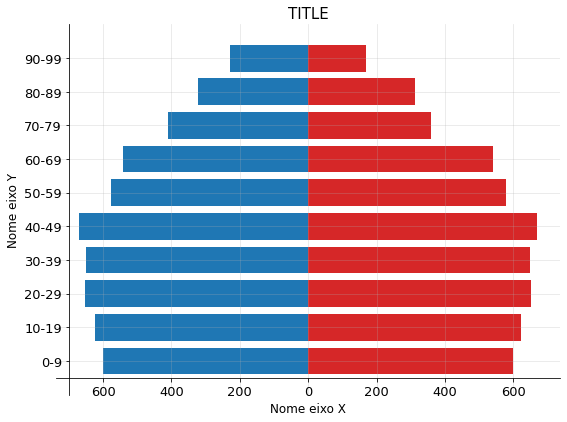

In [48]:
fig, ax = plt.subplots(1, figsize=(8,6))

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position(('data',-0.5))
ax.spines['left'].set_position(('data',-700))
ax.set_ylim([-1,10])
ax.grid(alpha=0.3)
ax.tick_params(labelsize=13)
ax.set_title("TITLE", fontsize=15)

ax.barh(y_age_str, x_F, color="tab:blue")
ax.barh(y_age_str, x_M, color="tab:red")
ax.set_ylabel("Nome eixo Y", fontsize=12)
ax.set_xlabel("Nome eixo X", fontsize=12)

ax.set_xticklabels(['', 600, 400, 200, 0, 200, 400, 600])
plt.tight_layout()

In [12]:
def plot_res(prefix, hdi, event, dose, dates="21JAN2021_31AUG2021", fix_km_axis=None):
    '''
    
    '''
    hash_hdi = {
        2: "WITH HDI", 0: "WITHOUT HDI",
    }
    
    res_folder = os.path.join(pareamento_folder, "CORONAVAC", f"{prefix}_HDI_{hdi}_{dates}")
    surv_folder = os.path.join(res_folder, "SURVIVAL", "SEED1")
    df_km0 = pd.read_excel(os.path.join(surv_folder, f"KM_events_{dose}_{event}_DAY0.xlsx"), sheet_name="KM_DOSE")
    df_ve0 = pd.read_excel(os.path.join(surv_folder, f"VE_{dose}_{event}_DAY0.xlsx"), sheet_name="DOSE")
    df_km7 = pd.read_excel(os.path.join(surv_folder, f"KM_events_{dose}_{event}_DAY7.xlsx"), sheet_name="KM_DOSE")
    df_ve7 = pd.read_excel(os.path.join(surv_folder, f"VE_{dose}_{event}_DAY7.xlsx"), sheet_name="DOSE")
    df_km14 = pd.read_excel(os.path.join(surv_folder, f"KM_events_{dose}_{event}_DAY14.xlsx"), sheet_name="KM_DOSE")
    df_ve14 = pd.read_excel(os.path.join(surv_folder, f"VE_{dose}_{event}_DAY14.xlsx"), sheet_name="DOSE")
    
    fig, AX = plt.subplots(2,3, figsize=(13,8)) 
    sns.lineplot(x='t', y='KM(caso)', data=df_km0, ax=AX[0,0], color="tab:blue")
    sns.lineplot(x='t', y='KM(controle)', data=df_km0, ax=AX[0,0], color="tab:orange")
    AX[0,0].fill_between(df_km0['t'], df_km0['KM_lower_0.95(caso)'], df_km0['KM_upper_0.95(caso)'], color="tab:blue", alpha=0.2)
    AX[0,0].fill_between(df_km0['t'], df_km0['KM_lower_0.95(controle)'], df_km0['KM_upper_0.95(controle)'], color="tab:orange", alpha=0.2)
    sns.lineplot(x='t', y='VE_original', data=df_ve0, ax=AX[1,0], color="tab:blue", label="VE")
    AX[1,0].fill_between(df_ve0['t'], df_ve0["VE_lower_0.95"], df_ve0["VE_upper_0.95"], color="tab:blue", alpha=0.2)
    # --------
    sns.lineplot(x='t', y='KM(caso)', data=df_km7, ax=AX[0,1], color="tab:blue")
    sns.lineplot(x='t', y='KM(controle)', data=df_km7, ax=AX[0,1], color="tab:orange")
    AX[0,1].fill_between(df_km7['t'], df_km7['KM_lower_0.95(caso)'], df_km7['KM_upper_0.95(caso)'], color="tab:blue", alpha=0.2)
    AX[0,1].fill_between(df_km7['t'], df_km7['KM_lower_0.95(controle)'], df_km7['KM_upper_0.95(controle)'], color="tab:orange", alpha=0.2)
    sns.lineplot(x='t', y='VE_original', data=df_ve7, ax=AX[1,1], color="tab:blue")
    AX[1,1].fill_between(df_ve7['t'], df_ve7["VE_lower_0.95"], df_ve7["VE_upper_0.95"], color="tab:blue", alpha=0.2)
    
    # --------
    sns.lineplot(x='t', y='KM(caso)', data=df_km14, ax=AX[0,2], color="tab:blue", label="Vaccinated")
    sns.lineplot(x='t', y='KM(controle)', data=df_km14, ax=AX[0,2], color="tab:orange", label="Unvaccinated")
    AX[0,2].fill_between(df_km14['t'], df_km14['KM_lower_0.95(caso)'], df_km14['KM_upper_0.95(caso)'], color="tab:blue", alpha=0.2)
    AX[0,2].fill_between(df_km14['t'], df_km14['KM_lower_0.95(controle)'], df_km14['KM_upper_0.95(controle)'], color="tab:orange", alpha=0.2)
    sns.lineplot(x='t', y='VE_original', data=df_ve14, ax=AX[1,2], color="tab:blue")
    AX[1,2].fill_between(df_ve14['t'], df_ve14["VE_lower_0.95"], df_ve14["VE_upper_0.95"], color="tab:blue", alpha=0.2)
    
    for axis in [AX[0,0], AX[1,0], AX[0,1], AX[1,1], AX[0,2], AX[1,2]]:
        axis.grid(alpha=0.2)
        axis.tick_params(direction='in')
    for j in [0,1,2]:
        AX[1,j].set_ylim([0,1])
        AX[1,j].set_xlim([0,200])
        AX[0,j].set_xlim([0,200])
        AX[0,j].set_ylabel("Kaplan-Meier Risk")
        AX[1,j].set_ylabel("1 - Risk Ratio")
    AX[0,0].set_title("+0 days", fontsize=14)
    AX[0,1].set_title("+7 days", fontsize=14)
    AX[0,2].set_title("+14 days", fontsize=14)
    AX[0,2].legend(loc=2, prop={'size':13})
    if fix_km_axis is not None:
        for j in range(3):
            AX[0,j].set_ylim(fix_km_axis)
    
    title = f"{dose} - {event} - {hash_hdi[hdi]}"
    fig.suptitle(title, fontsize=15)
    plt.tight_layout()
    return fig, AX

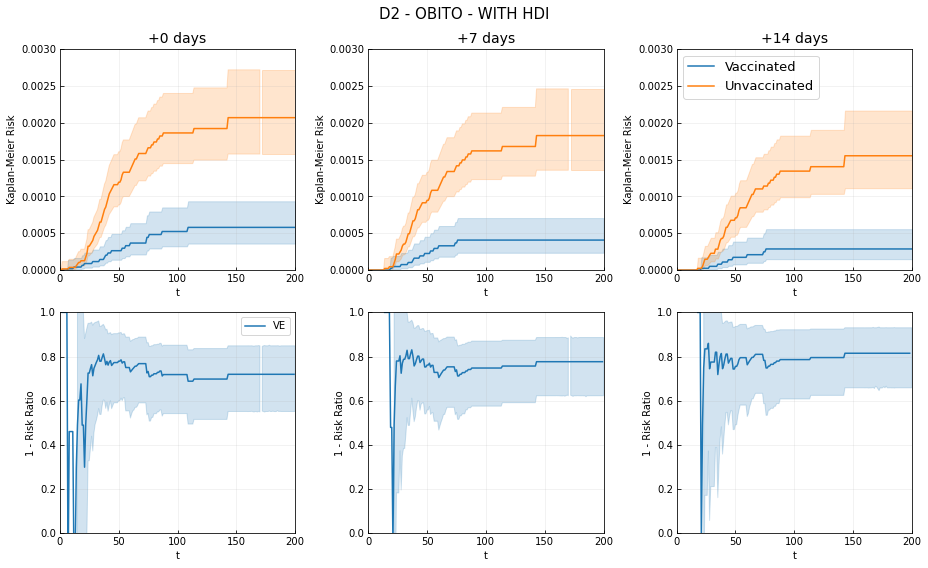

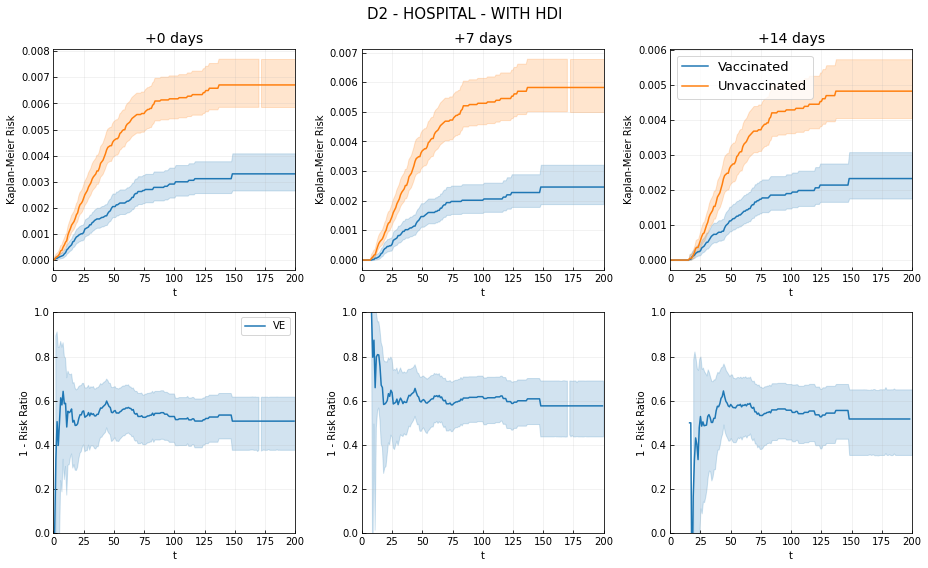

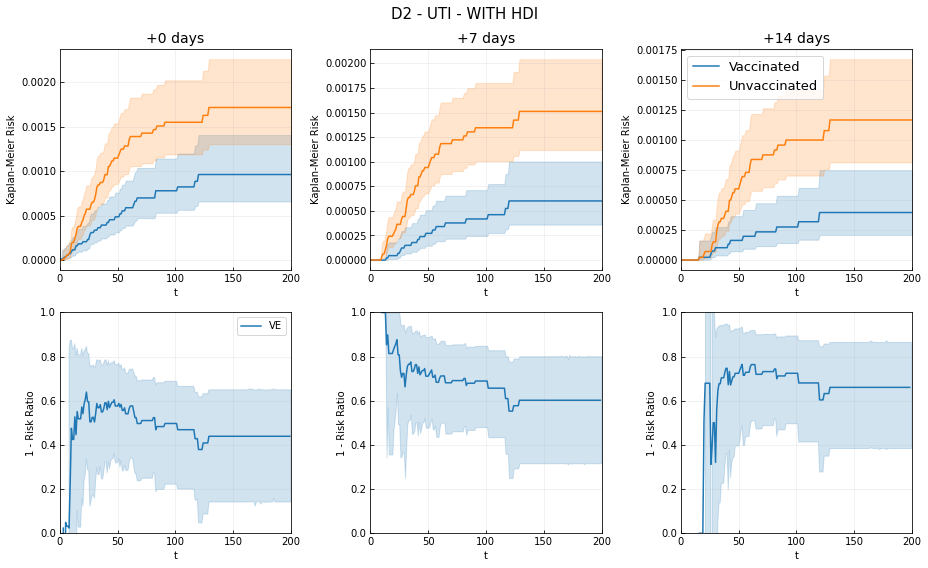

In [13]:
#fig, ax = plot_res(res_folder, "NOVO", 0, "UTI", "D2")
#fig.savefig(os.path.join("..", "output", "figs", "Fig2022_MarchRuns", "D2_UTI_NO_HDI_21JAN2021_31AUG2021.png"))

for j in ["OBITO", "HOSPITAL", "UTI"]:
    if j=="OBITO":
        fig, ax = plot_res("NOVO", 2, j, "D2", fix_km_axis=[0.0, 0.0030])
    else:
        fig, ax = plot_res("NOVO", 2, j, "D2")
    #fig.savefig(os.path.join("..", "output", "figs", "Fig2022_MarchRuns", f"D2_{j}_HDI_21JAN2021_31AUG2021.png"))

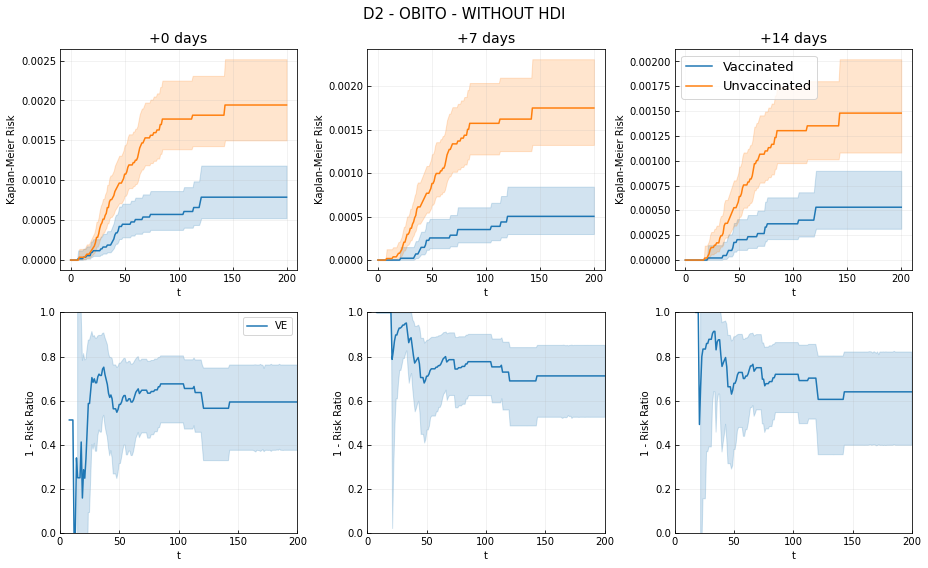

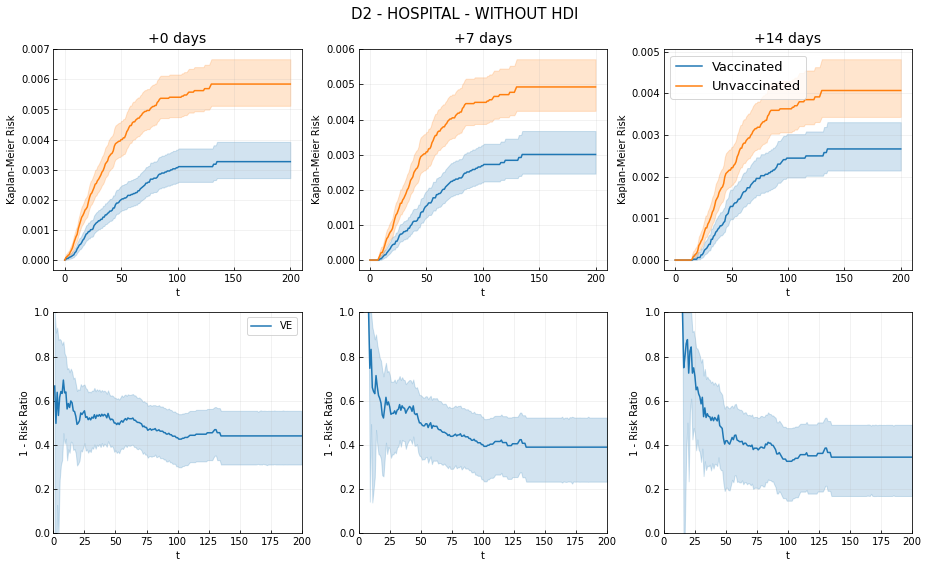

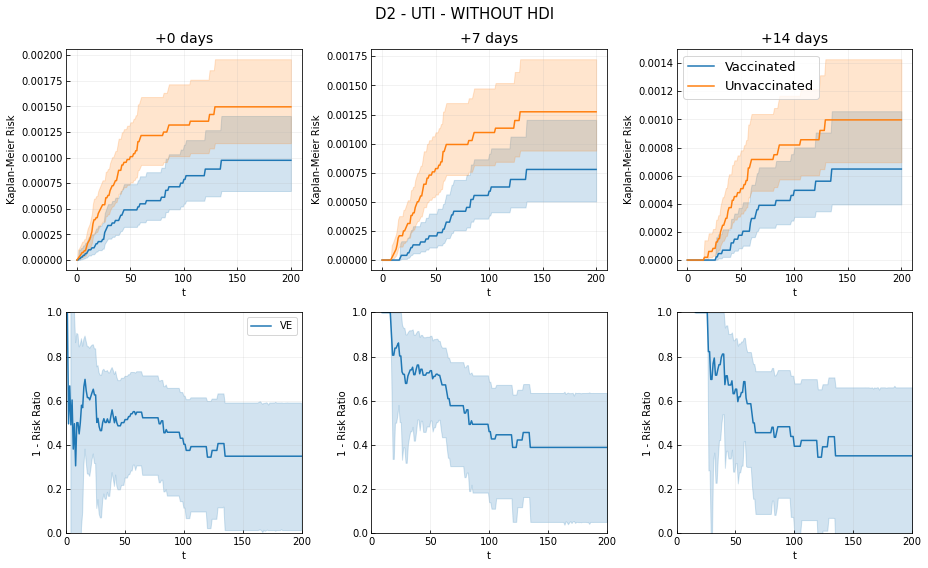

In [9]:
for j in ["OBITO", "HOSPITAL", "UTI"]:
    fig, ax = plot_res("NOVO", 0, j, "D2")

### Sex

In [10]:
def plot_res_sex(prefix, hdi, event, dose, sex="MALE", dates="21JAN2021_31AUG2021"):
    '''
    
    '''
    hash_hdi = {
        2: "WITH HDI", 0: "WITHOUT HDI",
    }
    res_folder = os.path.join(pareamento_folder, "CORONAVAC", f"{prefix}_HDI_{hdi}_{dates}")
    surv_folder = os.path.join(res_folder, "SURVIVAL", "SEED1")
    df_km0 = pd.read_excel(os.path.join(surv_folder, f"KM_events_{dose}_{event}_DAY0.xlsx"), sheet_name=f"KM_{sex}")
    df_ve0 = pd.read_excel(os.path.join(surv_folder, f"VE_{dose}_{event}_DAY0.xlsx"), sheet_name=f"{sex}")
    df_km7 = pd.read_excel(os.path.join(surv_folder, f"KM_events_{dose}_{event}_DAY7.xlsx"), sheet_name=f"KM_{sex}")
    df_ve7 = pd.read_excel(os.path.join(surv_folder, f"VE_{dose}_{event}_DAY7.xlsx"), sheet_name=f"{sex}")
    df_km14 = pd.read_excel(os.path.join(surv_folder, f"KM_events_{dose}_{event}_DAY14.xlsx"), sheet_name=f"KM_{sex}")
    df_ve14 = pd.read_excel(os.path.join(surv_folder, f"VE_{dose}_{event}_DAY14.xlsx"), sheet_name=f"{sex}")
    
    fig, AX = plt.subplots(2,3, figsize=(13,8)) 
    sns.lineplot(x='t', y='KM(caso)', data=df_km0, ax=AX[0,0], color="tab:blue")
    sns.lineplot(x='t', y='KM(controle)', data=df_km0, ax=AX[0,0], color="tab:orange")
    AX[0,0].fill_between(df_km0['t'], df_km0['KM_lower_0.95(caso)'], df_km0['KM_upper_0.95(caso)'], color="tab:blue", alpha=0.2)
    AX[0,0].fill_between(df_km0['t'], df_km0['KM_lower_0.95(controle)'], df_km0['KM_upper_0.95(controle)'], color="tab:orange", alpha=0.2)
    sns.lineplot(x='t', y='VE_original', data=df_ve0, ax=AX[1,0], color="tab:blue", label="VE")
    AX[1,0].fill_between(df_ve0['t'], df_ve0["VE_lower_0.95"], df_ve0["VE_upper_0.95"], color="tab:blue", alpha=0.2)
    # --------
    sns.lineplot(x='t', y='KM(caso)', data=df_km7, ax=AX[0,1], color="tab:blue")
    sns.lineplot(x='t', y='KM(controle)', data=df_km7, ax=AX[0,1], color="tab:orange")
    AX[0,1].fill_between(df_km7['t'], df_km7['KM_lower_0.95(caso)'], df_km7['KM_upper_0.95(caso)'], color="tab:blue", alpha=0.2)
    AX[0,1].fill_between(df_km7['t'], df_km7['KM_lower_0.95(controle)'], df_km7['KM_upper_0.95(controle)'], color="tab:orange", alpha=0.2)
    sns.lineplot(x='t', y='VE_original', data=df_ve7, ax=AX[1,1], color="tab:blue")
    AX[1,1].fill_between(df_ve7['t'], df_ve7["VE_lower_0.95"], df_ve7["VE_upper_0.95"], color="tab:blue", alpha=0.2)
    
    # --------
    sns.lineplot(x='t', y='KM(caso)', data=df_km14, ax=AX[0,2], color="tab:blue", label="Vaccinated")
    sns.lineplot(x='t', y='KM(controle)', data=df_km14, ax=AX[0,2], color="tab:orange", label="Unvaccinated")
    AX[0,2].fill_between(df_km14['t'], df_km14['KM_lower_0.95(caso)'], df_km14['KM_upper_0.95(caso)'], color="tab:blue", alpha=0.2)
    AX[0,2].fill_between(df_km14['t'], df_km14['KM_lower_0.95(controle)'], df_km14['KM_upper_0.95(controle)'], color="tab:orange", alpha=0.2)
    sns.lineplot(x='t', y='VE_original', data=df_ve14, ax=AX[1,2], color="tab:blue")
    AX[1,2].fill_between(df_ve14['t'], df_ve14["VE_lower_0.95"], df_ve14["VE_upper_0.95"], color="tab:blue", alpha=0.2)
    
    for axis in [AX[0,0], AX[1,0], AX[0,1], AX[1,1], AX[0,2], AX[1,2]]:
        axis.grid(alpha=0.2)
        axis.tick_params(direction='in')
    for j in [0,1,2]:
        AX[1,j].set_ylim([0,1])
        AX[0,j].set_ylabel("Kaplan-Meier Risk")
        AX[1,j].set_ylabel("1 - Risk Ratio")
    AX[0,0].set_title("+0 days", fontsize=14)
    AX[0,1].set_title("+7 days", fontsize=14)
    AX[0,2].set_title("+14 days", fontsize=14)
    AX[0,2].legend(loc=2, prop={'size':13})
    title = f"{dose} - {event} - {sex} - {hash_hdi[hdi]}"
    fig.suptitle(title, fontsize=15)
    #fig.suptitle(f"{dose} - {event} - {sex}", fontsize=15)
    plt.tight_layout()
    return fig, AX

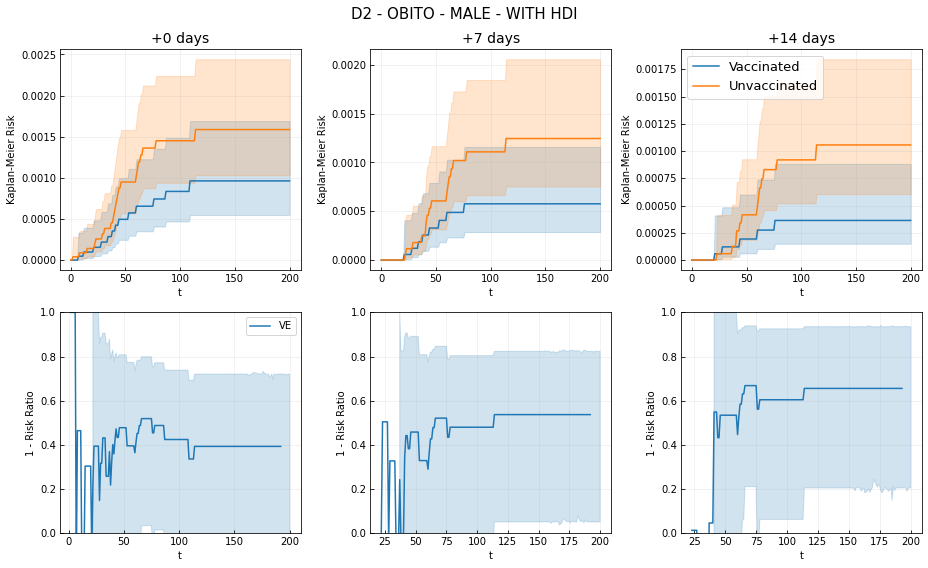

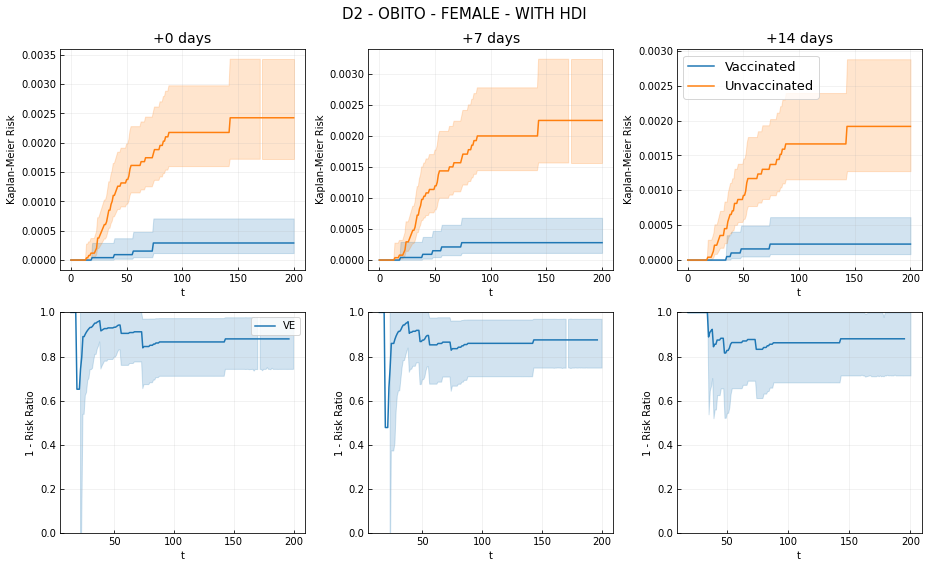

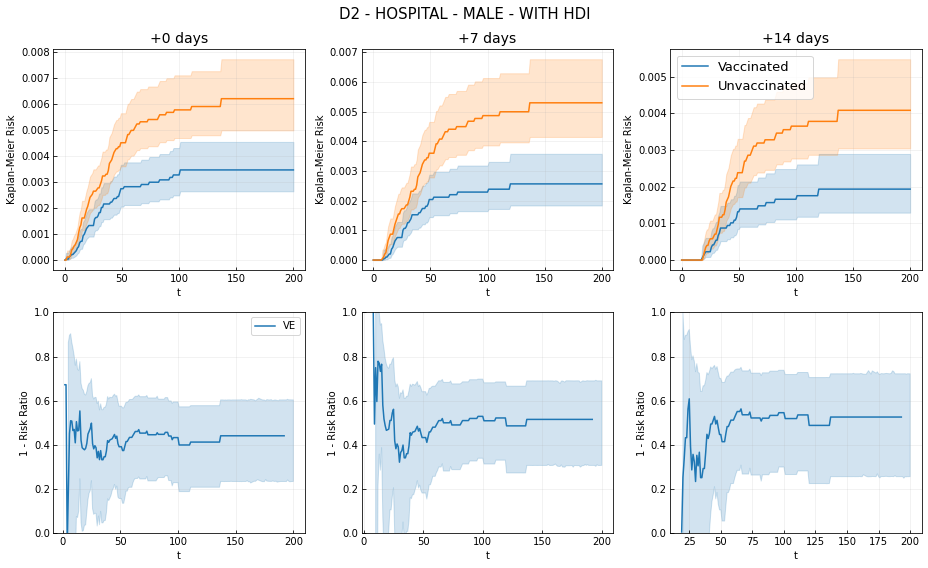

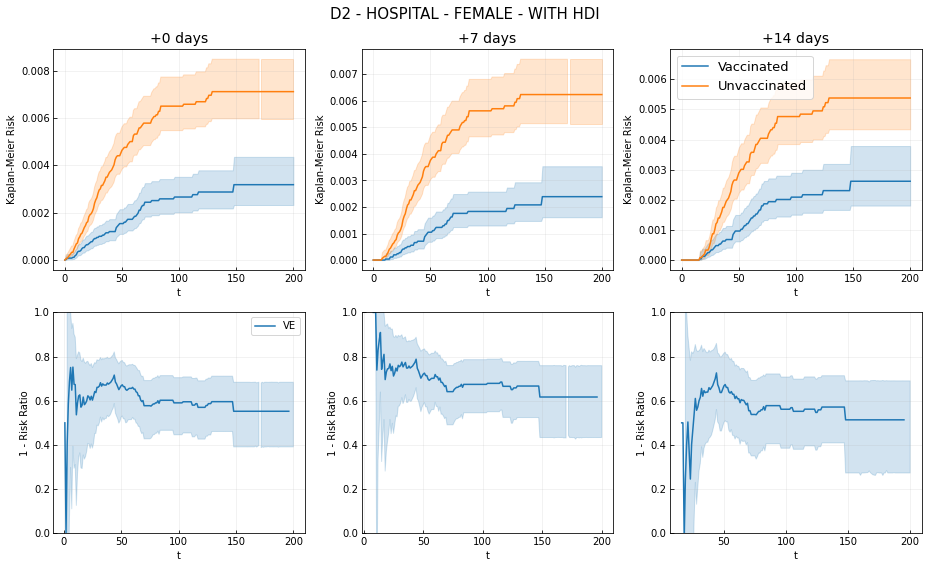

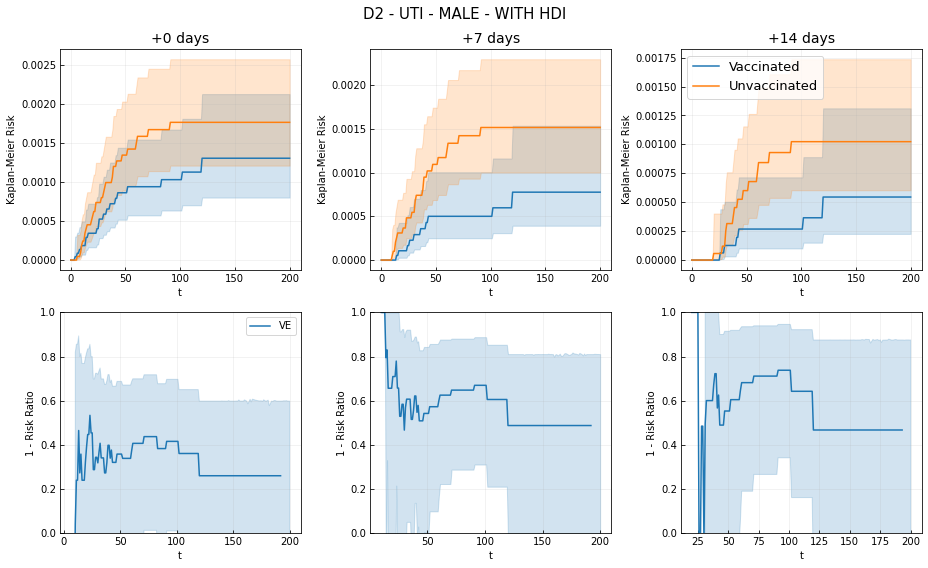

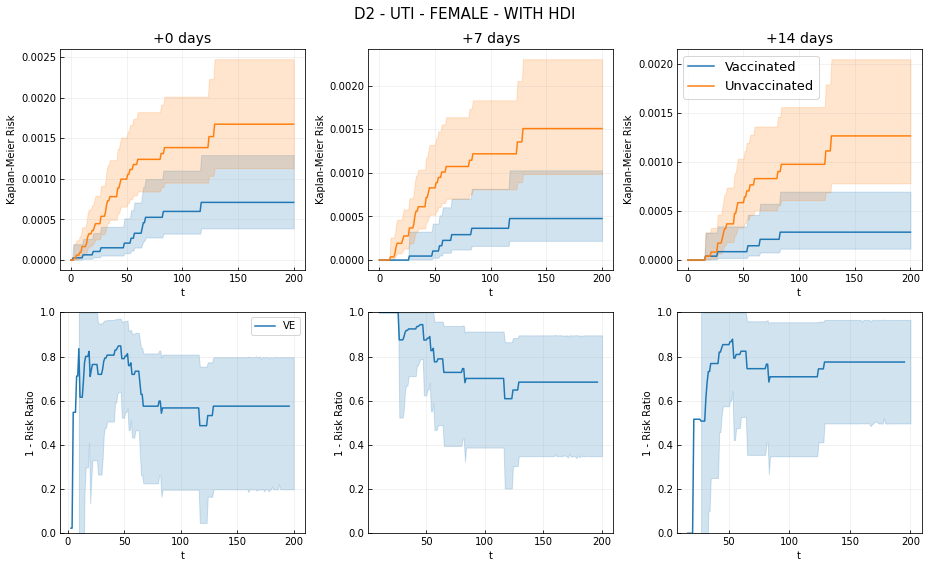

In [11]:
for j in ["OBITO", "HOSPITAL", "UTI"]:
    fig, ax = plot_res_sex("NOVO", 2, j, "D2", sex="MALE")
    fig1, ax1 = plot_res_sex("NOVO", 2, j, "D2", sex="FEMALE")
    #fig.savefig(os.path.join("..", "output", "figs", "Fig2022_MarchRuns", f"D2_{j}_HDI_MALE_21JAN2021_31AUG2021.png"))
    #fig1.savefig(os.path.join("..", "output", "figs", "Fig2022_MarchRuns", f"D2_{j}_HDI_FEMALE_21JAN2021_31AUG2021.png"))

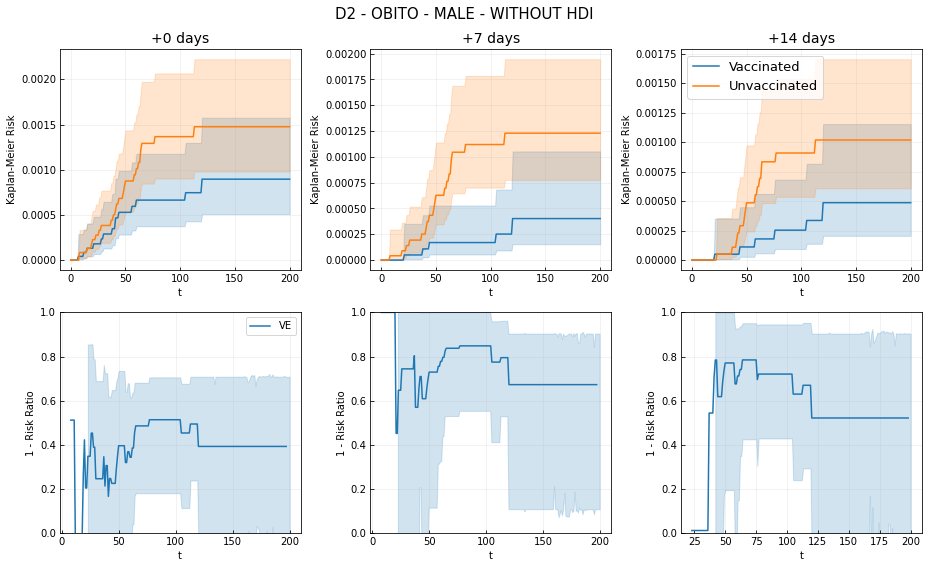

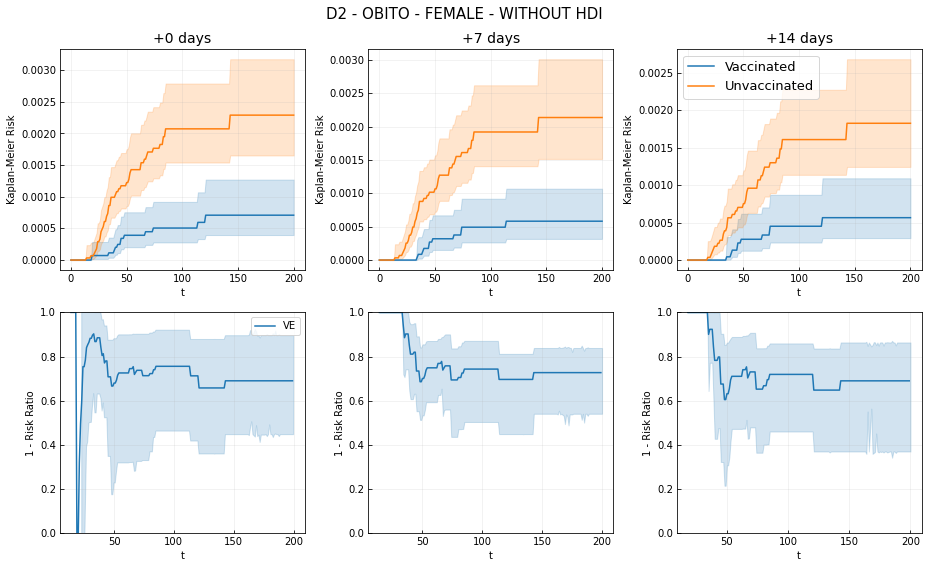

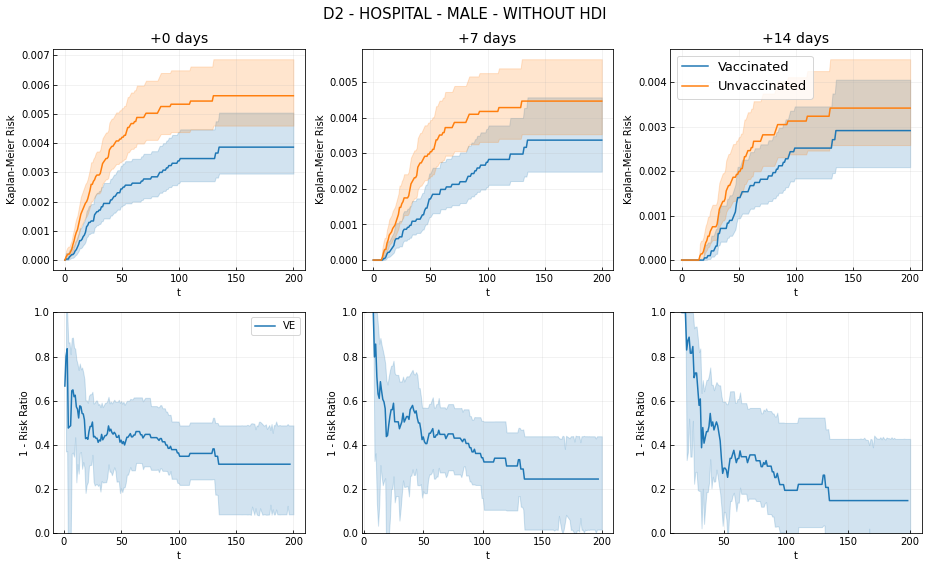

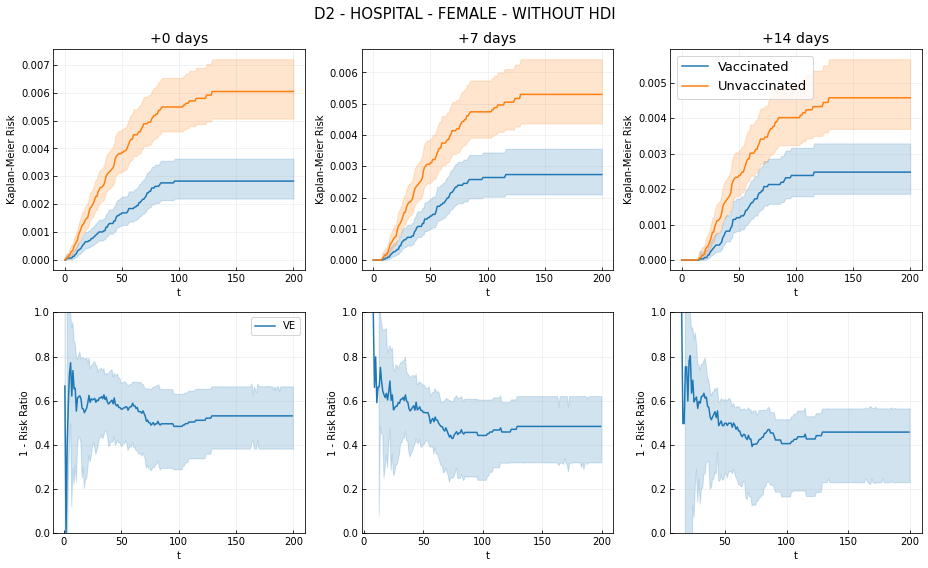

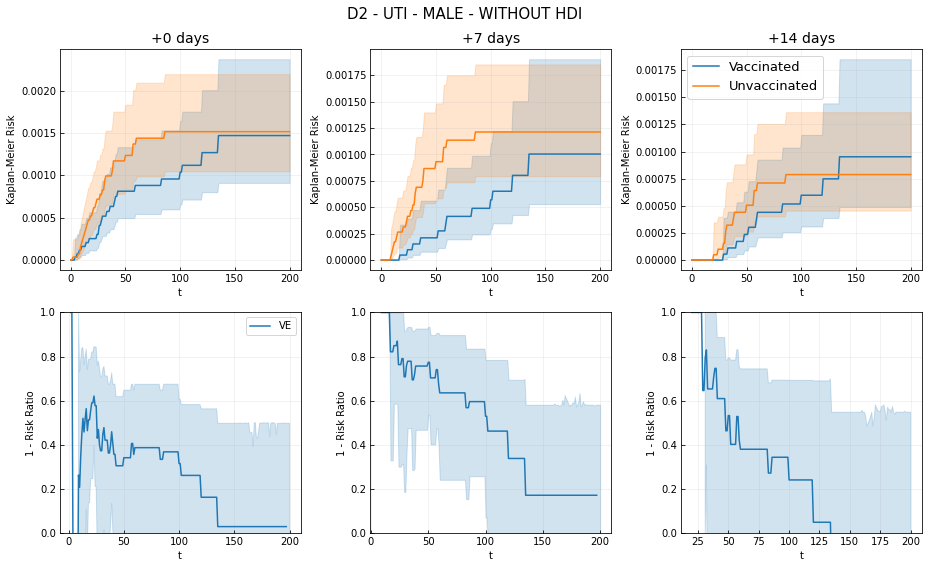

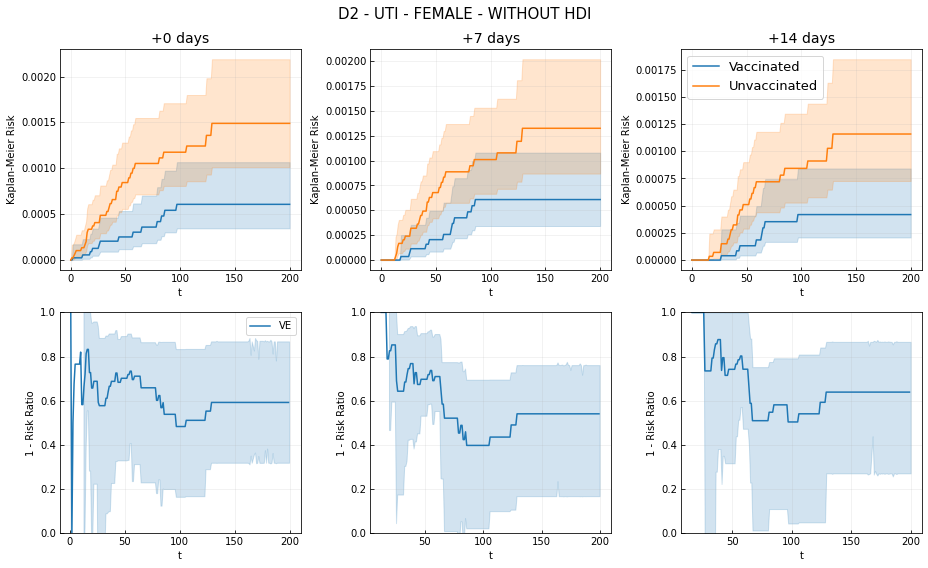

In [34]:
for j in ["OBITO", "HOSPITAL", "UTI"]:
    fig, ax = plot_res_sex("NOVO", 0, j, "D2", sex="MALE")
    fig1, ax1 = plot_res_sex("NOVO", 0, j, "D2", sex="FEMALE")
    fig.savefig(os.path.join("..", "output", "figs", "Fig2022_MarchRuns", f"D2_{j}_NO_HDI_MALE_21JAN2021_31AUG2021.png"))
    fig1.savefig(os.path.join("..", "output", "figs", "Fig2022_MarchRuns", f"D2_{j}_NO_HDI_FEMALE_21JAN2021_31AUG2021.png"))

### HDI

In [14]:
def plot_res_hdi(prefix, hdi, event, dose, hdi_str, dates="21JAN2021_31AUG2021"):
    '''
    
    '''
    res_folder = os.path.join(pareamento_folder, "CORONAVAC", f"{prefix}_HDI_{hdi}_{dates}")
    surv_folder = os.path.join(res_folder, "SURVIVAL", "SEED1")
    df_km0 = pd.read_excel(os.path.join(surv_folder, f"KM_events_{dose}_{event}_DAY0.xlsx"), sheet_name=f"{hdi_str}")
    df_ve0 = pd.read_excel(os.path.join(surv_folder, f"VE_{dose}_{event}_DAY0.xlsx"), sheet_name=f"{hdi_str}")
    df_km7 = pd.read_excel(os.path.join(surv_folder, f"KM_events_{dose}_{event}_DAY7.xlsx"), sheet_name=f"{hdi_str}")
    df_ve7 = pd.read_excel(os.path.join(surv_folder, f"VE_{dose}_{event}_DAY7.xlsx"), sheet_name=f"{hdi_str}")
    df_km14 = pd.read_excel(os.path.join(surv_folder, f"KM_events_{dose}_{event}_DAY14.xlsx"), sheet_name=f"{hdi_str}")
    df_ve14 = pd.read_excel(os.path.join(surv_folder, f"VE_{dose}_{event}_DAY14.xlsx"), sheet_name=f"{hdi_str}")
    
    fig, AX = plt.subplots(2,3, figsize=(13,8)) 
    sns.lineplot(x='t', y='KM(caso)', data=df_km0, ax=AX[0,0], color="tab:blue")
    sns.lineplot(x='t', y='KM(controle)', data=df_km0, ax=AX[0,0], color="tab:orange")
    AX[0,0].fill_between(df_km0['t'], df_km0['KM_lower_0.95(caso)'], df_km0['KM_upper_0.95(caso)'], color="tab:blue", alpha=0.2)
    AX[0,0].fill_between(df_km0['t'], df_km0['KM_lower_0.95(controle)'], df_km0['KM_upper_0.95(controle)'], color="tab:orange", alpha=0.2)
    sns.lineplot(x='t', y='VE_original', data=df_ve0, ax=AX[1,0], color="tab:blue", label="VE")
    AX[1,0].fill_between(df_ve0['t'], df_ve0["VE_lower_0.95"], df_ve0["VE_upper_0.95"], color="tab:blue", alpha=0.2)
    # --------
    sns.lineplot(x='t', y='KM(caso)', data=df_km7, ax=AX[0,1], color="tab:blue")
    sns.lineplot(x='t', y='KM(controle)', data=df_km7, ax=AX[0,1], color="tab:orange")
    AX[0,1].fill_between(df_km7['t'], df_km7['KM_lower_0.95(caso)'], df_km7['KM_upper_0.95(caso)'], color="tab:blue", alpha=0.2)
    AX[0,1].fill_between(df_km7['t'], df_km7['KM_lower_0.95(controle)'], df_km7['KM_upper_0.95(controle)'], color="tab:orange", alpha=0.2)
    sns.lineplot(x='t', y='VE_original', data=df_ve7, ax=AX[1,1], color="tab:blue")
    AX[1,1].fill_between(df_ve7['t'], df_ve7["VE_lower_0.95"], df_ve7["VE_upper_0.95"], color="tab:blue", alpha=0.2)
    
    # --------
    sns.lineplot(x='t', y='KM(caso)', data=df_km14, ax=AX[0,2], color="tab:blue", label="Vaccinated")
    sns.lineplot(x='t', y='KM(controle)', data=df_km14, ax=AX[0,2], color="tab:orange", label="Unvaccinated")
    AX[0,2].fill_between(df_km14['t'], df_km14['KM_lower_0.95(caso)'], df_km14['KM_upper_0.95(caso)'], color="tab:blue", alpha=0.2)
    AX[0,2].fill_between(df_km14['t'], df_km14['KM_lower_0.95(controle)'], df_km14['KM_upper_0.95(controle)'], color="tab:orange", alpha=0.2)
    sns.lineplot(x='t', y='VE_original', data=df_ve14, ax=AX[1,2], color="tab:blue")
    AX[1,2].fill_between(df_ve14['t'], df_ve14["VE_lower_0.95"], df_ve14["VE_upper_0.95"], color="tab:blue", alpha=0.2)
    
    for axis in [AX[0,0], AX[1,0], AX[0,1], AX[1,1], AX[0,2], AX[1,2]]:
        axis.grid(alpha=0.2)
        axis.tick_params(direction='in')
    for j in [0,1,2]:
        AX[1,j].set_ylim([0,1])
        AX[0,j].set_ylabel("Kaplan-Meier Risk")
        AX[1,j].set_ylabel("1 - Risk Ratio")
    AX[0,0].set_title("+0 days", fontsize=14)
    AX[0,1].set_title("+7 days", fontsize=14)
    AX[0,2].set_title("+14 days", fontsize=14)
    AX[0,2].legend(loc=2, prop={'size':13})
    fig.suptitle(f"{dose} - {event} - {hdi_str}", fontsize=15)
    plt.tight_layout()
    return fig, AX

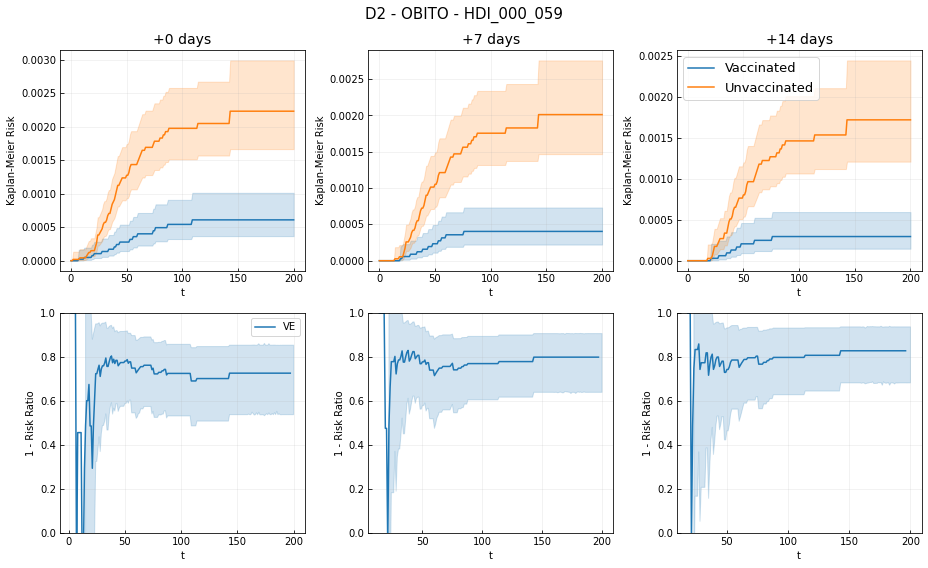

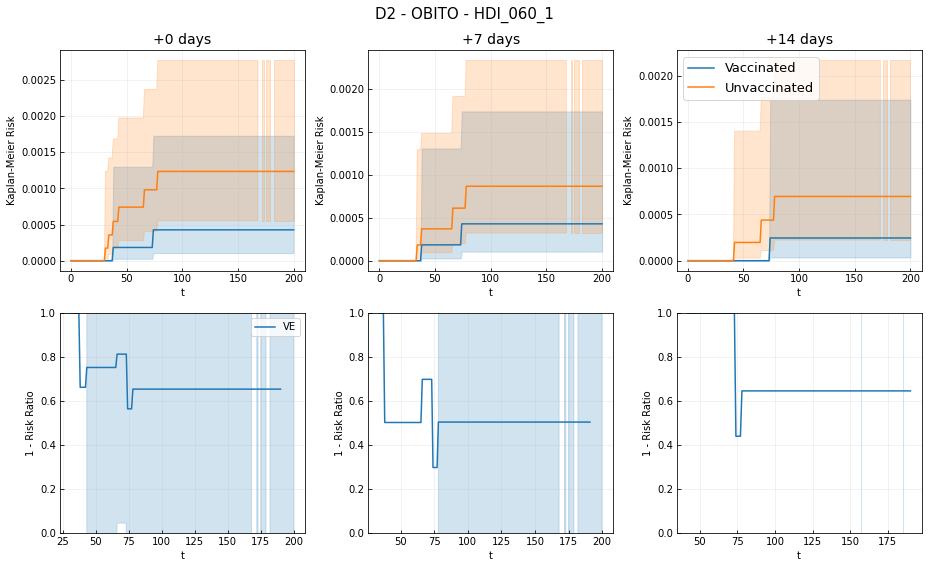

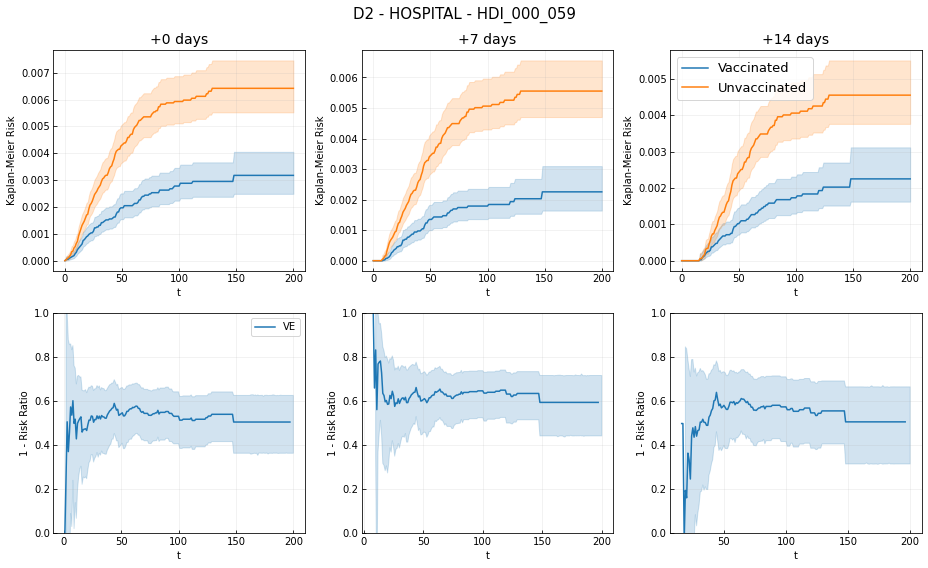

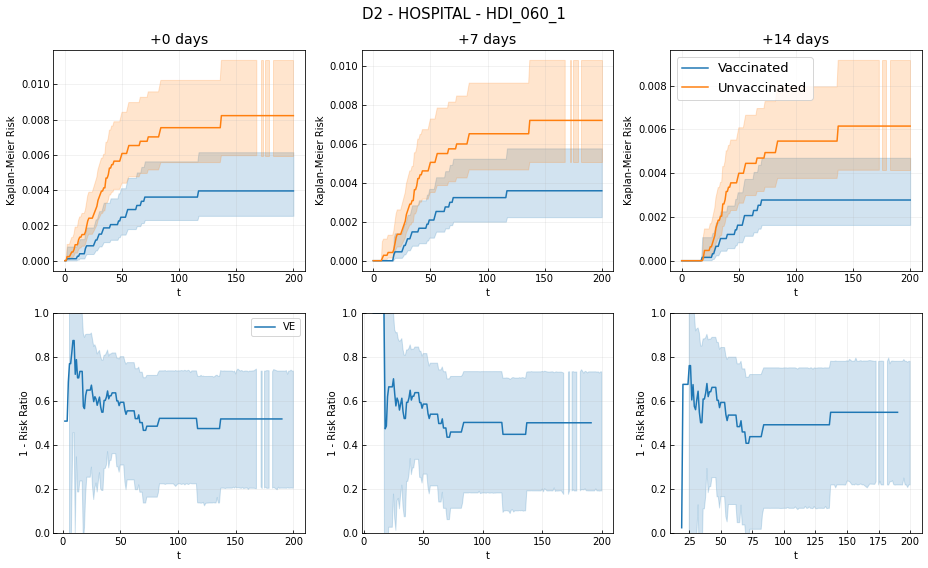

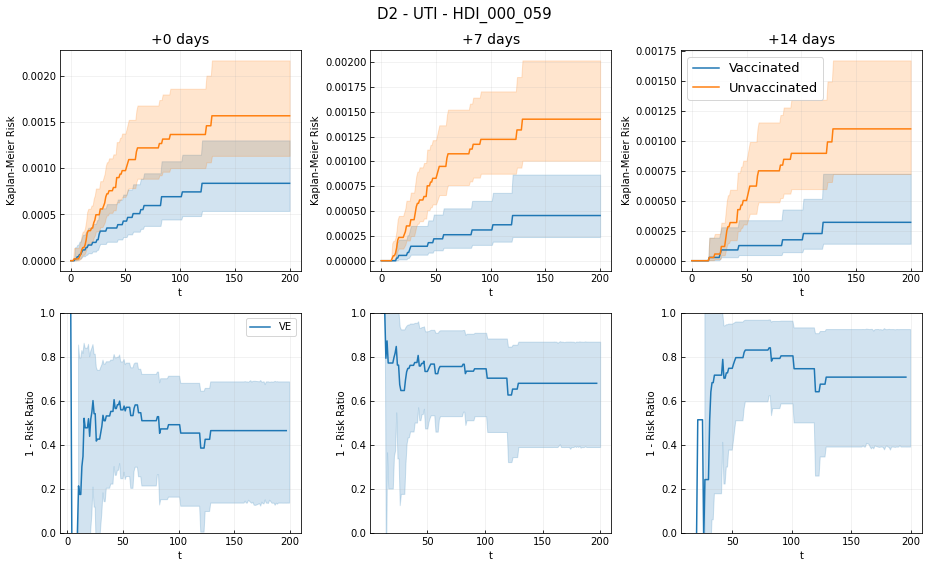

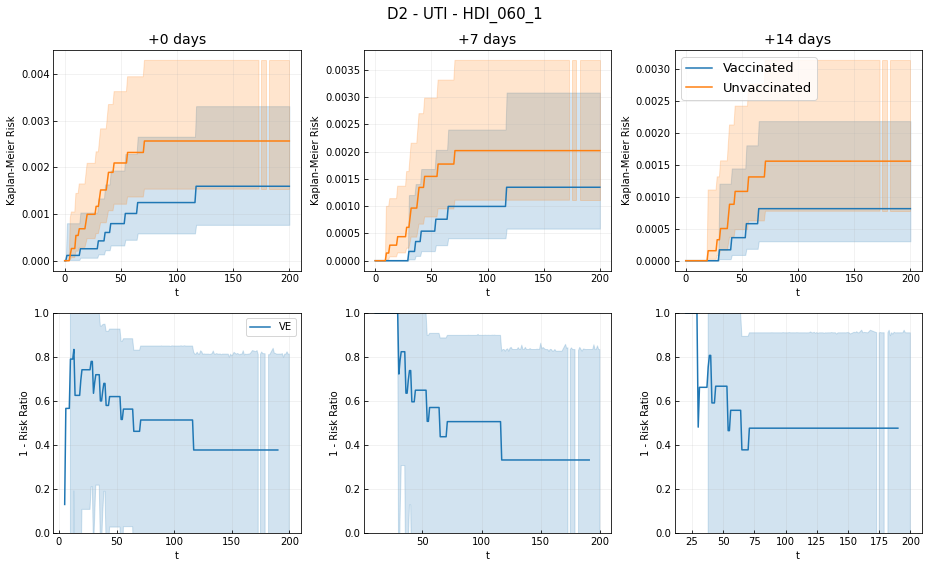

In [15]:
for j in ["OBITO", "HOSPITAL", "UTI"]:
    fig, ax = plot_res_hdi("NOVO", 2, j, "D2", hdi_str="HDI_000_059")
    fig1, ax1 = plot_res_hdi("NOVO", 2, j, "D2", hdi_str="HDI_060_1")
    #fig.savefig(os.path.join("..", "output", "figs", "Fig2022_MarchRuns", f"D2_{j}_HDI_000_060_21JAN2021_31AUG2021.png"))
    #fig1.savefig(os.path.join("..", "output", "figs", "Fig2022_MarchRuns", f"D2_{j}_HDI_060_1_21JAN2021_31AUG2021.png"))

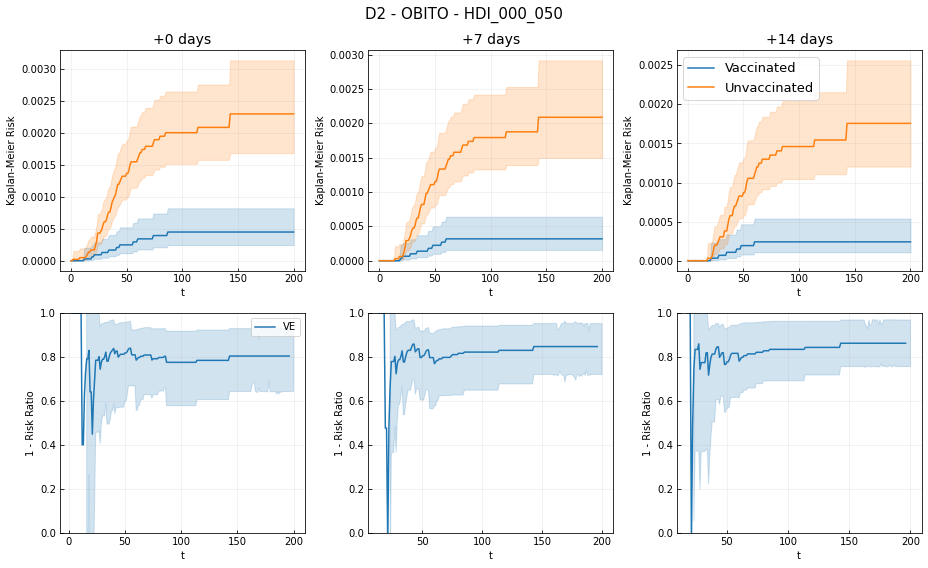

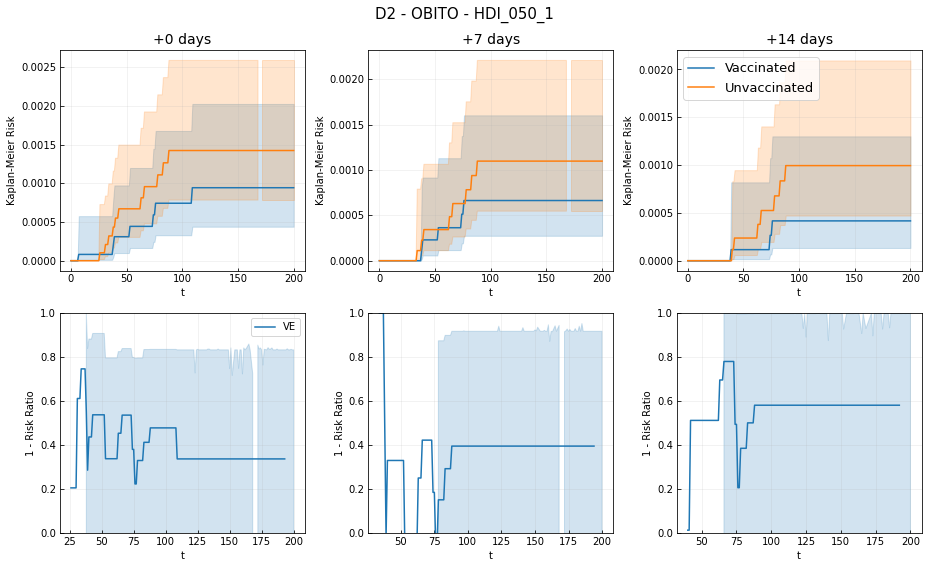

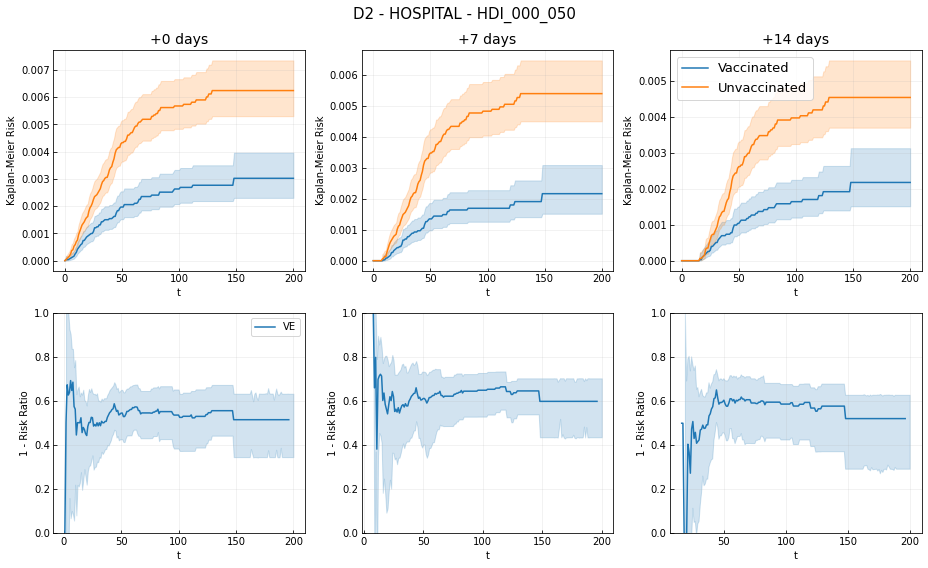

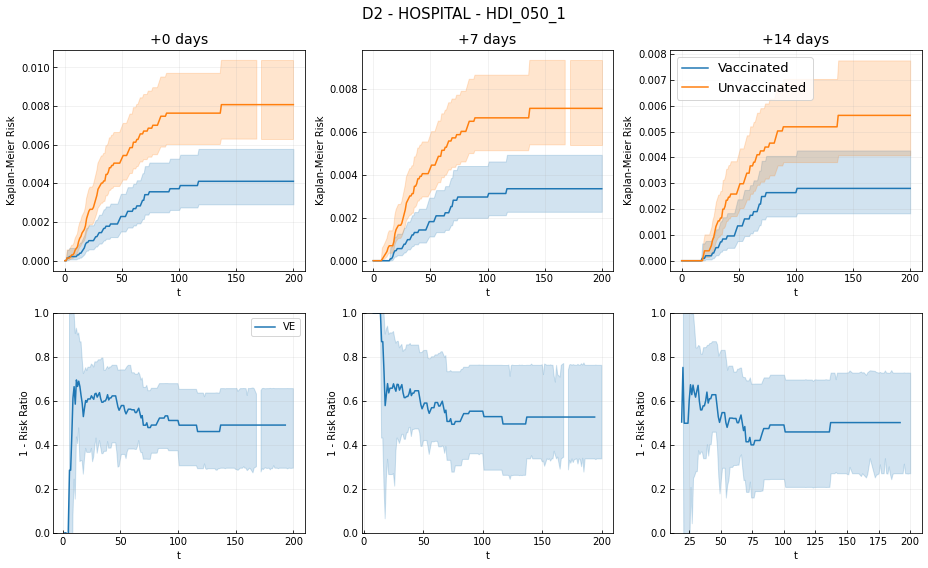

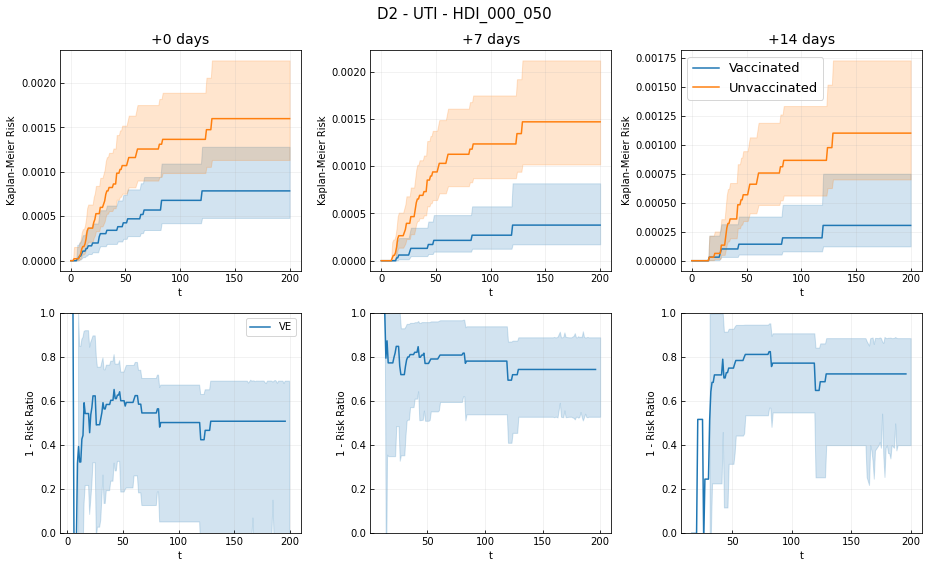

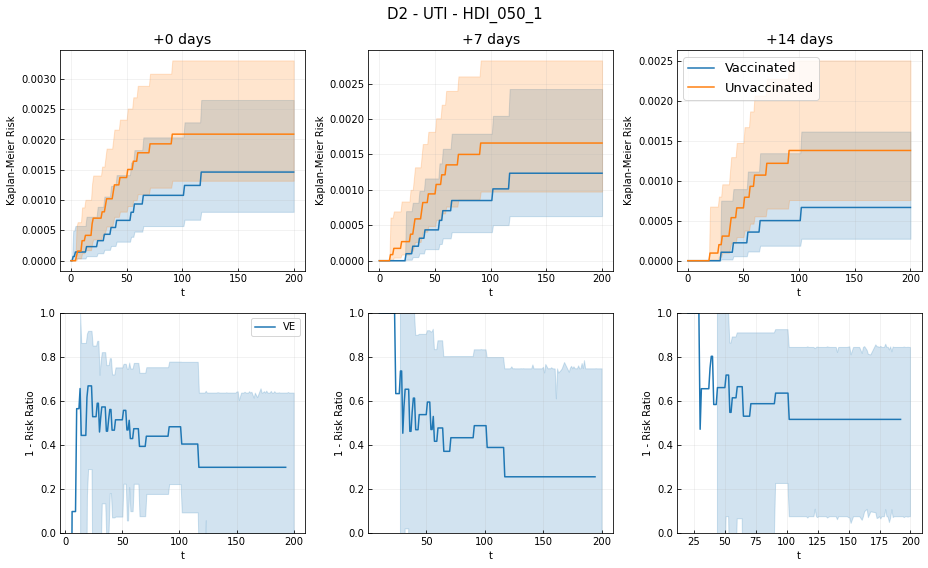

In [41]:
for j in ["OBITO", "HOSPITAL", "UTI"]:
    fig, ax = plot_res_hdi("NOVO", 2, j, "D2", hdi_str="HDI_000_050")
    fig1, ax1 = plot_res_hdi("NOVO", 2, j, "D2", hdi_str="HDI_050_1")
    fig.savefig(os.path.join("..", "output", "figs", "Fig2022_MarchRuns", f"D2_{j}_HDI_000_050_21JAN2021_31AUG2021.png"))
    fig1.savefig(os.path.join("..", "output", "figs", "Fig2022_MarchRuns", f"D2_{j}_HDI_050_1_21JAN2021_31AUG2021.png"))

### Age

In [42]:
def plot_res_age(prefix, hdi, event, dose, age_str, dates="21JAN2021_31AUG2021"):
    '''
    
    '''
    hash_hdi = {
        2: "WITH HDI", 0: "WITHOUT HDI",
    }
    res_folder = os.path.join(pareamento_folder, "CORONAVAC", f"{prefix}_HDI_{hdi}_{dates}")
    surv_folder = os.path.join(res_folder, "SURVIVAL", "SEED1")
    df_km0 = pd.read_excel(os.path.join(surv_folder, f"KM_events_{dose}_{event}_DAY0.xlsx"), sheet_name=f"KM_{age_str}")
    df_ve0 = pd.read_excel(os.path.join(surv_folder, f"VE_{dose}_{event}_DAY0.xlsx"), sheet_name=f"{age_str}")
    df_km7 = pd.read_excel(os.path.join(surv_folder, f"KM_events_{dose}_{event}_DAY7.xlsx"), sheet_name=f"KM_{age_str}")
    df_ve7 = pd.read_excel(os.path.join(surv_folder, f"VE_{dose}_{event}_DAY7.xlsx"), sheet_name=f"{age_str}")
    df_km14 = pd.read_excel(os.path.join(surv_folder, f"KM_events_{dose}_{event}_DAY14.xlsx"), sheet_name=f"KM_{age_str}")
    df_ve14 = pd.read_excel(os.path.join(surv_folder, f"VE_{dose}_{event}_DAY14.xlsx"), sheet_name=f"{age_str}")
    
    fig, AX = plt.subplots(2,3, figsize=(13,8)) 
    sns.lineplot(x='t', y='KM(caso)', data=df_km0, ax=AX[0,0], color="tab:blue")
    sns.lineplot(x='t', y='KM(controle)', data=df_km0, ax=AX[0,0], color="tab:orange")
    AX[0,0].fill_between(df_km0['t'], df_km0['KM_lower_0.95(caso)'], df_km0['KM_upper_0.95(caso)'], color="tab:blue", alpha=0.2)
    AX[0,0].fill_between(df_km0['t'], df_km0['KM_lower_0.95(controle)'], df_km0['KM_upper_0.95(controle)'], color="tab:orange", alpha=0.2)
    sns.lineplot(x='t', y='VE_original', data=df_ve0, ax=AX[1,0], color="tab:blue", label="VE")
    AX[1,0].fill_between(df_ve0['t'], df_ve0["VE_lower_0.95"], df_ve0["VE_upper_0.95"], color="tab:blue", alpha=0.2)
    # --------
    sns.lineplot(x='t', y='KM(caso)', data=df_km7, ax=AX[0,1], color="tab:blue")
    sns.lineplot(x='t', y='KM(controle)', data=df_km7, ax=AX[0,1], color="tab:orange")
    AX[0,1].fill_between(df_km7['t'], df_km7['KM_lower_0.95(caso)'], df_km7['KM_upper_0.95(caso)'], color="tab:blue", alpha=0.2)
    AX[0,1].fill_between(df_km7['t'], df_km7['KM_lower_0.95(controle)'], df_km7['KM_upper_0.95(controle)'], color="tab:orange", alpha=0.2)
    sns.lineplot(x='t', y='VE_original', data=df_ve7, ax=AX[1,1], color="tab:blue")
    AX[1,1].fill_between(df_ve7['t'], df_ve7["VE_lower_0.95"], df_ve7["VE_upper_0.95"], color="tab:blue", alpha=0.2)
    
    # --------
    sns.lineplot(x='t', y='KM(caso)', data=df_km14, ax=AX[0,2], color="tab:blue", label="Vaccinated")
    sns.lineplot(x='t', y='KM(controle)', data=df_km14, ax=AX[0,2], color="tab:orange", label="Unvaccinated")
    AX[0,2].fill_between(df_km14['t'], df_km14['KM_lower_0.95(caso)'], df_km14['KM_upper_0.95(caso)'], color="tab:blue", alpha=0.2)
    AX[0,2].fill_between(df_km14['t'], df_km14['KM_lower_0.95(controle)'], df_km14['KM_upper_0.95(controle)'], color="tab:orange", alpha=0.2)
    sns.lineplot(x='t', y='VE_original', data=df_ve14, ax=AX[1,2], color="tab:blue")
    AX[1,2].fill_between(df_ve14['t'], df_ve14["VE_lower_0.95"], df_ve14["VE_upper_0.95"], color="tab:blue", alpha=0.2)
    
    for axis in [AX[0,0], AX[1,0], AX[0,1], AX[1,1], AX[0,2], AX[1,2]]:
        axis.grid(alpha=0.2)
        axis.tick_params(direction='in')
    for j in [0,1,2]:
        AX[1,j].set_ylim([0,1])
        AX[0,j].set_ylabel("Kaplan-Meier Risk")
        AX[1,j].set_ylabel("1 - Risk Ratio")
    AX[0,0].set_title("+0 days", fontsize=14)
    AX[0,1].set_title("+7 days", fontsize=14)
    AX[0,2].set_title("+14 days", fontsize=14)
    AX[0,2].legend(loc=2, prop={'size':13})
    title = f"{dose} - {event} - {age_str} - {hash_hdi[hdi]}"
    fig.suptitle(title, fontsize=15)
    plt.tight_layout()
    return fig, AX

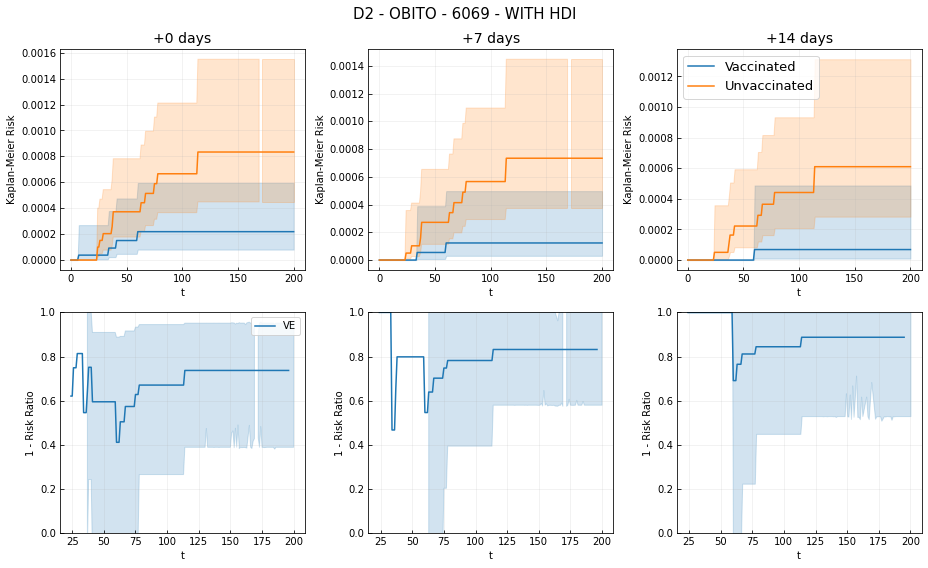

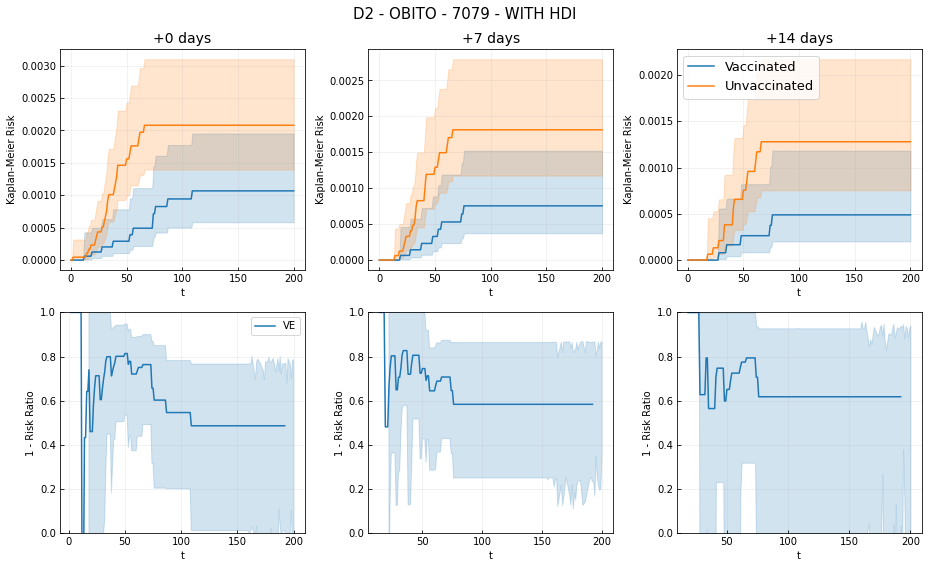

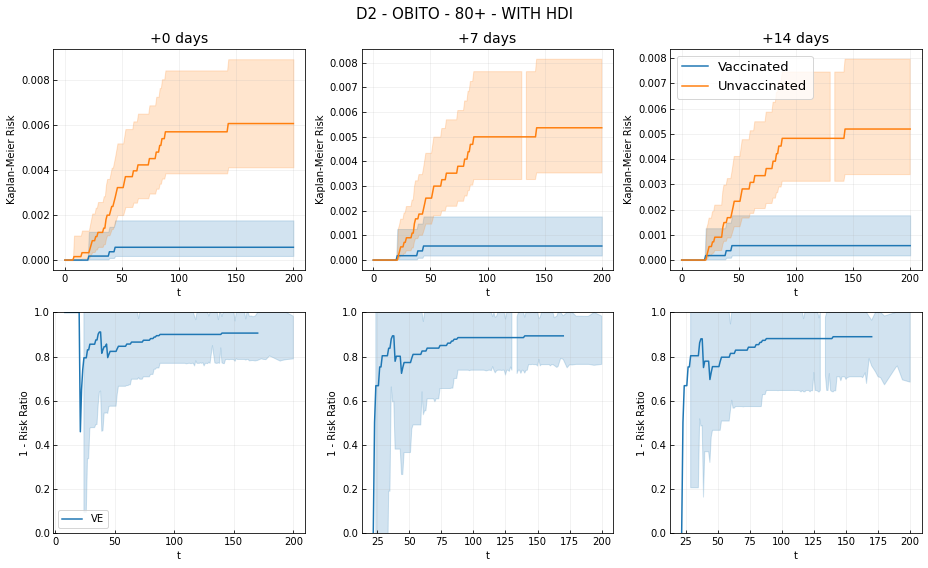

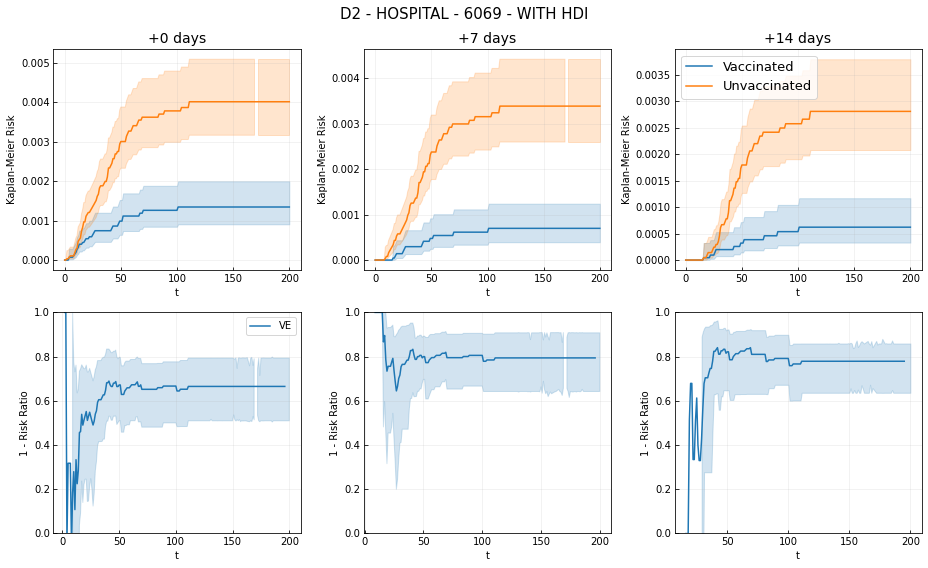

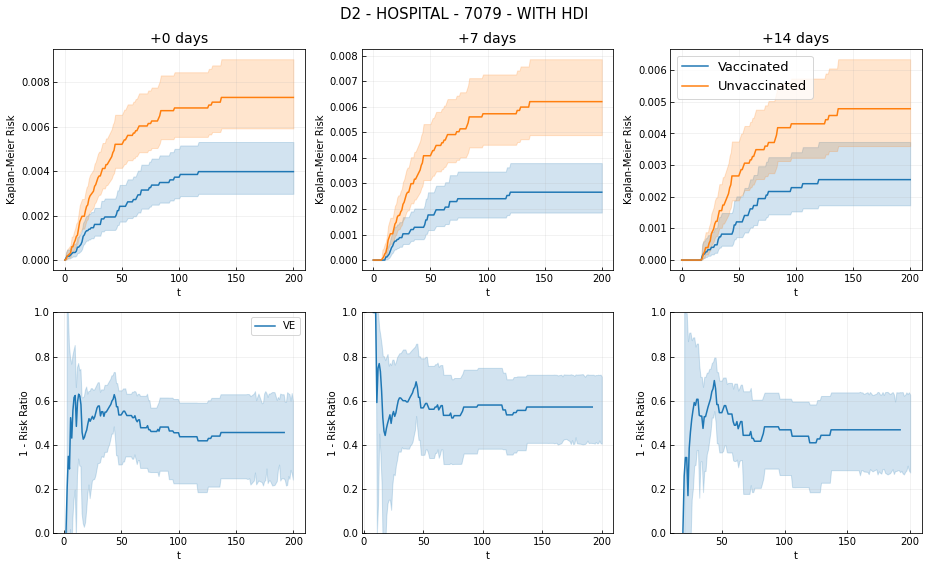

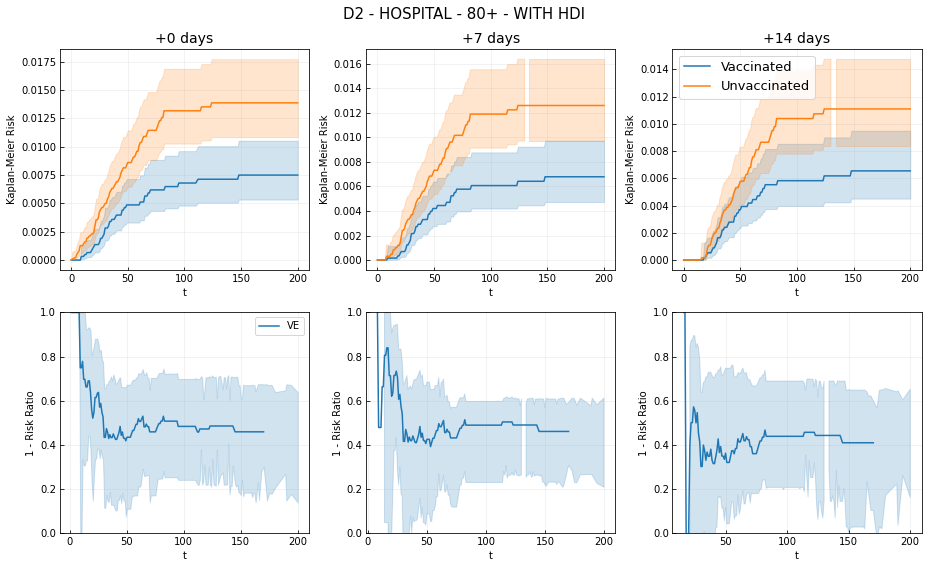

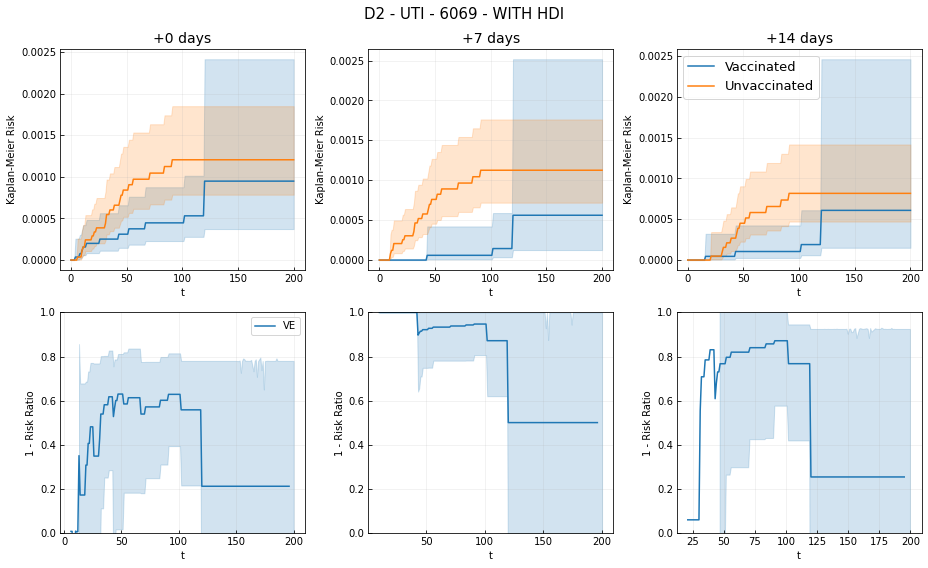

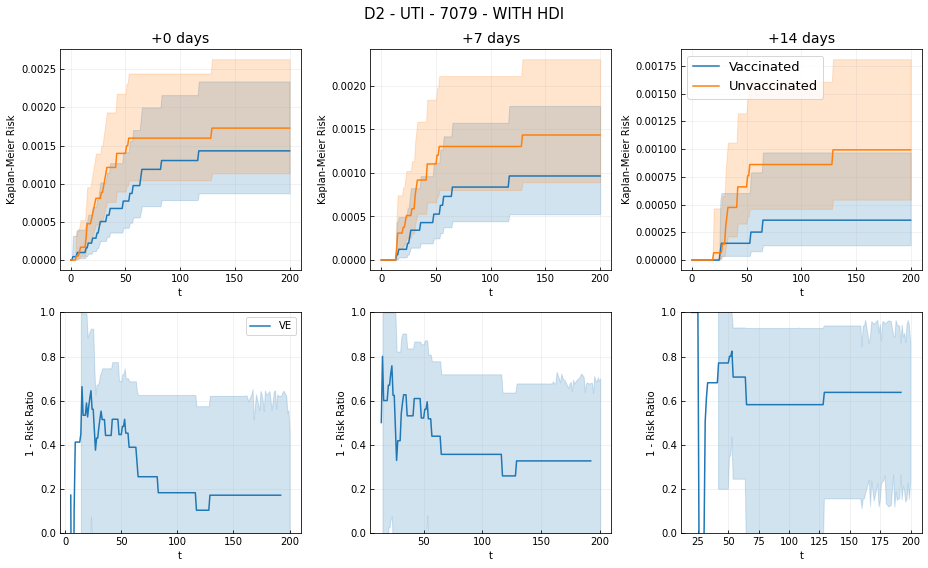

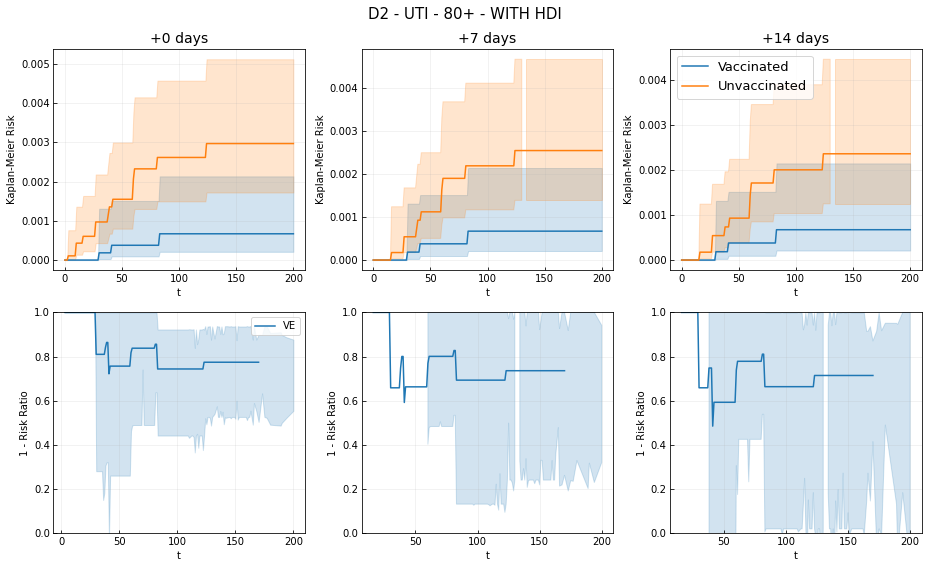

In [43]:
for j in ["OBITO", "HOSPITAL", "UTI"]:
    fig, ax = plot_res_age("NOVO", 2, j, "D2", age_str="6069")
    fig1, ax1 = plot_res_age("NOVO", 2, j, "D2", age_str="7079")
    fig2, ax2 = plot_res_age("NOVO", 2, j, "D2", age_str="80+")
    fig.savefig(os.path.join("..", "output", "figs", "Fig2022_MarchRuns", f"D2_{j}_HDI_2_AGE_6069_21JAN2021_31AUG2021.png"))
    fig1.savefig(os.path.join("..", "output", "figs", "Fig2022_MarchRuns", f"D2_{j}_HDI_2_AGE_7079_21JAN2021_31AUG2021.png"))
    fig2.savefig(os.path.join("..", "output", "figs", "Fig2022_MarchRuns", f"D2_{j}_HDI_2_AGE_80+_21JAN2021_31AUG2021.png"))

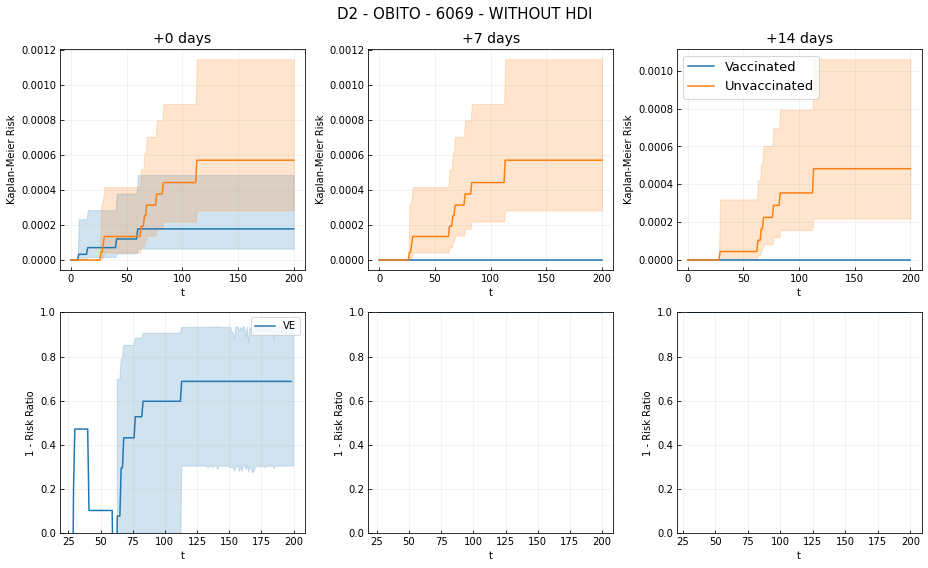

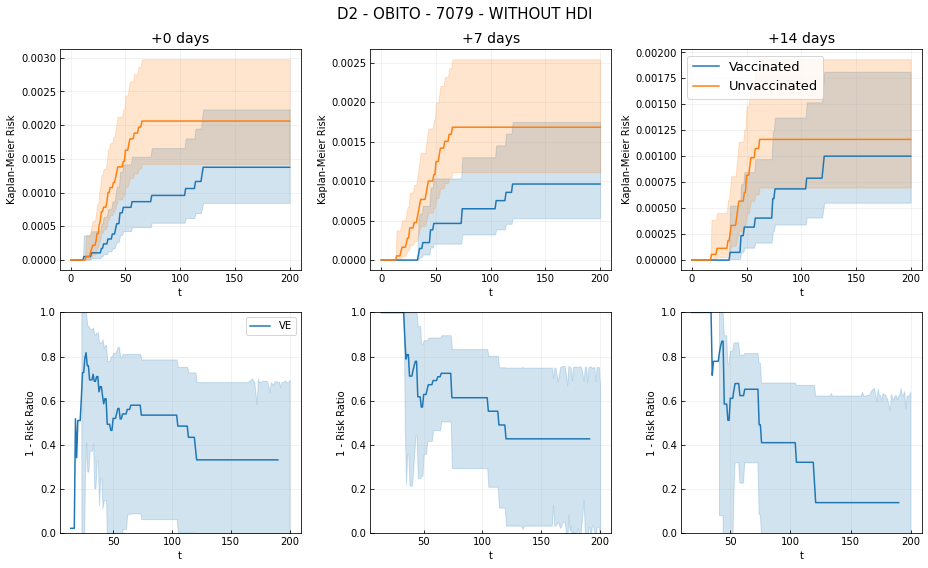

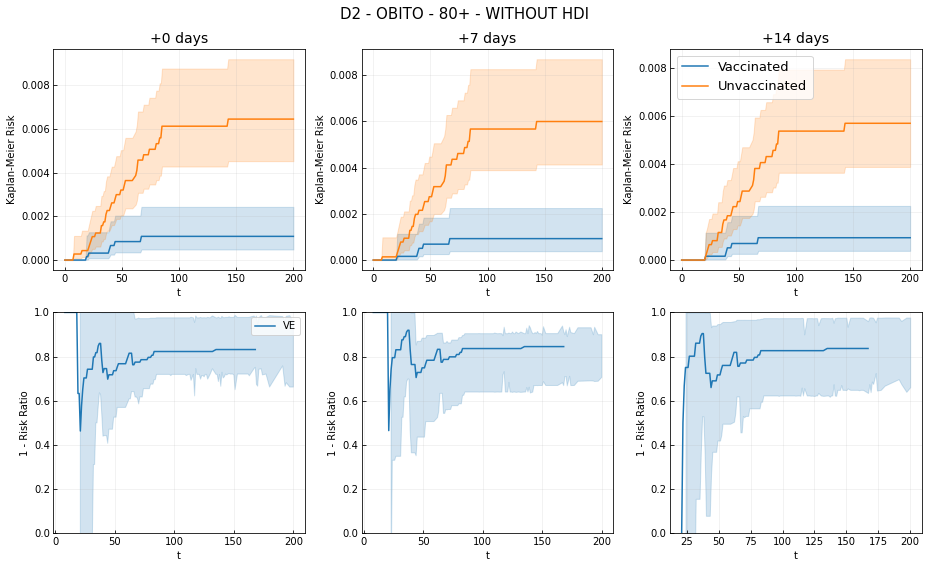

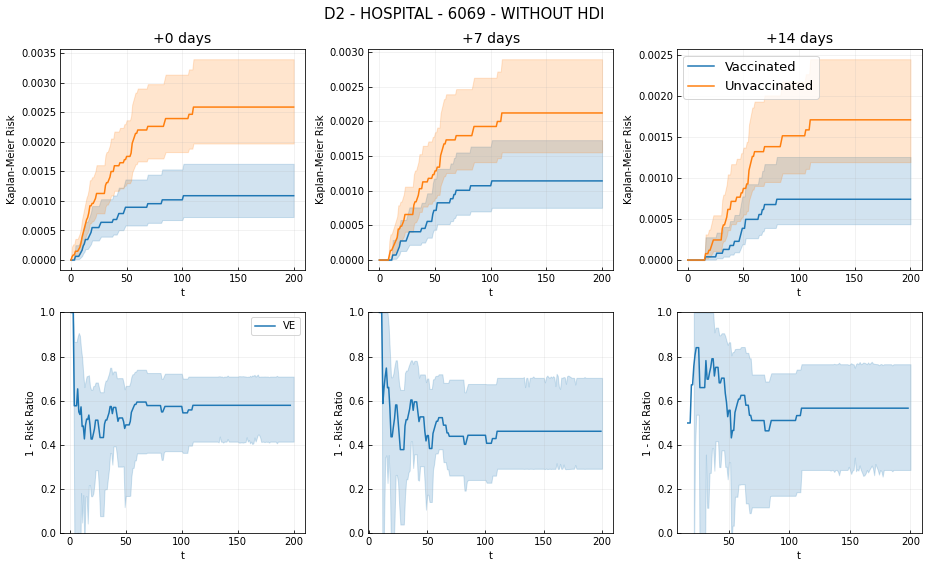

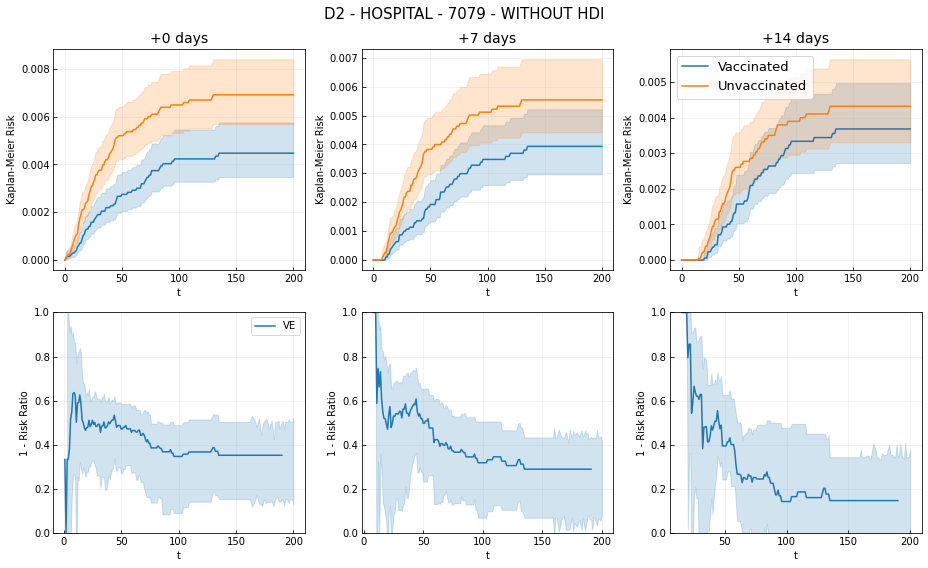

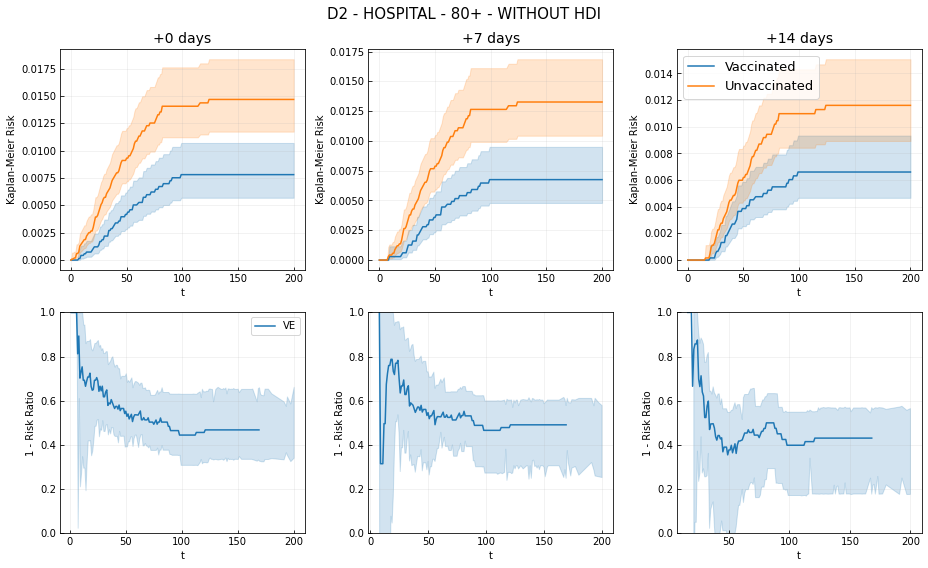

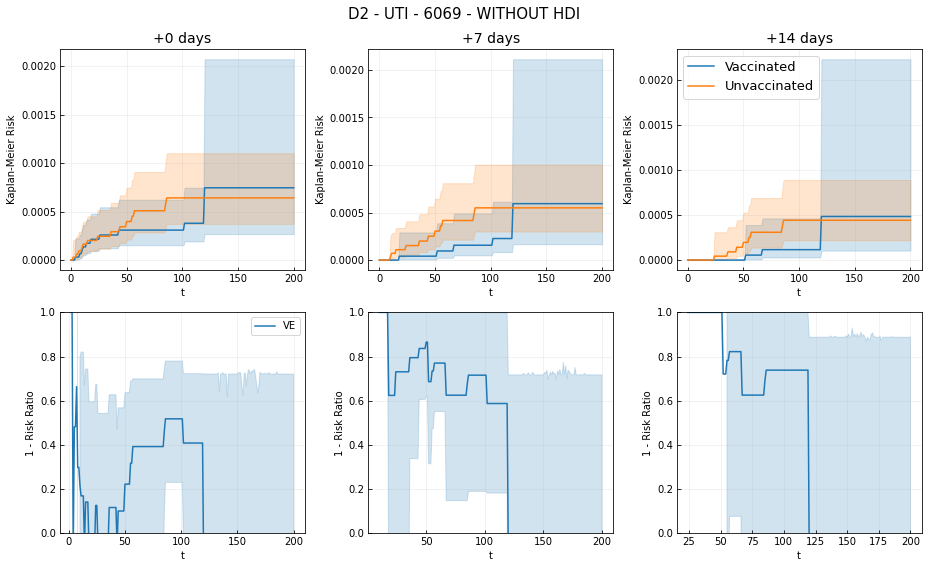

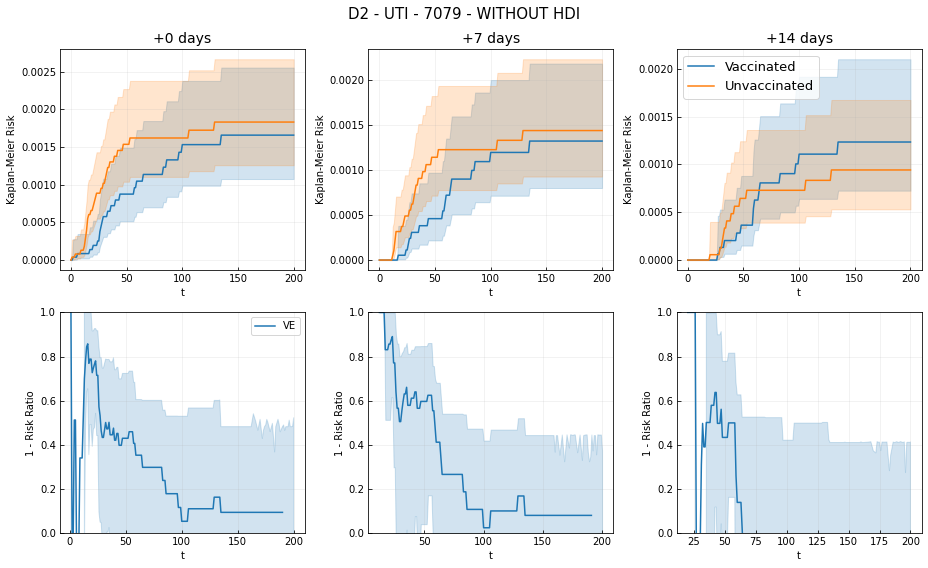

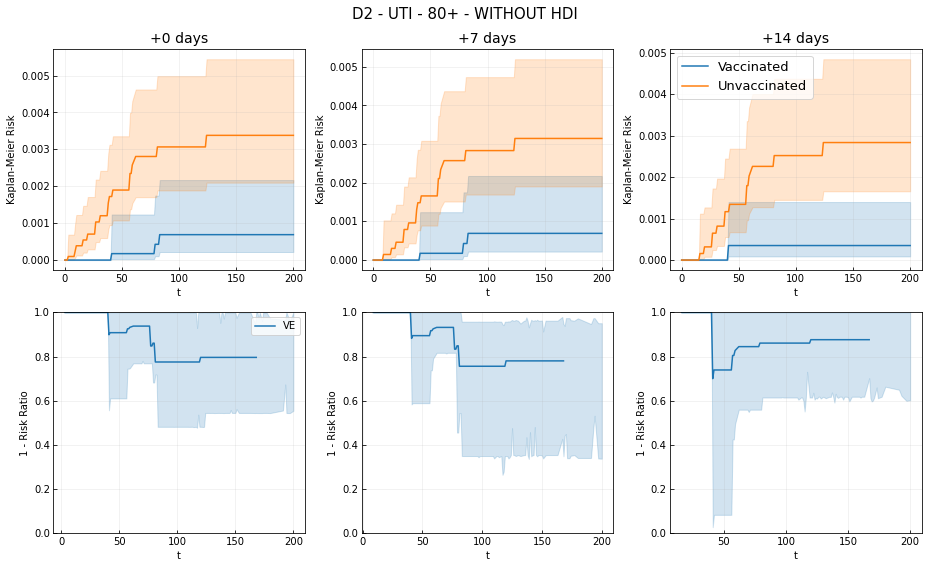

In [44]:
for j in ["OBITO", "HOSPITAL", "UTI"]:
    fig, ax = plot_res_age("NOVO", 0, j, "D2", age_str="6069")
    fig1, ax1 = plot_res_age("NOVO", 0, j, "D2", age_str="7079")
    fig2, ax2 = plot_res_age("NOVO", 0, j, "D2", age_str="80+")
    fig.savefig(os.path.join("..", "output", "figs", "Fig2022_MarchRuns", f"D2_{j}_HDI_0_AGE_6069_21JAN2021_31AUG2021.png"))
    fig1.savefig(os.path.join("..", "output", "figs", "Fig2022_MarchRuns", f"D2_{j}_HDI_0_AGE_7079_21JAN2021_31AUG2021.png"))
    fig2.savefig(os.path.join("..", "output", "figs", "Fig2022_MarchRuns", f"D2_{j}_HDI_0_AGE_80+_21JAN2021_31AUG2021.png"))